In [1]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
import optax
# from parent_dir import *
from reupload_ff_circuit.data_gen import data_generator


import os
import ipynbname  

from reupload_ff_circuit.util import *
from reupload_ff_circuit.q_functions import *
from reupload_ff_circuit.q_circuits import *

In [2]:
# Added to silence some warnings.
from jax import config
config.update("jax_enable_x64", True)
import jax
import jax.numpy as jnp
jax.config.update('jax_platform_name', 'cpu')

In [3]:
# nb_fname = ipynbname.name()
# ver = nb_fname[nb_fname.index('v'):nb_fname.index('_')] if 'v' in nb_fname else nb_fname
date, day = time.strftime("%Y%m%d-%H%M"), time.strftime("%Y%m%d-%H")
cwd = os.getcwd()

In [4]:
ver = 'Demo_v1.0'
problem = 'breast_cancer' #'3 circles'#'moon'#
shape =  "tetrahedron"#"binary" #"bitwise" #"square plane"#
rot = 'zyz' #'yzy' #'xzx' #
num_training = 200 #400
num_test = 50 #100

max_n_converge = 10
thres_converge = 0.0001
seed_num = data_seed_num= 40#

In [5]:
training_noise =  False  #True#,
test_noise = False  #True#,

In [6]:
# service = QiskitRuntimeService()
# backend = service.backend("ibm_brisbane")  # ibm_strasbourg # 
# print('backend:', backend.name)

In [7]:
configs = {'noise': False,  #####
           'fake_backend': False,    #True#,
           'real_device':  False,    #True#
           'preprocess' : "scaling",  #None #  "normalization"# "standardization" #
           # 'backend' : backend,
           'backend_name' : None, #'ibm_brisbane', # 'ibm_strasbourg', # '''None means least_busy backend'''
           'rot' : rot, 
           'shape' : shape,
          }

In [8]:
import random
num_cvs = 5
num_seeds = 10
random.seed(seed_num)
seeds = [random.randint(0, int(1e5)) for _ in range(num_seeds)]
seeds

[60110, 75954, 68678, 4174, 32150, 37018, 87104, 83505, 87073, 27044]

In [9]:
# set range of aubits and rotations
num_settings = 1, 5, 1, 1, 1 # r_enc, r_q ,r_f, r_r, r_rot ## run the setting with n values
start_values = 5, 1, 1, 1, 3 # e0, q0, f0, r0, rot0 

settings = setting_generator(num_settings,start_values)
settings=settings[:3]

In [10]:
h_params= {'lr':[[0.15,0.05,0.01],[0.15,0.05,0.01,0.001,0.0001]],  #
           'max_epoch':[60],#3200
           'batch_size':[50,100,300],
           'dynamic_size':[50],
           'thres':[[0.05,0.03,0.01]]}#]}#[0.05],
h_pms = [(tuple(i),j,k,l,tuple(m)) for i in h_params['lr'] for j in h_params['max_epoch'] for k in h_params['batch_size'] for l in h_params['dynamic_size'] for m in h_params['thres']]
h_pms

[((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01)),
 ((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))]

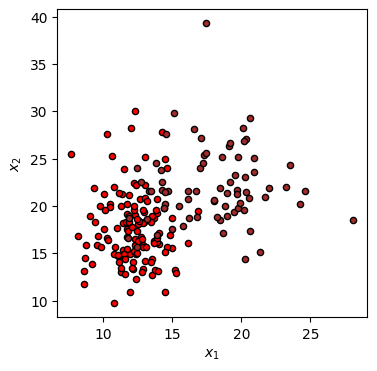

In [11]:
Xdata, ydata = data_gen(problem,num_training)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
plt.show()

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


theta = [0.         1.91063324 1.91063324 1.91063324] 
phi = [0.         2.0943951  4.1887902  6.28318531]
c_states= [[[ 1.        +0.00000000e+00j]
  [ 0.        +0.00000000e+00j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829+7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [-0.40824829-7.07106781e-01j]]

 [[ 0.57735027+0.00000000e+00j]
  [ 0.81649658-1.99983985e-16j]]] 
shape: (4, 2, 1)


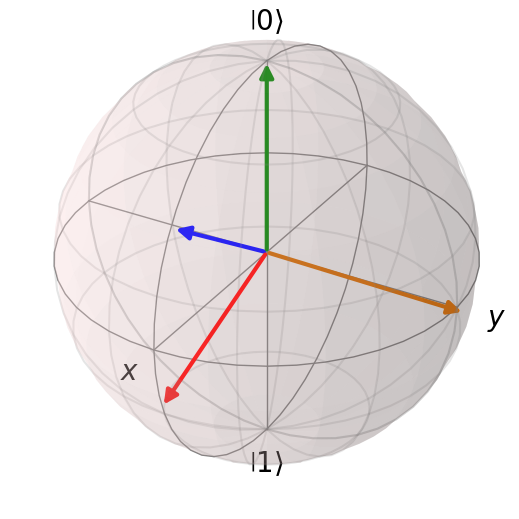

In [12]:
# Define output labels as quantum state vectors
num_class = np.unique(data_gen(problem)[1]).max()
c_states, dm_labels, Yc = predefined_states_dm(shape,settings[0][1]) #(shape,num_qubits)
configs['dm_labels'] = dm_labels
configs['num_class_1q'] = len(c_states)
configs['Yc'] = totuple(Yc)

In [13]:
def fit(params: optax.Params, optimizer: optax.GradientTransformation,
        opt_state,x,y,*args,x_valid=None,y_valid=None,**kwargs) -> optax.Params:
  #opt_state = optimizer.init(params)
  # for k, v in kwargs.items():
  #   if 'noise' in k:
  #       noise = v
  def step(params, opt_state,x,y):
    loss_batches = jnp.array([])
    predicted_train = jnp.array([])
    iter_batch = iterate_minibatches(x, y, batch_size=batch_size)
    for x_batch, y_batch in iter_batch:
        predicted_batch, loss_batch , grads = jtest(params, x_batch, y_batch,*args,**kwargs)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        loss_batches = jax.numpy.append(loss_batches,loss_batch)
        predicted_train = jax.numpy.append(predicted_train, predicted_batch)
    loss_value = jnp.average(loss_batches)
    return params, opt_state, loss_value, predicted_train
  n_converge = 0
  
  learning_rate,max_epoch,batch_size,dynamic_size,threshold = kwargs['_h_pm']
  iter_lr = kwargs['iter_lr']
  iter_thres = kwargs['iter_thres']
  lr = kwargs['lr']
  thres_n = kwargs['thres_n']
  

  #loss_history = []
  params_history = []
  state_history = []
  valid_accuracy_history=[]
  ave_loss = 1
  l_r = lr
  thres = thres_n
  for i  in range(max_epoch):
    i=i+1
    state_history.append(opt_state) #save value advance otherwise it saves the updated one
    params_history.append(params)
    
    params, opt_state, loss_value , predicted_train= step(params, opt_state, x, y)
    accuracy_train = accuracy_score(y, predicted_train)
    
    print(f'step {i}, accuracy_train:{accuracy_train}, loss: {loss_value}')
    if x_valid is not None and y_valid is not None:
        accuracy_valid, loss_valid = scores(params, x_valid, y_valid, *args, **kwargs)
        valid_loss_history.append(float(loss_valid))
        valid_accuracy_history.append(float(accuracy_valid))
    loss_history.append(float(loss_value))    
    accuracy_history.append(float(accuracy_train))
    
    if i%dynamic_size==0:
        c_ave = sum(loss_history[-dynamic_size:])/dynamic_size #current loss average
        now_thres = abs(c_ave-ave_loss)/ave_loss
        print(now_thres)
        if  now_thres<=thres:
            try:
                l_r=next(iter_lr)#learning_rate
                #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size:])-dynamic_size
                loc_best_loss = np.argmin(loss_history[-dynamic_size:])-dynamic_size
                params = params_history[loc_best_loss]
                #print('best known accuracy:', accuracy_history[loc_best_accuracy]) #update lr based on accuracy
                print('accuracy of best loss :', accuracy_history[loc_best_loss]) #update lr based on loss
                
                opt_state.hyperparams['learning_rate'] = l_r
                #print('lr:', l_r, opt_state.hyperparams['learning_rate'])
                try:
                    thres = next(iter_thres)
                except StopIteration:
                    print(thres)
            except StopIteration:
                pass
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print(i)
        n_converge  = n_converge+1 if now_thres<thres_converge else 0
        ave_loss = c_ave
        
    if i==max_epoch or n_converge==max_n_converge:
        n_converge = 1 if n_converge==0 else n_converge 
        #loc_best_accuracy = np.argmax(accuracy_history[-dynamic_size*10:])-dynamic_size*10
        candidate_history = loss_history if x_valid is None else valid_loss_history
        loc_best_loss = np.argmin(candidate_history[-dynamic_size*n_converge:])-dynamic_size*n_converge
        params = params_history[loc_best_loss]
        opt_state = state_history[loc_best_loss]
        num_epoch = i
        print('lr:', l_r, opt_state.hyperparams['learning_rate'])
        print('accuracy of best loss:',accuracy_history[loc_best_loss],loc_best_loss)
        #print('best known accuracy:',accuracy_history[loc_best_loss],loc_best_loss)
        break
  return params, l_r, opt_state, num_epoch

In [15]:
if 'lay' not in ver:
    # ver = ver+f'_lay{num_layers}'
    ver = ver+'_'+configs['backend_name']+'_'+date if configs['noise'] else ver+'_'+date
#print(os.getcwd())
filename = ver[:ver.index('_')]
os.chdir(cwd)
if not os.path.exists('Figures/'+filename+'/'+day):
    if not os.path.exists('Figures/'):
        os.mkdir('Figures/')
    try:
        os.mkdir('Figures/'+filename)
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except FileExistsError:
        os.mkdir('Figures/'+filename+'/'+day)
        os.chdir('Figures/'+filename+'/'+day)
    except Exception as e:
        print(e)
else: os.chdir('Figures/'+filename+'/'+day)
print(os.getcwd())

/mnt/c/Users/paes20705/OneDrive/桌面/Main Programs/Python/Jupyter/Re-upload and feed-forward circuits/Figures/Demo/20241212-18


In [16]:
def n_cv(n_fold, x, y, setting, *var, seed_num=42, **kwargs):
    from sklearn.utils import shuffle
    from sklearn.model_selection import StratifiedKFold
    global loss_history,valid_loss_history, accuracy_history, loss_history_cvs 
    global iter_lr, iter_thres, lr, thres_n
    
    skf = StratifiedKFold(n_splits=5)
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting 
    start = time.process_time()
    cv_rsts= []
    # kwargs['qc'] = qcircuit(*setting, **kwargs)
    
    for index_tr, index_te in skf.split(x, y):
        cv_xtr, cv_ytr = x[index_tr], y[index_tr]
        cv_xte, cv_yte = x[index_te], y[index_te]
        
        kwargs['iter_lr'] = iter(learning_rate)
        kwargs['iter_thres'] = iter(list(threshold))
        kwargs['lr'] = next(kwargs['iter_lr'])
        kwargs['thres_n'] = next(kwargs['iter_thres'])
        
        # initialize random weights
        params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, num_class, seed_num)
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=kwargs['lr'])#optax.adam(learning_rate=0.05)
        opt_state = optimizer.init(params)

        loss_history = []
        valid_loss_history = []
        accuracy_history = []

        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, cv_xtr, cv_ytr, x_valid=cv_xte, y_valid=cv_yte,*setting,**kwargs)
        accuracy_train, loss, accuracy_test, loss_test = scores(params, cv_xtr, cv_ytr,*setting, 
                                                                x_te=cv_xte, y_te=cv_yte, **kwargs)
        loss_history_cvs.append([loss_history,valid_loss_history])
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_test))
        print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
        cv_rsts.append([accuracy_test, loss])
        plot_loss_history(loss_history, valid_loss_history, setting=setting, fig_name=None)
        
    end = time.process_time()
    print("cv_time ：%f s" % (end - start))
    return sum(np.array(cv_rsts)[:,0])/n_fold, sum(np.array(cv_rsts)[:,1])/n_fold

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.2375, loss: 0.33005513798981717
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.4125, loss: 0.22357245248543833
step 3, accuracy_train:0.65, loss: 0.15327987989859682
step 4, accuracy_train:0.63125, loss: 0.16082292120014596
step 5, accuracy_train:0.66875, loss: 0.14759047405473302
step 6, accuracy_train:0.65, loss: 0.13978763115207793
step 7, accuracy_train:0.66875, loss: 0.14228111422793102
step 8, accuracy_train:0.64375, loss: 0.1331344467573849
step 9, accuracy_train:0.74375, loss: 0.1064686736387008
step 10, accuracy_train:0.74375, loss: 0.10870540788831004
step 11, accuracy_train:0.75, loss: 0.10493758634787259
step 12, accuracy_train:0.7625, loss: 0.10264154964846234
step 13, accuracy_train:0.78125, loss: 0.1019297590

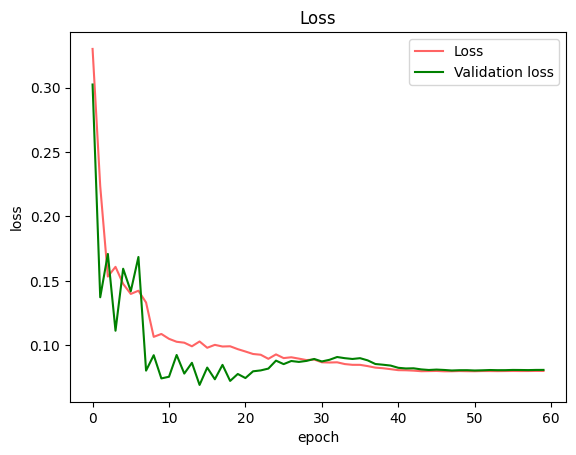

step 1, accuracy_train:0.25, loss: 0.3063534609687979
step 2, accuracy_train:0.3875, loss: 0.26253421861617965
step 3, accuracy_train:0.35, loss: 0.25202072346681614
step 4, accuracy_train:0.6375, loss: 0.17665273869155118
step 5, accuracy_train:0.75, loss: 0.12468124955811383
step 6, accuracy_train:0.64375, loss: 0.15485624039623552
step 7, accuracy_train:0.775, loss: 0.10603668458882247
step 8, accuracy_train:0.7625, loss: 0.10445002207981853
step 9, accuracy_train:0.76875, loss: 0.11913984366316205
step 10, accuracy_train:0.76875, loss: 0.108200303557762
step 11, accuracy_train:0.79375, loss: 0.10034502066141651
step 12, accuracy_train:0.75625, loss: 0.10062380808910805
step 13, accuracy_train:0.83125, loss: 0.09877736470166058
step 14, accuracy_train:0.8125, loss: 0.09666911233260382
step 15, accuracy_train:0.8, loss: 0.0947059987836063
step 16, accuracy_train:0.8125, loss: 0.09119114883911017
step 17, accuracy_train:0.8375, loss: 0.09280294943724547
step 18, accuracy_train:0.81875

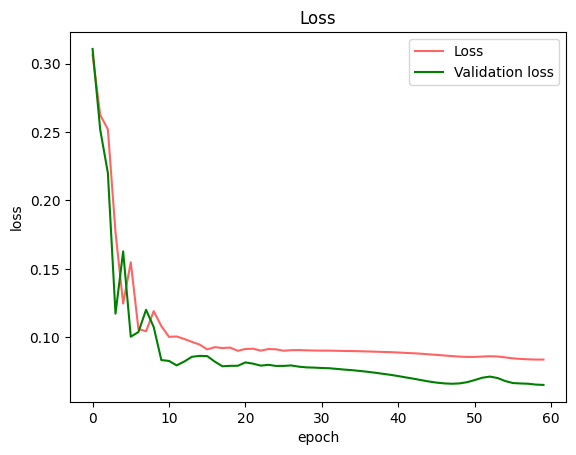

step 1, accuracy_train:0.20625, loss: 0.3265464072432038
step 2, accuracy_train:0.4, loss: 0.2585755787657718
step 3, accuracy_train:0.475, loss: 0.19908734125124294
step 4, accuracy_train:0.45, loss: 0.22054868091959684
step 5, accuracy_train:0.59375, loss: 0.15424042305922264
step 6, accuracy_train:0.63125, loss: 0.13834336897914548
step 7, accuracy_train:0.65, loss: 0.14236582224578165
step 8, accuracy_train:0.65, loss: 0.12701102784376
step 9, accuracy_train:0.71875, loss: 0.12820766822920265
step 10, accuracy_train:0.6375, loss: 0.1301947360540654
step 11, accuracy_train:0.675, loss: 0.12327708151067346
step 12, accuracy_train:0.69375, loss: 0.12110980368005808
step 13, accuracy_train:0.6875, loss: 0.11919653052487678
step 14, accuracy_train:0.68125, loss: 0.12258074920075743
step 15, accuracy_train:0.7, loss: 0.12090097190666363
step 16, accuracy_train:0.65625, loss: 0.1181797931288327
step 17, accuracy_train:0.6875, loss: 0.11805837171279623
step 18, accuracy_train:0.7, loss: 0.

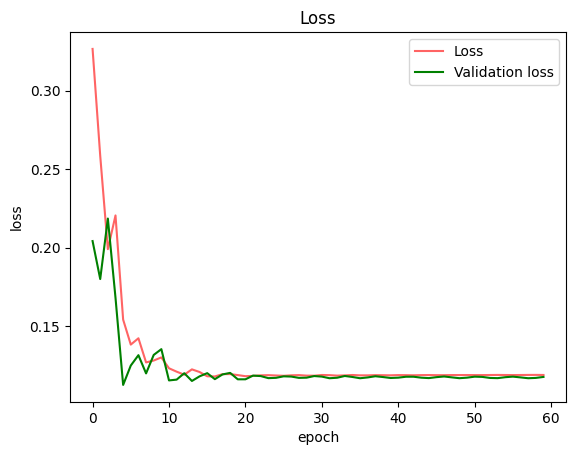

step 1, accuracy_train:0.21875, loss: 0.32849484347060315
step 2, accuracy_train:0.5375, loss: 0.2385563194004845
step 3, accuracy_train:0.46875, loss: 0.23591994895260737
step 4, accuracy_train:0.66875, loss: 0.19765268765779404
step 5, accuracy_train:0.65, loss: 0.14535219091114376
step 6, accuracy_train:0.675, loss: 0.12554812177243302
step 7, accuracy_train:0.7625, loss: 0.1166239304680726
step 8, accuracy_train:0.7375, loss: 0.11866925847348644
step 9, accuracy_train:0.8, loss: 0.1096096667879631
step 10, accuracy_train:0.775, loss: 0.11400826806247544
step 11, accuracy_train:0.75625, loss: 0.10298896630109364
step 12, accuracy_train:0.8125, loss: 0.09919458904366991
step 13, accuracy_train:0.8125, loss: 0.1029362200154257
step 14, accuracy_train:0.7875, loss: 0.09497474353709529
step 15, accuracy_train:0.79375, loss: 0.09705808399712657
step 16, accuracy_train:0.8125, loss: 0.09233356724892666
step 17, accuracy_train:0.80625, loss: 0.09323402148870544
step 18, accuracy_train:0.79

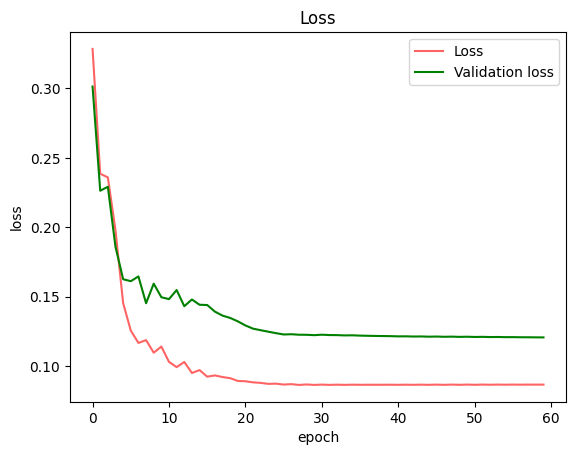

step 1, accuracy_train:0.2375, loss: 0.28644089377023885
step 2, accuracy_train:0.50625, loss: 0.2089256092134002
step 3, accuracy_train:0.51875, loss: 0.20734498976773194
step 4, accuracy_train:0.55625, loss: 0.18840646309066578
step 5, accuracy_train:0.5875, loss: 0.1614189979198939
step 6, accuracy_train:0.60625, loss: 0.13418690906267552
step 7, accuracy_train:0.73125, loss: 0.11952956130114264
step 8, accuracy_train:0.775, loss: 0.09318307090177896
step 9, accuracy_train:0.8375, loss: 0.0729371762826933
step 10, accuracy_train:0.8625, loss: 0.07404821235794581
step 11, accuracy_train:0.8625, loss: 0.06970894339658942
step 12, accuracy_train:0.86875, loss: 0.07028077953939947
step 13, accuracy_train:0.88125, loss: 0.0658882727057363
step 14, accuracy_train:0.88125, loss: 0.0639384199668769
step 15, accuracy_train:0.89375, loss: 0.06597496638013406
step 16, accuracy_train:0.85625, loss: 0.0688638989094229
step 17, accuracy_train:0.8625, loss: 0.06930697960120341
step 18, accuracy_tr

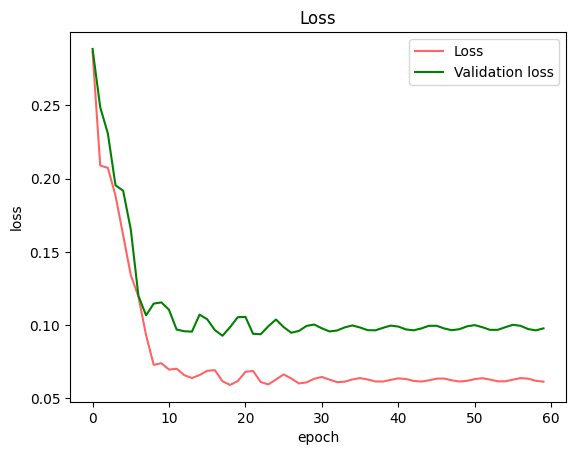

cv_time ：42.206316 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.31875, loss: 0.298002052766619
step 2, accuracy_train:0.16875, loss: 0.3163905972184019
step 3, accuracy_train:0.4625, loss: 0.25709872043047816
step 4, accuracy_train:0.55625, loss: 0.18885476003647544
step 5, accuracy_train:0.59375, loss: 0.17305700254631556
step 6, accuracy_train:0.55625, loss: 0.1752302663771962
step 7, accuracy_train:0.56875, loss: 0.1664777881485177
step 8, accuracy_train:0.7375, loss: 0.1384341343482887
step 9, accuracy_train:0.74375, loss: 0.11444502300228168
step 10, accuracy_train:0.7875, loss: 0.09897040230318492
step 11, accuracy_train:0.80625, loss: 0.09728284980502169
step 12, accuracy_train:0.83125, loss: 0.08814586543934205
step 13, accuracy_train:0.84375, loss: 0.08340595205072551
s

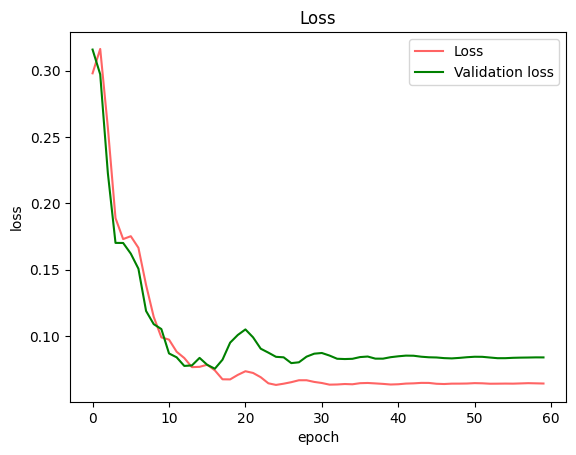

step 1, accuracy_train:0.325, loss: 0.2974913673683319
step 2, accuracy_train:0.20625, loss: 0.31317396718329643
step 3, accuracy_train:0.44375, loss: 0.25258390869395964
step 4, accuracy_train:0.45625, loss: 0.20588701706356327
step 5, accuracy_train:0.55625, loss: 0.17798382397612406
step 6, accuracy_train:0.5, loss: 0.19097620451997335
step 7, accuracy_train:0.4875, loss: 0.18958872231730267
step 8, accuracy_train:0.60625, loss: 0.16766444216770088
step 9, accuracy_train:0.6875, loss: 0.13912822730070717
step 10, accuracy_train:0.6625, loss: 0.13991668493477113
step 11, accuracy_train:0.71875, loss: 0.12562855186215105
step 12, accuracy_train:0.75, loss: 0.10387361434827838
step 13, accuracy_train:0.86875, loss: 0.0851989959105696
step 14, accuracy_train:0.85625, loss: 0.0737309459961221
step 15, accuracy_train:0.83125, loss: 0.080141264557921
step 16, accuracy_train:0.85, loss: 0.08809664611605694
step 17, accuracy_train:0.81875, loss: 0.09010128624847943
step 18, accuracy_train:0.

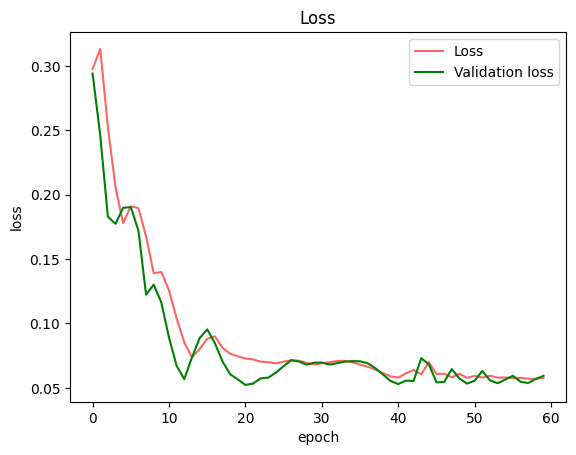

step 1, accuracy_train:0.3125, loss: 0.3011167695508251
step 2, accuracy_train:0.19375, loss: 0.3161494318167515
step 3, accuracy_train:0.43125, loss: 0.2515318429545827
step 4, accuracy_train:0.5, loss: 0.20251419930047732
step 5, accuracy_train:0.58125, loss: 0.17581014111762275
step 6, accuracy_train:0.5, loss: 0.18796390861490891
step 7, accuracy_train:0.63125, loss: 0.17011404870016722
step 8, accuracy_train:0.71875, loss: 0.1365987655712162
step 9, accuracy_train:0.675, loss: 0.1287159721195558
step 10, accuracy_train:0.7625, loss: 0.10612843295863478
step 11, accuracy_train:0.81875, loss: 0.093178754318256
step 12, accuracy_train:0.83125, loss: 0.08205597046353046
step 13, accuracy_train:0.83125, loss: 0.07994203762911804
step 14, accuracy_train:0.85, loss: 0.08200013247477853
step 15, accuracy_train:0.84375, loss: 0.08517082375533666
step 16, accuracy_train:0.84375, loss: 0.08672564306821887
step 17, accuracy_train:0.8625, loss: 0.07755328295654779
step 18, accuracy_train:0.868

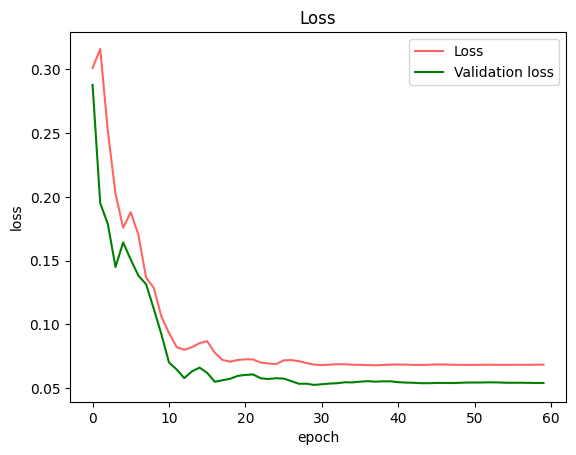

step 1, accuracy_train:0.2875, loss: 0.30048160108805194
step 2, accuracy_train:0.26875, loss: 0.29275494227045923
step 3, accuracy_train:0.4, loss: 0.2812321295899626
step 4, accuracy_train:0.53125, loss: 0.21122571181375233
step 5, accuracy_train:0.59375, loss: 0.1719961111022256
step 6, accuracy_train:0.65, loss: 0.1432079224943183
step 7, accuracy_train:0.775, loss: 0.10611896268037598
step 8, accuracy_train:0.86875, loss: 0.08812904656727158
step 9, accuracy_train:0.7875, loss: 0.09651107887817387
step 10, accuracy_train:0.7625, loss: 0.10914418088339581
step 11, accuracy_train:0.8125, loss: 0.09343623145358818
step 12, accuracy_train:0.80625, loss: 0.08043299320094213
step 13, accuracy_train:0.84375, loss: 0.07706091142092679
step 14, accuracy_train:0.84375, loss: 0.07713835432747414
step 15, accuracy_train:0.85, loss: 0.07459287786483546
step 16, accuracy_train:0.88125, loss: 0.07286027089915409
step 17, accuracy_train:0.89375, loss: 0.07220208518300622
step 18, accuracy_train:0

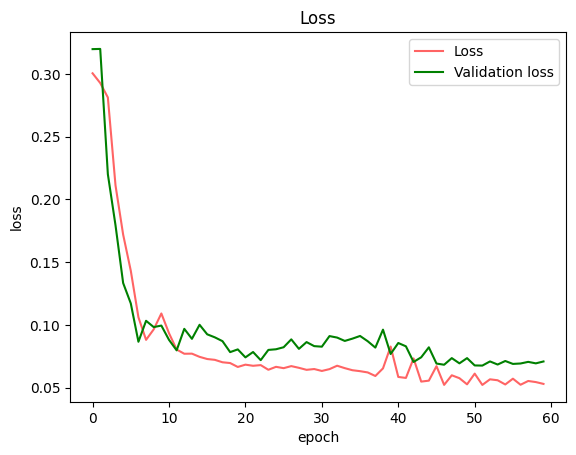

step 1, accuracy_train:0.28125, loss: 0.3040622293500149
step 2, accuracy_train:0.34375, loss: 0.2758593278030569
step 3, accuracy_train:0.4125, loss: 0.24003624434457244
step 4, accuracy_train:0.5125, loss: 0.18942834265627978
step 5, accuracy_train:0.58125, loss: 0.15416901385771478
step 6, accuracy_train:0.69375, loss: 0.13098735390856514
step 7, accuracy_train:0.6375, loss: 0.1416366678439456
step 8, accuracy_train:0.725, loss: 0.11619440858433741
step 9, accuracy_train:0.7875, loss: 0.09953716539594346
step 10, accuracy_train:0.8125, loss: 0.08072024145666507
step 11, accuracy_train:0.84375, loss: 0.08169062388012867
step 12, accuracy_train:0.84375, loss: 0.08649560207069022
step 13, accuracy_train:0.8875, loss: 0.07576259731167276
step 14, accuracy_train:0.85, loss: 0.07532000485822951
step 15, accuracy_train:0.85625, loss: 0.06679157498329857
step 16, accuracy_train:0.88125, loss: 0.06933469290862945
step 17, accuracy_train:0.86875, loss: 0.0661683323954432
step 18, accuracy_tra

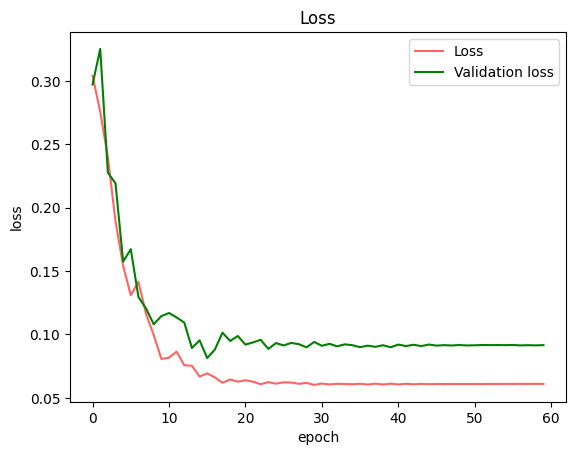

cv_time ：37.909763 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.375, loss: 0.29668244532265725
step 2, accuracy_train:0.13125, loss: 0.31861605423783046
step 3, accuracy_train:0.14375, loss: 0.28929373392265906
step 4, accuracy_train:0.45, loss: 0.2467747215226285
step 5, accuracy_train:0.375, loss: 0.26788449531517616
step 6, accuracy_train:0.475, loss: 0.21758121025935961
step 7, accuracy_train:0.56875, loss: 0.17511066206791295
step 8, accuracy_train:0.4875, loss: 0.18722619272957114
step 9, accuracy_train:0.46875, loss: 0.18835618408744506
step 10, accuracy_train:0.6125, loss: 0.1721545754916719
step 11, accuracy_train:0.59375, loss: 0.17895024048477387
step 12, accuracy_train:0.5625, loss: 0.18277820466210548
step 13, accuracy_train:0.63125, loss: 0.15530034601086493
step 14, accuracy_train:0.71875, loss: 0.13602409600640653
step 15, accuracy_train:0.65625, loss: 0.142705926016602
step 16, accuracy_train:0.7, loss: 0.1306769033546364
step 17, ac

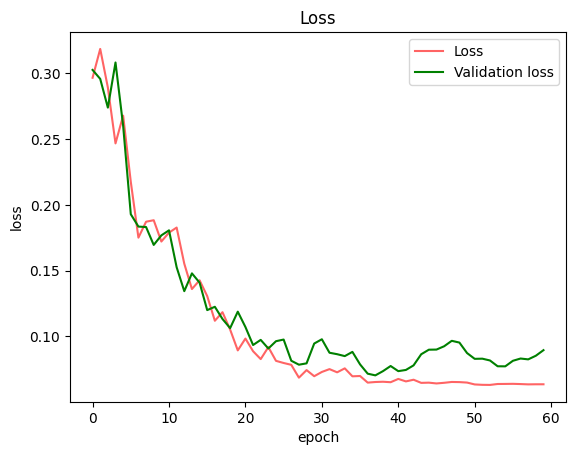

step 1, accuracy_train:0.38125, loss: 0.2960440939324984
step 2, accuracy_train:0.1375, loss: 0.3145956369060944
step 3, accuracy_train:0.14375, loss: 0.29175157562603854
step 4, accuracy_train:0.45, loss: 0.25710912688016485
step 5, accuracy_train:0.4125, loss: 0.2679747247577619
step 6, accuracy_train:0.525, loss: 0.21776030361704582
step 7, accuracy_train:0.525, loss: 0.19227239480397273
step 8, accuracy_train:0.43125, loss: 0.19528226594513357
step 9, accuracy_train:0.575, loss: 0.1739897806879511
step 10, accuracy_train:0.53125, loss: 0.19260258972733554
step 11, accuracy_train:0.50625, loss: 0.2124034038698145
step 12, accuracy_train:0.55625, loss: 0.19610559463703137
step 13, accuracy_train:0.6, loss: 0.18541232329636656
step 14, accuracy_train:0.5625, loss: 0.180183847651094
step 15, accuracy_train:0.7125, loss: 0.15175689097814749
step 16, accuracy_train:0.70625, loss: 0.1253909730504598
step 17, accuracy_train:0.7125, loss: 0.11882779274524641
step 18, accuracy_train:0.74375,

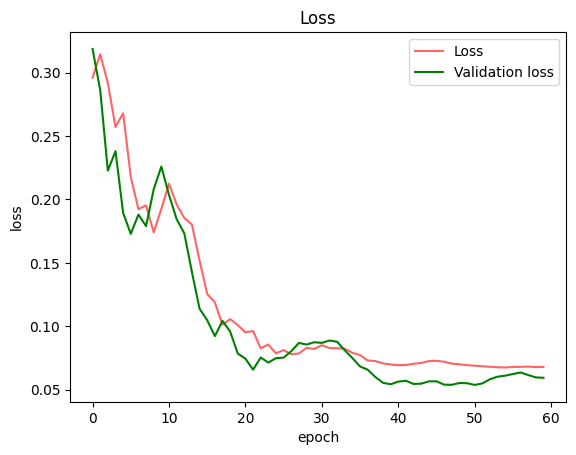

step 1, accuracy_train:0.36875, loss: 0.300575846729817
step 2, accuracy_train:0.15, loss: 0.31424367739749415
step 3, accuracy_train:0.1375, loss: 0.2933309485085472
step 4, accuracy_train:0.41875, loss: 0.268661535490638
step 5, accuracy_train:0.4, loss: 0.2697490503680526
step 6, accuracy_train:0.5, loss: 0.21166798411723553
step 7, accuracy_train:0.525, loss: 0.1906489837066602
step 8, accuracy_train:0.44375, loss: 0.19488091052648146
step 9, accuracy_train:0.6, loss: 0.17287493506516394
step 10, accuracy_train:0.60625, loss: 0.16948719919093
step 11, accuracy_train:0.59375, loss: 0.17194779967638554
step 12, accuracy_train:0.675, loss: 0.1529844988098033
step 13, accuracy_train:0.69375, loss: 0.1456080312398508
step 14, accuracy_train:0.65625, loss: 0.14590285949261958
step 15, accuracy_train:0.68125, loss: 0.1324200001508322
step 16, accuracy_train:0.7, loss: 0.12547960028858782
step 17, accuracy_train:0.725, loss: 0.11445458742260009
step 18, accuracy_train:0.81875, loss: 0.0941

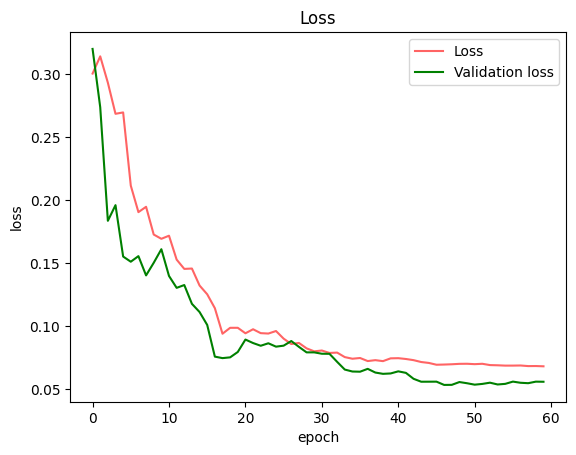

step 1, accuracy_train:0.3625, loss: 0.29366190787709656
step 2, accuracy_train:0.14375, loss: 0.3134834430561384
step 3, accuracy_train:0.14375, loss: 0.30390402031692954
step 4, accuracy_train:0.4375, loss: 0.2555616069524101
step 5, accuracy_train:0.425, loss: 0.27886925306523347
step 6, accuracy_train:0.5125, loss: 0.243939795429998
step 7, accuracy_train:0.54375, loss: 0.20098301353691703
step 8, accuracy_train:0.48125, loss: 0.1986887829862426
step 9, accuracy_train:0.53125, loss: 0.18307493314973802
step 10, accuracy_train:0.5375, loss: 0.18033844528444143
step 11, accuracy_train:0.49375, loss: 0.21290421354546077
step 12, accuracy_train:0.53125, loss: 0.20976269329679625
step 13, accuracy_train:0.675, loss: 0.1977141558169814
step 14, accuracy_train:0.5625, loss: 0.19820500603747682
step 15, accuracy_train:0.65625, loss: 0.17359504867374018
step 16, accuracy_train:0.73125, loss: 0.1423935009862147
step 17, accuracy_train:0.65625, loss: 0.1310338990772971
step 18, accuracy_train

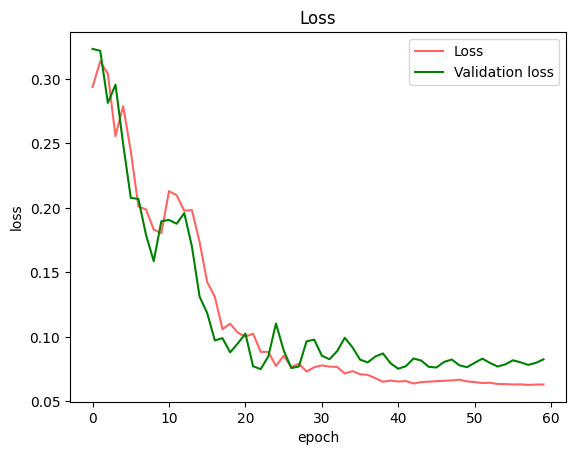

step 1, accuracy_train:0.3875, loss: 0.29220393015009605
step 2, accuracy_train:0.1375, loss: 0.3161689151235572
step 3, accuracy_train:0.15, loss: 0.28978955415171564
step 4, accuracy_train:0.5, loss: 0.2351942436850597
step 5, accuracy_train:0.45625, loss: 0.26087336530165833
step 6, accuracy_train:0.55, loss: 0.22072822210258472
step 7, accuracy_train:0.53125, loss: 0.18962034044374632
step 8, accuracy_train:0.49375, loss: 0.18852907001985458
step 9, accuracy_train:0.54375, loss: 0.16757347387025234
step 10, accuracy_train:0.58125, loss: 0.17640962916281763
step 11, accuracy_train:0.5375, loss: 0.20383892186691088
step 12, accuracy_train:0.60625, loss: 0.1902142628496062
step 13, accuracy_train:0.7, loss: 0.17386878959467894
step 14, accuracy_train:0.70625, loss: 0.1696112446575001
step 15, accuracy_train:0.78125, loss: 0.13985398144385167
step 16, accuracy_train:0.76875, loss: 0.11292950898735135
step 17, accuracy_train:0.75, loss: 0.11258159980098942
step 18, accuracy_train:0.775,

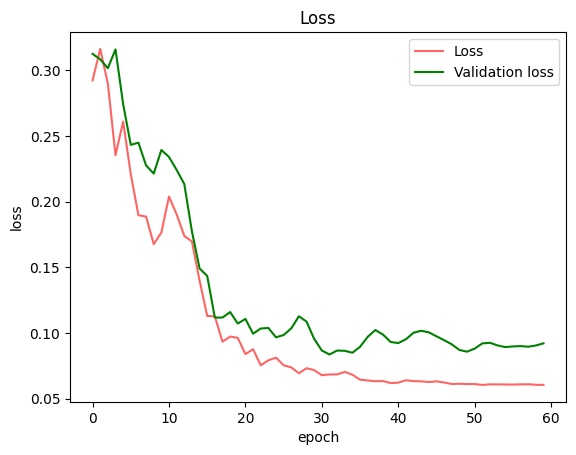

cv_time ：17.876061 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.2375, loss: 0.33005513798981717
step 2, accuracy_train:0.4125, loss: 0.22357245248543833
step 3, accuracy_train:0.65, loss: 0.15327987989859682
step 4, accuracy_train:0.63125, loss: 0.16082292120014596
step 5, accuracy_train:0.66875, loss: 0.14759047405473302
step 6, accuracy_train:0.65, loss: 0.13978763115207793
step 7, accuracy_train:0.66875, loss: 0.14228111422793102
step 8, accuracy_train:0.64375, loss: 0.1331344467573849
step 9, accuracy_train:0.74375, loss: 0.1064686736387008
step 10, accuracy_train:0.74375, loss: 0.10870540788831004
step 11, accuracy_train:0.75, loss: 0.10493758634787259
step 12, accuracy_train:0.7625, loss: 0.10264154964846234
step 13, accuracy_train:0.78125, loss: 0.10192975905365252
step 14, accuracy_train:0.7875, loss: 0.09913626096917846
step 15, accuracy_train:0.7625, loss: 0.10287175915498355
step 16, accuracy_train:0.79375, loss: 0.09798929760028906
step 1

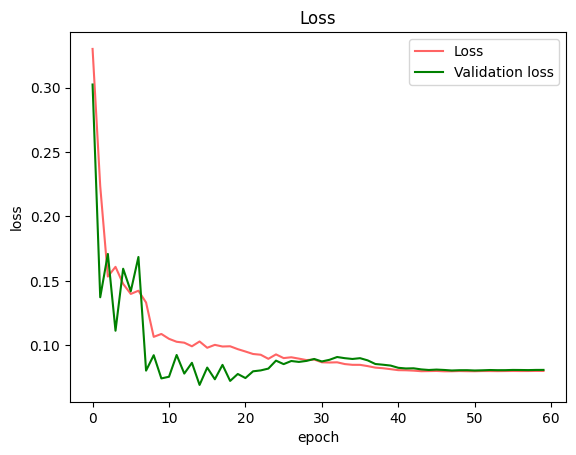

step 1, accuracy_train:0.25, loss: 0.3063534609687979
step 2, accuracy_train:0.3875, loss: 0.26253421861617965
step 3, accuracy_train:0.35, loss: 0.25202072346681614
step 4, accuracy_train:0.6375, loss: 0.17665273869155118
step 5, accuracy_train:0.75, loss: 0.12468124955811383
step 6, accuracy_train:0.64375, loss: 0.15485624039623552
step 7, accuracy_train:0.775, loss: 0.10603668458882247
step 8, accuracy_train:0.7625, loss: 0.10445002207981853
step 9, accuracy_train:0.76875, loss: 0.11913984366316205
step 10, accuracy_train:0.76875, loss: 0.108200303557762
step 11, accuracy_train:0.79375, loss: 0.10034502066141651
step 12, accuracy_train:0.75625, loss: 0.10062380808910805
step 13, accuracy_train:0.83125, loss: 0.09877736470166058
step 14, accuracy_train:0.8125, loss: 0.09666911233260382
step 15, accuracy_train:0.8, loss: 0.0947059987836063
step 16, accuracy_train:0.8125, loss: 0.09119114883911017
step 17, accuracy_train:0.8375, loss: 0.09280294943724547
step 18, accuracy_train:0.81875

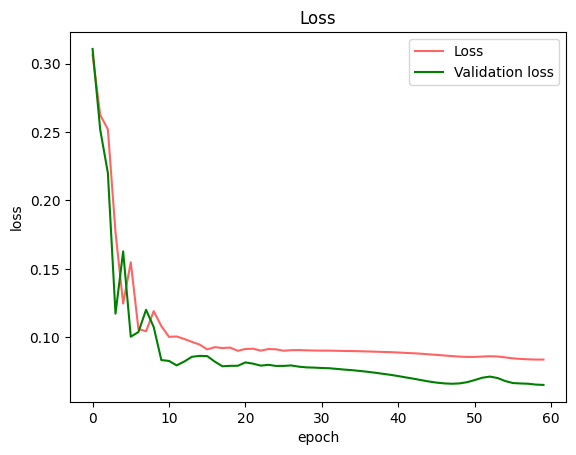

step 1, accuracy_train:0.20625, loss: 0.3265464072432038
step 2, accuracy_train:0.4, loss: 0.2585755787657718
step 3, accuracy_train:0.475, loss: 0.19908734125124294
step 4, accuracy_train:0.45, loss: 0.22054868091959684
step 5, accuracy_train:0.59375, loss: 0.15424042305922264
step 6, accuracy_train:0.63125, loss: 0.13834336897914548
step 7, accuracy_train:0.65, loss: 0.14236582224578165
step 8, accuracy_train:0.65, loss: 0.12701102784376
step 9, accuracy_train:0.71875, loss: 0.12820766822920265
step 10, accuracy_train:0.6375, loss: 0.1301947360540654
step 11, accuracy_train:0.675, loss: 0.12327708151067346
step 12, accuracy_train:0.69375, loss: 0.12110980368005808
step 13, accuracy_train:0.6875, loss: 0.11919653052487678
step 14, accuracy_train:0.68125, loss: 0.12258074920075743
step 15, accuracy_train:0.7, loss: 0.12090097190666363
step 16, accuracy_train:0.65625, loss: 0.1181797931288327
step 17, accuracy_train:0.6875, loss: 0.11805837171279623
step 18, accuracy_train:0.7, loss: 0.

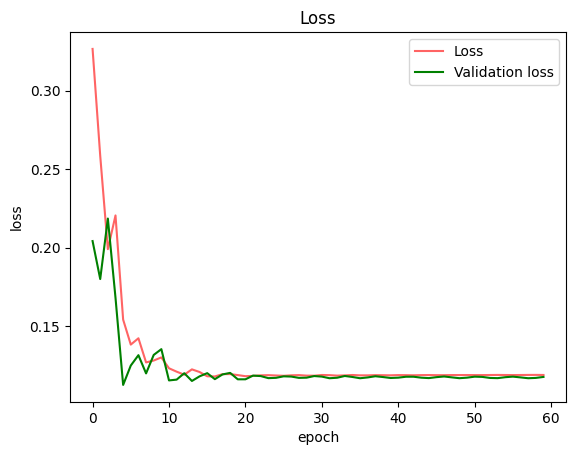

step 1, accuracy_train:0.21875, loss: 0.32849484347060315
step 2, accuracy_train:0.5375, loss: 0.2385563194004845
step 3, accuracy_train:0.46875, loss: 0.23591994895260737
step 4, accuracy_train:0.66875, loss: 0.19765268765779404
step 5, accuracy_train:0.65, loss: 0.14535219091114376
step 6, accuracy_train:0.675, loss: 0.12554812177243302
step 7, accuracy_train:0.7625, loss: 0.1166239304680726
step 8, accuracy_train:0.7375, loss: 0.11866925847348644
step 9, accuracy_train:0.8, loss: 0.1096096667879631
step 10, accuracy_train:0.775, loss: 0.11400826806247544
step 11, accuracy_train:0.75625, loss: 0.10298896630109364
step 12, accuracy_train:0.8125, loss: 0.09919458904366991
step 13, accuracy_train:0.8125, loss: 0.1029362200154257
step 14, accuracy_train:0.7875, loss: 0.09497474353709529
step 15, accuracy_train:0.79375, loss: 0.09705808399712657
step 16, accuracy_train:0.8125, loss: 0.09233356724892666
step 17, accuracy_train:0.80625, loss: 0.09323402148870544
step 18, accuracy_train:0.79

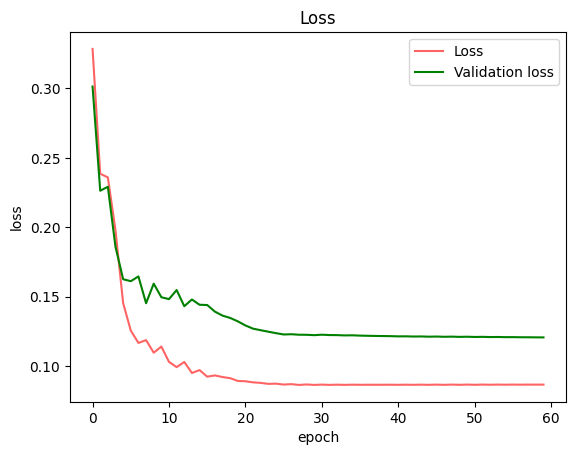

step 1, accuracy_train:0.2375, loss: 0.28644089377023885
step 2, accuracy_train:0.50625, loss: 0.2089256092134002
step 3, accuracy_train:0.51875, loss: 0.20734498976773194
step 4, accuracy_train:0.55625, loss: 0.18840646309066578
step 5, accuracy_train:0.5875, loss: 0.1614189979198939
step 6, accuracy_train:0.60625, loss: 0.13418690906267552
step 7, accuracy_train:0.73125, loss: 0.11952956130114264
step 8, accuracy_train:0.775, loss: 0.09318307090177896
step 9, accuracy_train:0.8375, loss: 0.0729371762826933
step 10, accuracy_train:0.8625, loss: 0.07404821235794581
step 11, accuracy_train:0.8625, loss: 0.06970894339658942
step 12, accuracy_train:0.86875, loss: 0.07028077953939947
step 13, accuracy_train:0.88125, loss: 0.0658882727057363
step 14, accuracy_train:0.88125, loss: 0.0639384199668769
step 15, accuracy_train:0.89375, loss: 0.06597496638013406
step 16, accuracy_train:0.85625, loss: 0.0688638989094229
step 17, accuracy_train:0.8625, loss: 0.06930697960120341
step 18, accuracy_tr

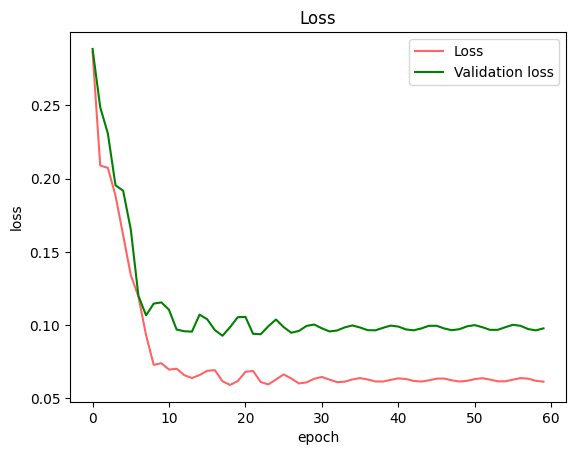

cv_time ：35.874116 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.31875, loss: 0.298002052766619
step 2, accuracy_train:0.16875, loss: 0.3163905972184019
step 3, accuracy_train:0.4625, loss: 0.25709872043047816
step 4, accuracy_train:0.55625, loss: 0.18885476003647544
step 5, accuracy_train:0.59375, loss: 0.17305700254631556
step 6, accuracy_train:0.55625, loss: 0.1752302663771962
step 7, accuracy_train:0.56875, loss: 0.1664777881485177
step 8, accuracy_train:0.7375, loss: 0.1384341343482887
step 9, accuracy_train:0.74375, loss: 0.11444502300228168
step 10, accuracy_train:0.7875, loss: 0.09897040230318492
step 11, accuracy_train:0.80625, loss: 0.09728284980502169
step 12, accuracy_train:0.83125, loss: 0.08814586543934205
step 13, accuracy_train:0.84375, loss: 0.08340595205072551
step 14, accuracy_train:0.825, loss: 0.07653315006062292
step 15, accuracy_train:0.85, loss: 0.07676871553524205
step 16, accuracy_train:0.88125, loss: 0.07836185

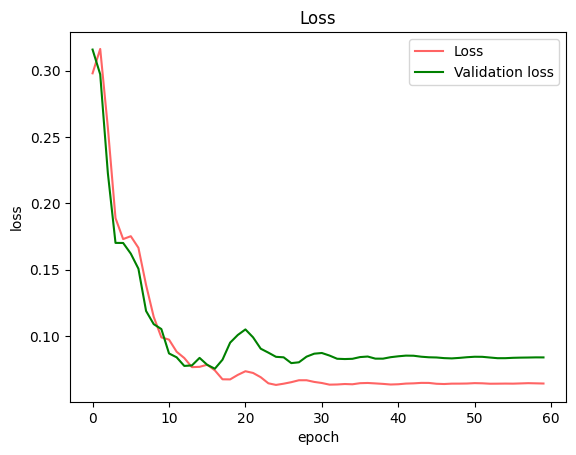

step 1, accuracy_train:0.325, loss: 0.2974913673683319
step 2, accuracy_train:0.20625, loss: 0.31317396718329643
step 3, accuracy_train:0.44375, loss: 0.25258390869395964
step 4, accuracy_train:0.45625, loss: 0.20588701706356327
step 5, accuracy_train:0.55625, loss: 0.17798382397612406
step 6, accuracy_train:0.5, loss: 0.19097620451997335
step 7, accuracy_train:0.4875, loss: 0.18958872231730267
step 8, accuracy_train:0.60625, loss: 0.16766444216770088
step 9, accuracy_train:0.6875, loss: 0.13912822730070717
step 10, accuracy_train:0.6625, loss: 0.13991668493477113
step 11, accuracy_train:0.71875, loss: 0.12562855186215105
step 12, accuracy_train:0.75, loss: 0.10387361434827838
step 13, accuracy_train:0.86875, loss: 0.0851989959105696
step 14, accuracy_train:0.85625, loss: 0.0737309459961221
step 15, accuracy_train:0.83125, loss: 0.080141264557921
step 16, accuracy_train:0.85, loss: 0.08809664611605694
step 17, accuracy_train:0.81875, loss: 0.09010128624847943
step 18, accuracy_train:0.

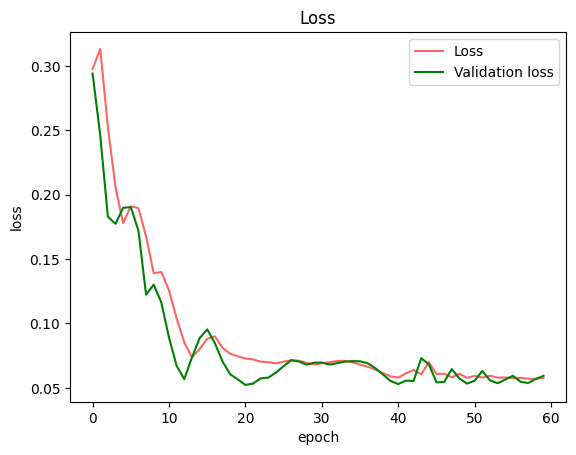

step 1, accuracy_train:0.3125, loss: 0.3011167695508251
step 2, accuracy_train:0.19375, loss: 0.3161494318167515
step 3, accuracy_train:0.43125, loss: 0.2515318429545827
step 4, accuracy_train:0.5, loss: 0.20251419930047732
step 5, accuracy_train:0.58125, loss: 0.17581014111762275
step 6, accuracy_train:0.5, loss: 0.18796390861490891
step 7, accuracy_train:0.63125, loss: 0.17011404870016722
step 8, accuracy_train:0.71875, loss: 0.1365987655712162
step 9, accuracy_train:0.675, loss: 0.1287159721195558
step 10, accuracy_train:0.7625, loss: 0.10612843295863478
step 11, accuracy_train:0.81875, loss: 0.093178754318256
step 12, accuracy_train:0.83125, loss: 0.08205597046353046
step 13, accuracy_train:0.83125, loss: 0.07994203762911804
step 14, accuracy_train:0.85, loss: 0.08200013247477853
step 15, accuracy_train:0.84375, loss: 0.08517082375533666
step 16, accuracy_train:0.84375, loss: 0.08672564306821887
step 17, accuracy_train:0.8625, loss: 0.07755328295654779
step 18, accuracy_train:0.868

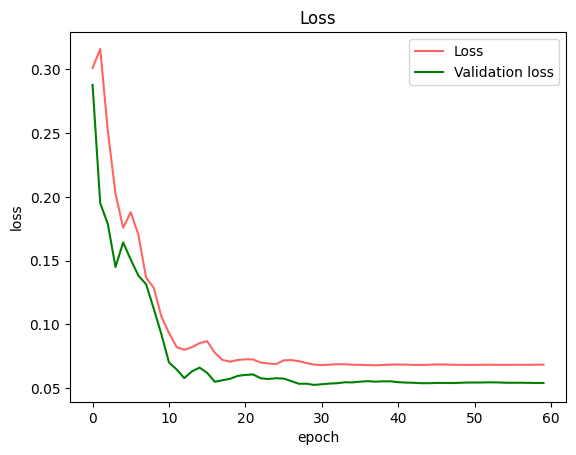

step 1, accuracy_train:0.2875, loss: 0.30048160108805194
step 2, accuracy_train:0.26875, loss: 0.29275494227045923
step 3, accuracy_train:0.4, loss: 0.2812321295899626
step 4, accuracy_train:0.53125, loss: 0.21122571181375233
step 5, accuracy_train:0.59375, loss: 0.1719961111022256
step 6, accuracy_train:0.65, loss: 0.1432079224943183
step 7, accuracy_train:0.775, loss: 0.10611896268037598
step 8, accuracy_train:0.86875, loss: 0.08812904656727158
step 9, accuracy_train:0.7875, loss: 0.09651107887817387
step 10, accuracy_train:0.7625, loss: 0.10914418088339581
step 11, accuracy_train:0.8125, loss: 0.09343623145358818
step 12, accuracy_train:0.80625, loss: 0.08043299320094213
step 13, accuracy_train:0.84375, loss: 0.07706091142092679
step 14, accuracy_train:0.84375, loss: 0.07713835432747414
step 15, accuracy_train:0.85, loss: 0.07459287786483546
step 16, accuracy_train:0.88125, loss: 0.07286027089915409
step 17, accuracy_train:0.89375, loss: 0.07220208518300622
step 18, accuracy_train:0

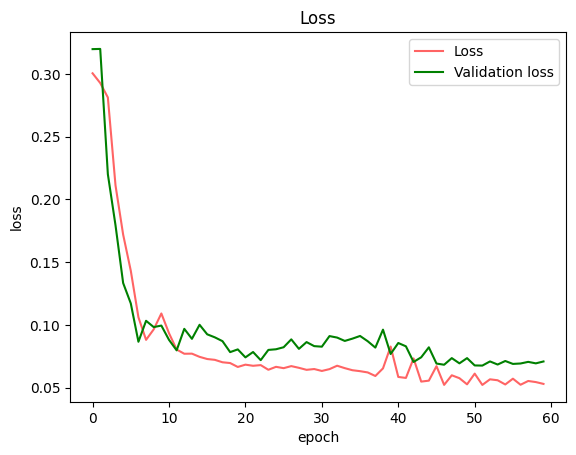

step 1, accuracy_train:0.28125, loss: 0.3040622293500149
step 2, accuracy_train:0.34375, loss: 0.2758593278030569
step 3, accuracy_train:0.4125, loss: 0.24003624434457244
step 4, accuracy_train:0.5125, loss: 0.18942834265627978
step 5, accuracy_train:0.58125, loss: 0.15416901385771478
step 6, accuracy_train:0.69375, loss: 0.13098735390856514
step 7, accuracy_train:0.6375, loss: 0.1416366678439456
step 8, accuracy_train:0.725, loss: 0.11619440858433741
step 9, accuracy_train:0.7875, loss: 0.09953716539594346
step 10, accuracy_train:0.8125, loss: 0.08072024145666507
step 11, accuracy_train:0.84375, loss: 0.08169062388012867
step 12, accuracy_train:0.84375, loss: 0.08649560207069022
step 13, accuracy_train:0.8875, loss: 0.07576259731167276
step 14, accuracy_train:0.85, loss: 0.07532000485822951
step 15, accuracy_train:0.85625, loss: 0.06679157498329857
step 16, accuracy_train:0.88125, loss: 0.06933469290862945
step 17, accuracy_train:0.86875, loss: 0.0661683323954432
step 18, accuracy_tra

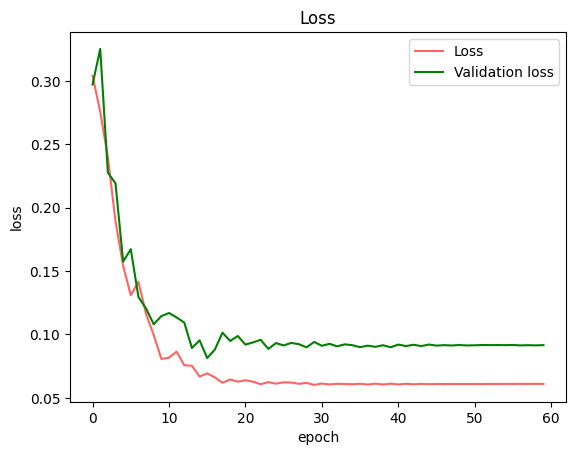

cv_time ：36.169586 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.375, loss: 0.29668244532265725
step 2, accuracy_train:0.13125, loss: 0.31861605423783046
step 3, accuracy_train:0.14375, loss: 0.28929373392265906
step 4, accuracy_train:0.45, loss: 0.2467747215226285
step 5, accuracy_train:0.375, loss: 0.26788449531517616
step 6, accuracy_train:0.475, loss: 0.21758121025935961
step 7, accuracy_train:0.56875, loss: 0.17511066206791295
step 8, accuracy_train:0.4875, loss: 0.18722619272957114
step 9, accuracy_train:0.46875, loss: 0.18835618408744506
step 10, accuracy_train:0.6125, loss: 0.1721545754916719
step 11, accuracy_train:0.59375, loss: 0.17895024048477387
step 12, accuracy_train:0.5625, loss: 0.18277820466210548
step 13, accuracy_train:0.63125, loss: 0.15530034601086493
step 14, accuracy_train:0.71875, loss: 0.13602409600640653
step 15, accuracy_train:0.65625, loss: 0.142705926016602
step 16, accuracy_train:0.7, loss: 0.1306769033546

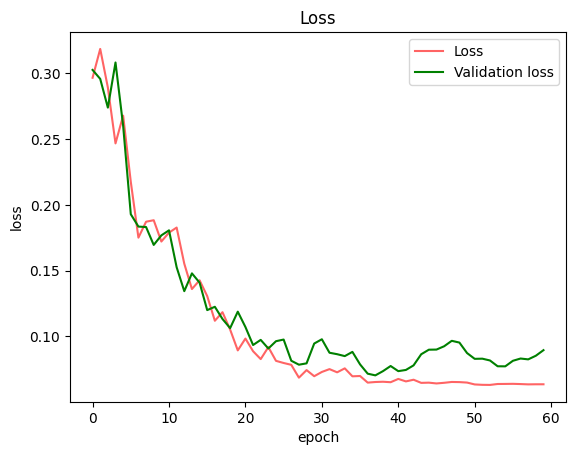

step 1, accuracy_train:0.38125, loss: 0.2960440939324984
step 2, accuracy_train:0.1375, loss: 0.3145956369060944
step 3, accuracy_train:0.14375, loss: 0.29175157562603854
step 4, accuracy_train:0.45, loss: 0.25710912688016485
step 5, accuracy_train:0.4125, loss: 0.2679747247577619
step 6, accuracy_train:0.525, loss: 0.21776030361704582
step 7, accuracy_train:0.525, loss: 0.19227239480397273
step 8, accuracy_train:0.43125, loss: 0.19528226594513357
step 9, accuracy_train:0.575, loss: 0.1739897806879511
step 10, accuracy_train:0.53125, loss: 0.19260258972733554
step 11, accuracy_train:0.50625, loss: 0.2124034038698145
step 12, accuracy_train:0.55625, loss: 0.19610559463703137
step 13, accuracy_train:0.6, loss: 0.18541232329636656
step 14, accuracy_train:0.5625, loss: 0.180183847651094
step 15, accuracy_train:0.7125, loss: 0.15175689097814749
step 16, accuracy_train:0.70625, loss: 0.1253909730504598
step 17, accuracy_train:0.7125, loss: 0.11882779274524641
step 18, accuracy_train:0.74375,

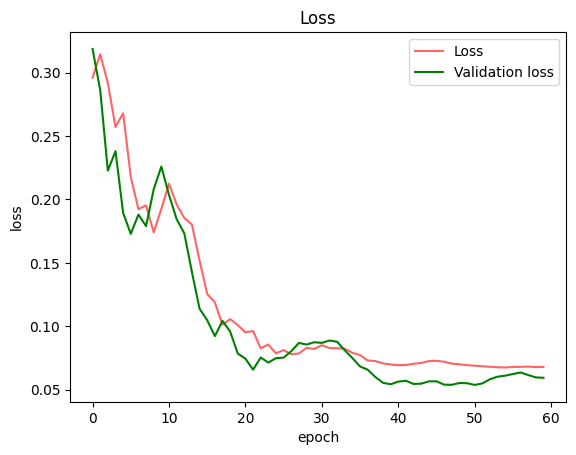

step 1, accuracy_train:0.36875, loss: 0.300575846729817
step 2, accuracy_train:0.15, loss: 0.31424367739749415
step 3, accuracy_train:0.1375, loss: 0.2933309485085472
step 4, accuracy_train:0.41875, loss: 0.268661535490638
step 5, accuracy_train:0.4, loss: 0.2697490503680526
step 6, accuracy_train:0.5, loss: 0.21166798411723553
step 7, accuracy_train:0.525, loss: 0.1906489837066602
step 8, accuracy_train:0.44375, loss: 0.19488091052648146
step 9, accuracy_train:0.6, loss: 0.17287493506516394
step 10, accuracy_train:0.60625, loss: 0.16948719919093
step 11, accuracy_train:0.59375, loss: 0.17194779967638554
step 12, accuracy_train:0.675, loss: 0.1529844988098033
step 13, accuracy_train:0.69375, loss: 0.1456080312398508
step 14, accuracy_train:0.65625, loss: 0.14590285949261958
step 15, accuracy_train:0.68125, loss: 0.1324200001508322
step 16, accuracy_train:0.7, loss: 0.12547960028858782
step 17, accuracy_train:0.725, loss: 0.11445458742260009
step 18, accuracy_train:0.81875, loss: 0.0941

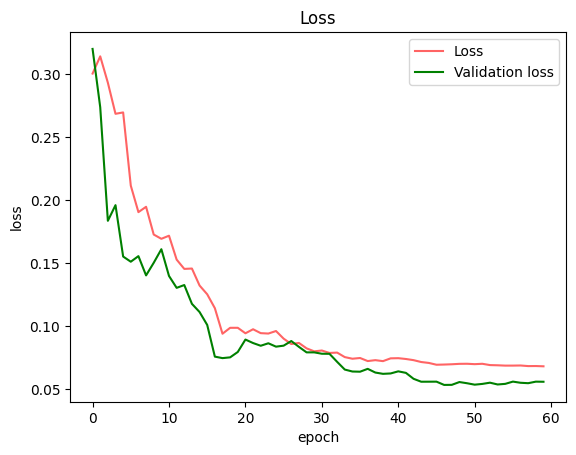

step 1, accuracy_train:0.3625, loss: 0.29366190787709656
step 2, accuracy_train:0.14375, loss: 0.3134834430561384
step 3, accuracy_train:0.14375, loss: 0.30390402031692954
step 4, accuracy_train:0.4375, loss: 0.2555616069524101
step 5, accuracy_train:0.425, loss: 0.27886925306523347
step 6, accuracy_train:0.5125, loss: 0.243939795429998
step 7, accuracy_train:0.54375, loss: 0.20098301353691703
step 8, accuracy_train:0.48125, loss: 0.1986887829862426
step 9, accuracy_train:0.53125, loss: 0.18307493314973802
step 10, accuracy_train:0.5375, loss: 0.18033844528444143
step 11, accuracy_train:0.49375, loss: 0.21290421354546077
step 12, accuracy_train:0.53125, loss: 0.20976269329679625
step 13, accuracy_train:0.675, loss: 0.1977141558169814
step 14, accuracy_train:0.5625, loss: 0.19820500603747682
step 15, accuracy_train:0.65625, loss: 0.17359504867374018
step 16, accuracy_train:0.73125, loss: 0.1423935009862147
step 17, accuracy_train:0.65625, loss: 0.1310338990772971
step 18, accuracy_train

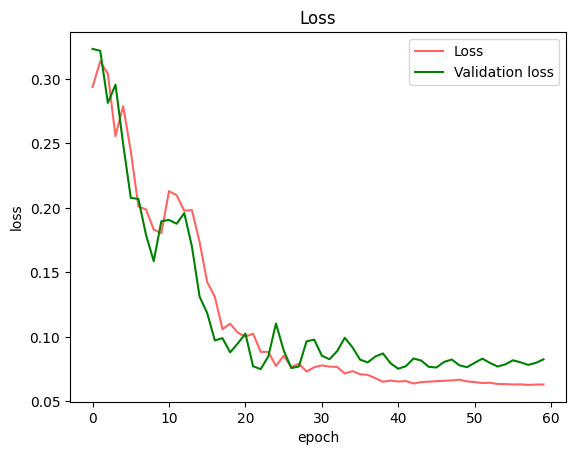

step 1, accuracy_train:0.3875, loss: 0.29220393015009605
step 2, accuracy_train:0.1375, loss: 0.3161689151235572
step 3, accuracy_train:0.15, loss: 0.28978955415171564
step 4, accuracy_train:0.5, loss: 0.2351942436850597
step 5, accuracy_train:0.45625, loss: 0.26087336530165833
step 6, accuracy_train:0.55, loss: 0.22072822210258472
step 7, accuracy_train:0.53125, loss: 0.18962034044374632
step 8, accuracy_train:0.49375, loss: 0.18852907001985458
step 9, accuracy_train:0.54375, loss: 0.16757347387025234
step 10, accuracy_train:0.58125, loss: 0.17640962916281763
step 11, accuracy_train:0.5375, loss: 0.20383892186691088
step 12, accuracy_train:0.60625, loss: 0.1902142628496062
step 13, accuracy_train:0.7, loss: 0.17386878959467894
step 14, accuracy_train:0.70625, loss: 0.1696112446575001
step 15, accuracy_train:0.78125, loss: 0.13985398144385167
step 16, accuracy_train:0.76875, loss: 0.11292950898735135
step 17, accuracy_train:0.75, loss: 0.11258159980098942
step 18, accuracy_train:0.775,

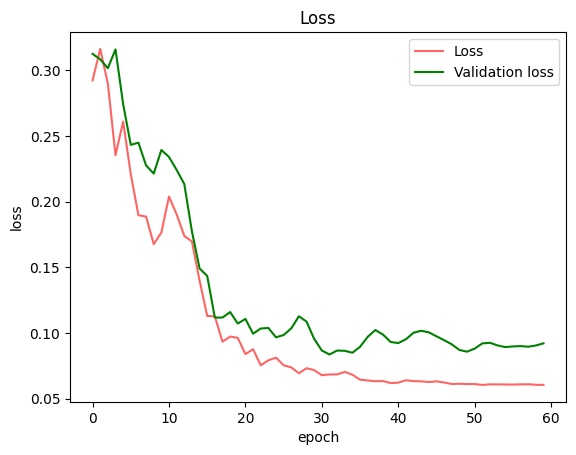

cv_time ：18.132911 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


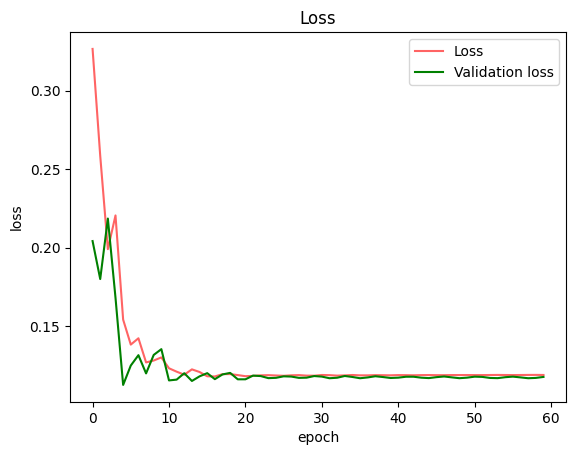

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.40625, loss: 0.34578228446325043
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.64375, loss: 0.16828318060097602
step 3, accuracy_train:0.6875, loss: 0.2026640437595552
step 4, accuracy_train:0.5875, loss: 0.1992981727802175
step 5, accuracy_train:0.6875, loss: 0.1467678691307876
step 6, accuracy_train:0.75, loss: 0.11992308296586555
step 7, accuracy_train:0.75, loss: 0.12306222280636644
step 8, accuracy_train:0.71875, loss: 0.11187182398421446
step 9, accuracy_train:0.825, loss: 0.10399681966890581
step 10, accuracy_train:0.8375, loss: 0.10297258664487996
step 11, accuracy_train:0.85625, loss: 0.09392105935707541
step 12, accuracy_train:0.84375, loss: 0.09027023159002712
step 13, accuracy_train:0.80625, loss: 0.09206278874

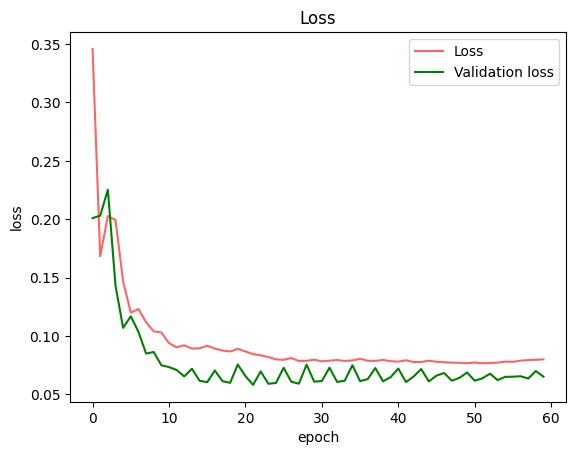

step 1, accuracy_train:0.4625, loss: 0.33446795291014675
step 2, accuracy_train:0.59375, loss: 0.16390166991705857
step 3, accuracy_train:0.5625, loss: 0.2245956677978238
step 4, accuracy_train:0.53125, loss: 0.20644852019794863
step 5, accuracy_train:0.68125, loss: 0.1489486220901802
step 6, accuracy_train:0.64375, loss: 0.147861552644793
step 7, accuracy_train:0.70625, loss: 0.1386664227275572
step 8, accuracy_train:0.64375, loss: 0.126100090558065
step 9, accuracy_train:0.725, loss: 0.1116168500713251
step 10, accuracy_train:0.725, loss: 0.11181032589919772
step 11, accuracy_train:0.79375, loss: 0.10588406238077636
step 12, accuracy_train:0.8125, loss: 0.09761532664811935
step 13, accuracy_train:0.7625, loss: 0.10372022573798576
step 14, accuracy_train:0.8125, loss: 0.09772551672238547
step 15, accuracy_train:0.84375, loss: 0.09640085007864366
step 16, accuracy_train:0.825, loss: 0.0992052466515227
step 17, accuracy_train:0.75, loss: 0.10230508247565864
step 18, accuracy_train:0.825

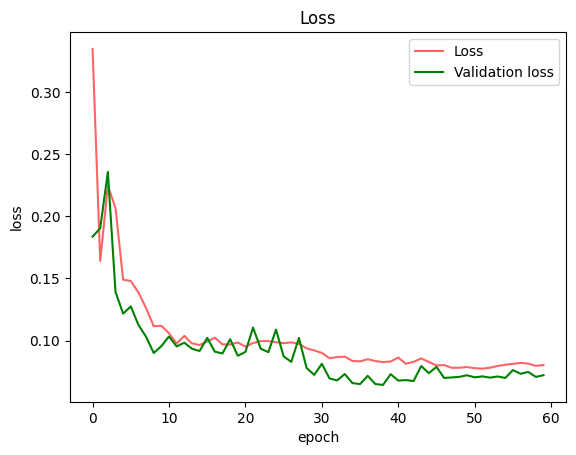

step 1, accuracy_train:0.4375, loss: 0.33039178094643407
step 2, accuracy_train:0.6125, loss: 0.1470378529837697
step 3, accuracy_train:0.64375, loss: 0.201686951078521
step 4, accuracy_train:0.7375, loss: 0.1852409398521503
step 5, accuracy_train:0.74375, loss: 0.11376081070224005
step 6, accuracy_train:0.725, loss: 0.11059263930276096
step 7, accuracy_train:0.725, loss: 0.10252829677395905
step 8, accuracy_train:0.75, loss: 0.09429281469285408
step 9, accuracy_train:0.825, loss: 0.09091531054244467
step 10, accuracy_train:0.83125, loss: 0.08995002849240036
step 11, accuracy_train:0.8125, loss: 0.08612904740269728
step 12, accuracy_train:0.825, loss: 0.08098683665418502
step 13, accuracy_train:0.8625, loss: 0.07872884699353769
step 14, accuracy_train:0.83125, loss: 0.0780935887937667
step 15, accuracy_train:0.83125, loss: 0.07681657781570497
step 16, accuracy_train:0.8125, loss: 0.0806195311699428
step 17, accuracy_train:0.84375, loss: 0.0830397558613022
step 18, accuracy_train:0.85, 

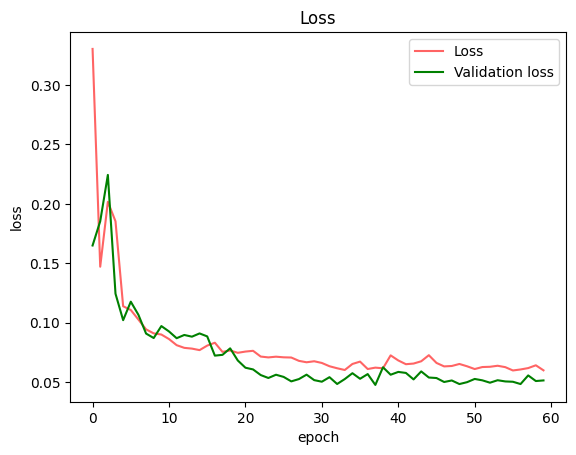

step 1, accuracy_train:0.4375, loss: 0.33046344324345894
step 2, accuracy_train:0.64375, loss: 0.1525980722745734
step 3, accuracy_train:0.66875, loss: 0.20419816349242897
step 4, accuracy_train:0.64375, loss: 0.17336380681041072
step 5, accuracy_train:0.75625, loss: 0.11462950014825958
step 6, accuracy_train:0.76875, loss: 0.10895767643602004
step 7, accuracy_train:0.7875, loss: 0.09843737585884109
step 8, accuracy_train:0.8, loss: 0.09138295324844109
step 9, accuracy_train:0.79375, loss: 0.09787884250120635
step 10, accuracy_train:0.81875, loss: 0.0962771361187498
step 11, accuracy_train:0.825, loss: 0.08756396671469388
step 12, accuracy_train:0.83125, loss: 0.08221337422141828
step 13, accuracy_train:0.86875, loss: 0.08101004677330548
step 14, accuracy_train:0.85625, loss: 0.07851311406400807
step 15, accuracy_train:0.84375, loss: 0.07906737246044045
step 16, accuracy_train:0.8625, loss: 0.07684402959084069
step 17, accuracy_train:0.81875, loss: 0.07804957666494075
step 18, accuracy

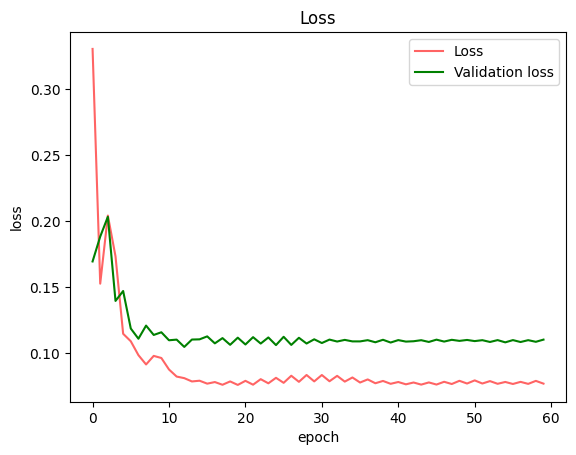

step 1, accuracy_train:0.45625, loss: 0.32737466215776323
step 2, accuracy_train:0.675, loss: 0.14606403590425868
step 3, accuracy_train:0.725, loss: 0.1653810278787195
step 4, accuracy_train:0.725, loss: 0.1847337304200211
step 5, accuracy_train:0.76875, loss: 0.1154674893709566
step 6, accuracy_train:0.825, loss: 0.08574677002898072
step 7, accuracy_train:0.83125, loss: 0.07412175798239022
step 8, accuracy_train:0.80625, loss: 0.07435883957815394
step 9, accuracy_train:0.8125, loss: 0.06591737783655535
step 10, accuracy_train:0.8625, loss: 0.07060430679894944
step 11, accuracy_train:0.8375, loss: 0.06903878690936716
step 12, accuracy_train:0.8625, loss: 0.061927541561433014
step 13, accuracy_train:0.86875, loss: 0.06143042232525056
step 14, accuracy_train:0.85, loss: 0.06154761726764456
step 15, accuracy_train:0.8375, loss: 0.059349138360734466
step 16, accuracy_train:0.8375, loss: 0.06198803302571222
step 17, accuracy_train:0.875, loss: 0.05895372863087438
step 18, accuracy_train:0.

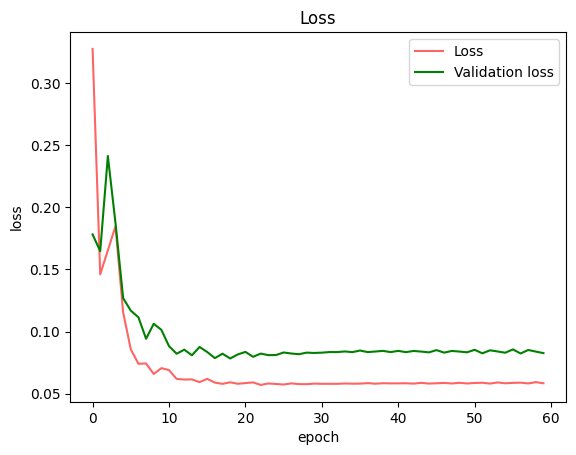

cv_time ：94.018903 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.44375, loss: 0.42718837033588686
step 2, accuracy_train:0.6125, loss: 0.2249562004118575
step 3, accuracy_train:0.675, loss: 0.14750703738661441
step 4, accuracy_train:0.7, loss: 0.12793360055090158
step 5, accuracy_train:0.73125, loss: 0.16383615171539062
step 6, accuracy_train:0.75625, loss: 0.19184554440888754
step 7, accuracy_train:0.8, loss: 0.1876539777821428
step 8, accuracy_train:0.79375, loss: 0.16514825983064674
step 9, accuracy_train:0.825, loss: 0.12734812184336858
step 10, accuracy_train:0.79375, loss: 0.10598246022648217
step 11, accuracy_train:0.83125, loss: 0.08876898254720693
step 12, accuracy_train:0.84375, loss: 0.09133667325090951
step 13, accuracy_train:0.825, loss: 0.08972340187563024
step 14, 

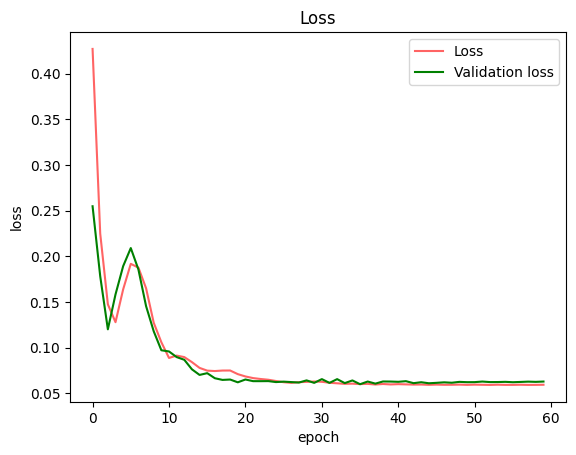

step 1, accuracy_train:0.4375, loss: 0.42778440148844704
step 2, accuracy_train:0.5875, loss: 0.22689638365753292
step 3, accuracy_train:0.625, loss: 0.1482683022276974
step 4, accuracy_train:0.6625, loss: 0.1325834961324647
step 5, accuracy_train:0.7125, loss: 0.15688593465713957
step 6, accuracy_train:0.7625, loss: 0.19058482922482578
step 7, accuracy_train:0.79375, loss: 0.17073717848766817
step 8, accuracy_train:0.8, loss: 0.14964660224958218
step 9, accuracy_train:0.81875, loss: 0.12013300734989202
step 10, accuracy_train:0.8, loss: 0.09835323227091305
step 11, accuracy_train:0.8, loss: 0.08970454303671865
step 12, accuracy_train:0.825, loss: 0.0871735000898442
step 13, accuracy_train:0.81875, loss: 0.08818215275770636
step 14, accuracy_train:0.8125, loss: 0.08300906040484263
step 15, accuracy_train:0.825, loss: 0.08066645655063996
step 16, accuracy_train:0.84375, loss: 0.07862241701999147
step 17, accuracy_train:0.8625, loss: 0.07888497822549174
step 18, accuracy_train:0.875, los

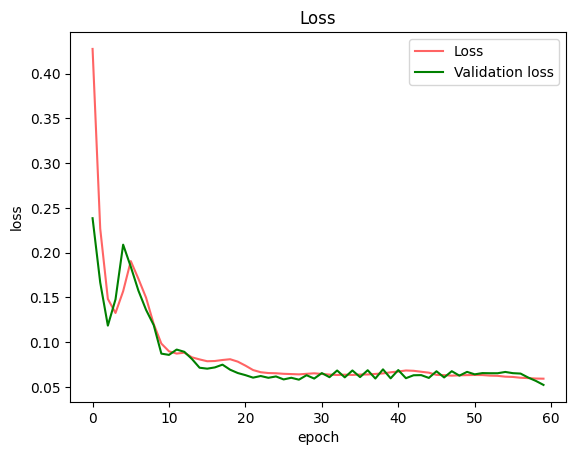

step 1, accuracy_train:0.4625, loss: 0.42659225988318805
step 2, accuracy_train:0.60625, loss: 0.22298133691615746
step 3, accuracy_train:0.6125, loss: 0.1544612684607633
step 4, accuracy_train:0.64375, loss: 0.1426119856936895
step 5, accuracy_train:0.69375, loss: 0.1668768314555223
step 6, accuracy_train:0.73125, loss: 0.199073527458677
step 7, accuracy_train:0.7875, loss: 0.18047596845493868
step 8, accuracy_train:0.79375, loss: 0.14983134423564473
step 9, accuracy_train:0.75, loss: 0.12636289926031685
step 10, accuracy_train:0.8, loss: 0.10289043521395948
step 11, accuracy_train:0.8, loss: 0.09078366566953558
step 12, accuracy_train:0.825, loss: 0.08753244798867152
step 13, accuracy_train:0.85625, loss: 0.08775751675103913
step 14, accuracy_train:0.84375, loss: 0.0803313268953263
step 15, accuracy_train:0.83125, loss: 0.07587270530931872
step 16, accuracy_train:0.8375, loss: 0.07355280260589922
step 17, accuracy_train:0.85625, loss: 0.06973399692515529
step 18, accuracy_train:0.868

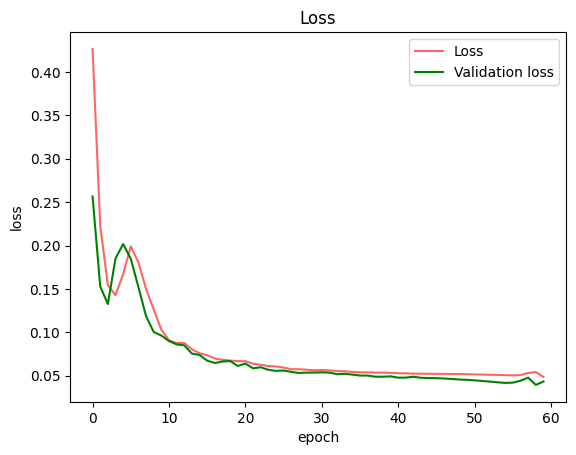

step 1, accuracy_train:0.46875, loss: 0.4276886885776394
step 2, accuracy_train:0.6125, loss: 0.22159674660119297
step 3, accuracy_train:0.675, loss: 0.1517520064543572
step 4, accuracy_train:0.7125, loss: 0.12312287238659148
step 5, accuracy_train:0.7375, loss: 0.16381057098896112
step 6, accuracy_train:0.8, loss: 0.1910172933544914
step 7, accuracy_train:0.75, loss: 0.18696985833176136
step 8, accuracy_train:0.825, loss: 0.15357247936423546
step 9, accuracy_train:0.86875, loss: 0.12469987383073175
step 10, accuracy_train:0.8125, loss: 0.10092518587036214
step 11, accuracy_train:0.84375, loss: 0.08791762985081722
step 12, accuracy_train:0.81875, loss: 0.09056794570543561
step 13, accuracy_train:0.84375, loss: 0.08761081843231602
step 14, accuracy_train:0.86875, loss: 0.08357004099919928
step 15, accuracy_train:0.86875, loss: 0.07888153851907406
step 16, accuracy_train:0.85, loss: 0.0780467829190006
step 17, accuracy_train:0.85, loss: 0.07598510850555915
step 18, accuracy_train:0.8625,

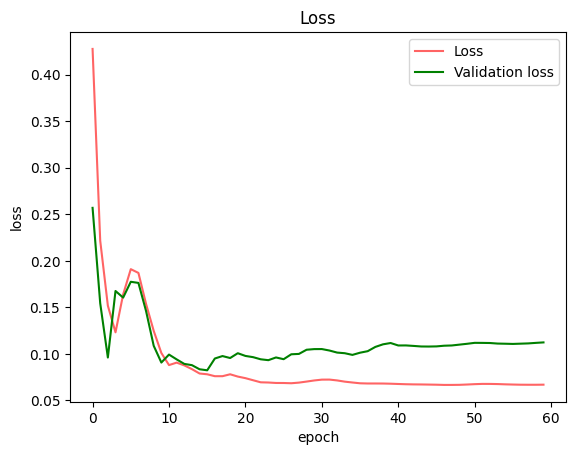

step 1, accuracy_train:0.43125, loss: 0.4309245157023407
step 2, accuracy_train:0.63125, loss: 0.21395298370500257
step 3, accuracy_train:0.70625, loss: 0.14372651290788258
step 4, accuracy_train:0.71875, loss: 0.12628921176845848
step 5, accuracy_train:0.73125, loss: 0.15454074833611653
step 6, accuracy_train:0.775, loss: 0.18525688897956027
step 7, accuracy_train:0.80625, loss: 0.19786173571626908
step 8, accuracy_train:0.80625, loss: 0.17099818175851292
step 9, accuracy_train:0.81875, loss: 0.15111843446983142
step 10, accuracy_train:0.81875, loss: 0.11541003573464109
step 11, accuracy_train:0.8625, loss: 0.08370670852182374
step 12, accuracy_train:0.83125, loss: 0.07417666816524487
step 13, accuracy_train:0.84375, loss: 0.07294352767211384
step 14, accuracy_train:0.84375, loss: 0.07390317169464106
step 15, accuracy_train:0.85625, loss: 0.071069820333624
step 16, accuracy_train:0.875, loss: 0.0677694096448081
step 17, accuracy_train:0.8625, loss: 0.06482098901165875
step 18, accurac

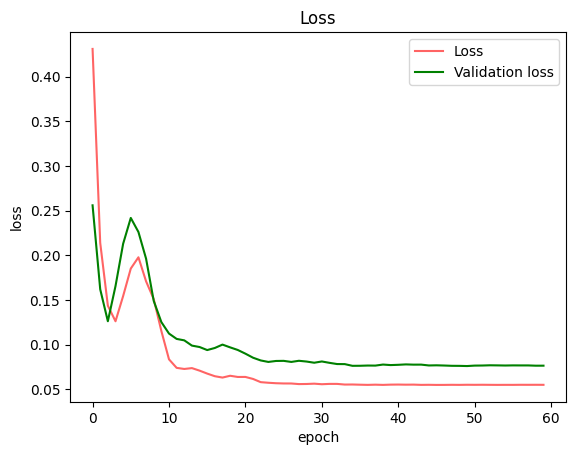

cv_time ：88.577112 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.55625, loss: 0.46404695634525694
step 2, accuracy_train:0.2125, loss: 0.39416298190705285
step 3, accuracy_train:0.6125, loss: 0.24933624138268287
step 4, accuracy_train:0.6625, loss: 0.19137277628416227
step 5, accuracy_train:0.63125, loss: 0.15749706412701747
step 6, accuracy_train:0.76875, loss: 0.12556500067381934
step 7, accuracy_train:0.78125, loss: 0.11053677897194901
step 8, accuracy_train:0.775, loss: 0.13248309613505502
step 9, accuracy_train:0.775, loss: 0.14742530615214644
step 10, accuracy_train:0.78125, loss: 0.15470454729099348
step 11, accuracy_train:0.7375, loss: 0.1809228500991401
step 12, accuracy_train:0.8, loss: 0.19566956300442234
step 13, accuracy_train:0.825, loss: 0.1983247462039456
step 14, accuracy_train:0.84375, loss: 0.17906953714190835
step 15, accuracy_train:0.8, loss: 0.16017860952950128
step 16, accuracy_train:0.7375, loss: 0.15003058759236892
step 17, ac

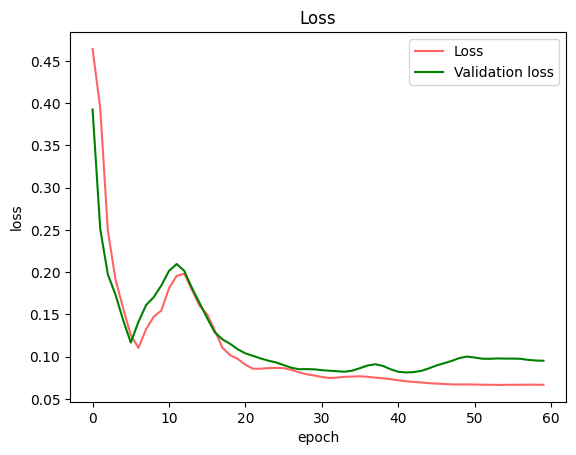

step 1, accuracy_train:0.55, loss: 0.4647921782121349
step 2, accuracy_train:0.23125, loss: 0.39402677241836814
step 3, accuracy_train:0.5625, loss: 0.2523255149558984
step 4, accuracy_train:0.64375, loss: 0.1933144603195133
step 5, accuracy_train:0.65625, loss: 0.16039164953641905
step 6, accuracy_train:0.76875, loss: 0.12490326361899502
step 7, accuracy_train:0.7125, loss: 0.11351619664421107
step 8, accuracy_train:0.70625, loss: 0.13422239594500943
step 9, accuracy_train:0.79375, loss: 0.14175000185995976
step 10, accuracy_train:0.83125, loss: 0.15616156210868926
step 11, accuracy_train:0.7125, loss: 0.18497072717145402
step 12, accuracy_train:0.78125, loss: 0.19112590357448322
step 13, accuracy_train:0.76875, loss: 0.18980388644421164
step 14, accuracy_train:0.7875, loss: 0.1861925646360834
step 15, accuracy_train:0.79375, loss: 0.1760028546833547
step 16, accuracy_train:0.8125, loss: 0.14935488086972173
step 17, accuracy_train:0.81875, loss: 0.13247113495571913
step 18, accuracy_t

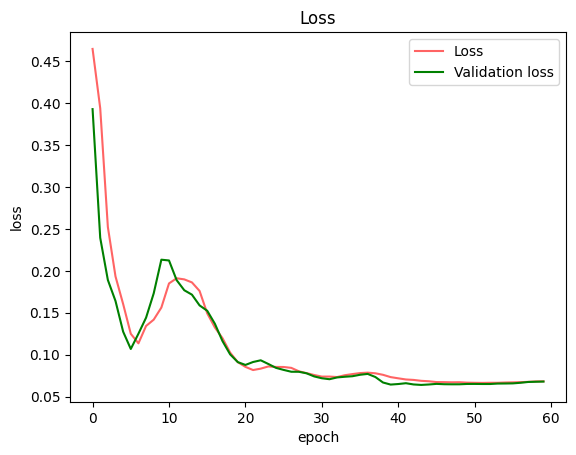

step 1, accuracy_train:0.575, loss: 0.46330182602866155
step 2, accuracy_train:0.21875, loss: 0.3939332554067816
step 3, accuracy_train:0.60625, loss: 0.2516922429722887
step 4, accuracy_train:0.66875, loss: 0.19038964686198
step 5, accuracy_train:0.65625, loss: 0.16195411192017584
step 6, accuracy_train:0.75625, loss: 0.1256053895004297
step 7, accuracy_train:0.78125, loss: 0.10651040053221064
step 8, accuracy_train:0.75625, loss: 0.13145924608335496
step 9, accuracy_train:0.73125, loss: 0.14584504081817515
step 10, accuracy_train:0.79375, loss: 0.15494408619819072
step 11, accuracy_train:0.79375, loss: 0.1701104870221809
step 12, accuracy_train:0.7875, loss: 0.1898330702660468
step 13, accuracy_train:0.75625, loss: 0.18987582356101151
step 14, accuracy_train:0.79375, loss: 0.16703553452244685
step 15, accuracy_train:0.74375, loss: 0.1498780941547999
step 16, accuracy_train:0.8, loss: 0.1337765328304105
step 17, accuracy_train:0.8125, loss: 0.12133349523819037
step 18, accuracy_train:

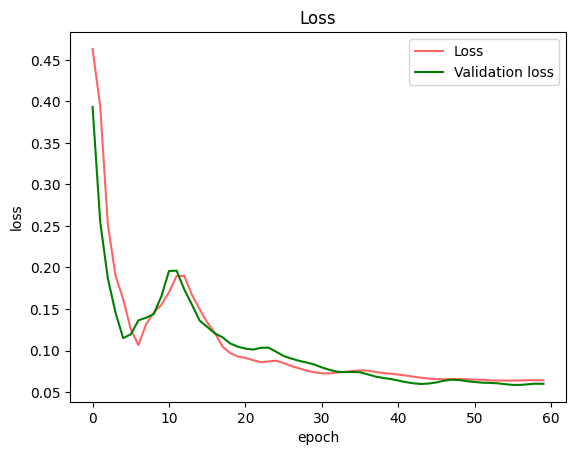

step 1, accuracy_train:0.5625, loss: 0.4650273546144238
step 2, accuracy_train:0.225, loss: 0.39225812703003915
step 3, accuracy_train:0.56875, loss: 0.25337452074843503
step 4, accuracy_train:0.65, loss: 0.19247838754965954
step 5, accuracy_train:0.675, loss: 0.16635985152047822
step 6, accuracy_train:0.7625, loss: 0.13445744302463813
step 7, accuracy_train:0.8375, loss: 0.1057472108758522
step 8, accuracy_train:0.83125, loss: 0.13415907419528908
step 9, accuracy_train:0.78125, loss: 0.15464228449122794
step 10, accuracy_train:0.8125, loss: 0.14724878177187772
step 11, accuracy_train:0.71875, loss: 0.17363371934704985
step 12, accuracy_train:0.7875, loss: 0.18348439281093154
step 13, accuracy_train:0.7875, loss: 0.18424476171127957
step 14, accuracy_train:0.75625, loss: 0.16789999887259666
step 15, accuracy_train:0.7875, loss: 0.1545219609998589
step 16, accuracy_train:0.75625, loss: 0.14202153180238875
step 17, accuracy_train:0.76875, loss: 0.12316768611994305
step 18, accuracy_train

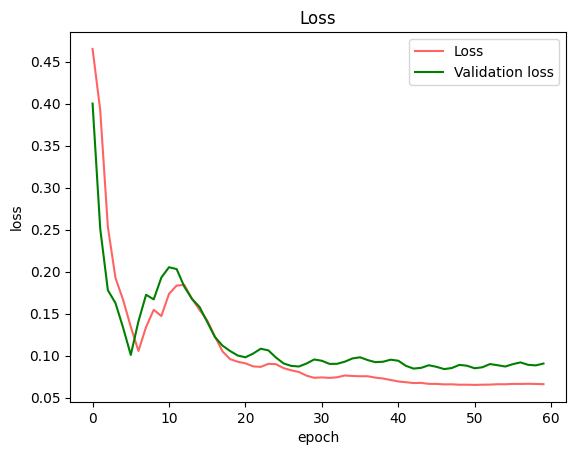

step 1, accuracy_train:0.55625, loss: 0.4641604203755734
step 2, accuracy_train:0.1875, loss: 0.3946849991638408
step 3, accuracy_train:0.6, loss: 0.24750004755805805
step 4, accuracy_train:0.6625, loss: 0.1919227283720378
step 5, accuracy_train:0.64375, loss: 0.1601705349994537
step 6, accuracy_train:0.7875, loss: 0.12223804906231912
step 7, accuracy_train:0.8625, loss: 0.10035634225762811
step 8, accuracy_train:0.81875, loss: 0.1343051815741049
step 9, accuracy_train:0.81875, loss: 0.1438958035871408
step 10, accuracy_train:0.88125, loss: 0.1419355581513441
step 11, accuracy_train:0.79375, loss: 0.17174584014812552
step 12, accuracy_train:0.79375, loss: 0.18108364449900852
step 13, accuracy_train:0.8625, loss: 0.1716242932789005
step 14, accuracy_train:0.84375, loss: 0.16029719191304068
step 15, accuracy_train:0.825, loss: 0.15182402231202557
step 16, accuracy_train:0.85, loss: 0.13350669266566775
step 17, accuracy_train:0.85, loss: 0.11685079334739588
step 18, accuracy_train:0.83125

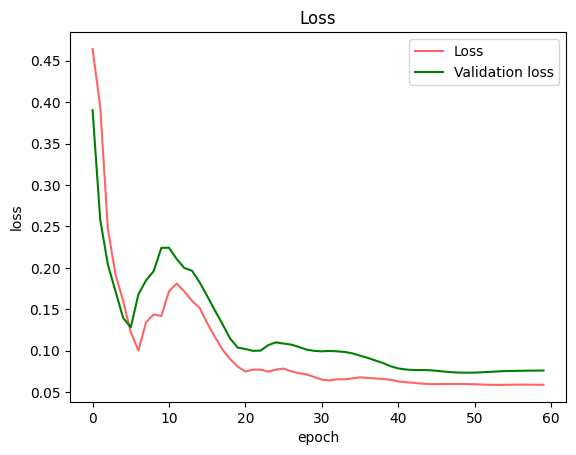

cv_time ：42.646769 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.40625, loss: 0.34578228446325043
step 2, accuracy_train:0.64375, loss: 0.16828318060097602
step 3, accuracy_train:0.6875, loss: 0.2026640437595552
step 4, accuracy_train:0.5875, loss: 0.1992981727802175
step 5, accuracy_train:0.6875, loss: 0.1467678691307876
step 6, accuracy_train:0.75, loss: 0.11992308296586555
step 7, accuracy_train:0.75, loss: 0.12306222280636644
step 8, accuracy_train:0.71875, loss: 0.11187182398421446
step 9, accuracy_train:0.825, loss: 0.10399681966890581
step 10, accuracy_train:0.8375, loss: 0.10297258664487996
step 11, accuracy_train:0.85625, loss: 0.09392105935707541
step 12, accuracy_train:0.84375, loss: 0.09027023159002712
step 13, accuracy_train:0.80625, loss: 0.09206278874048772
step 14, accuracy_train:0.8375, loss: 0.08924297421809047
step 15, accuracy_train:0.84375, loss: 0.08944298414345184
step 16, accuracy_train:0.78125, loss: 0.09164259351234466
step 1

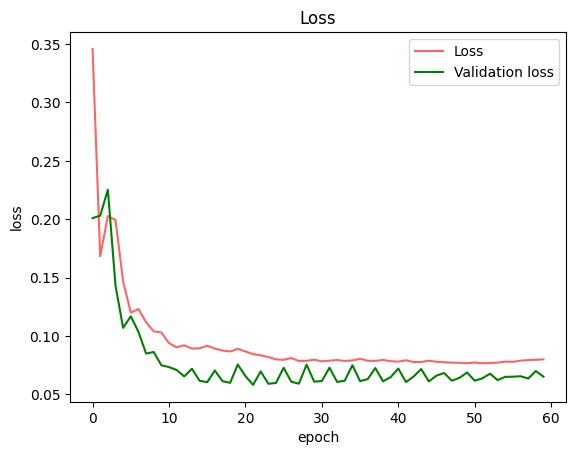

step 1, accuracy_train:0.4625, loss: 0.33446795291014675
step 2, accuracy_train:0.59375, loss: 0.16390166991705857
step 3, accuracy_train:0.5625, loss: 0.2245956677978238
step 4, accuracy_train:0.53125, loss: 0.20644852019794863
step 5, accuracy_train:0.68125, loss: 0.1489486220901802
step 6, accuracy_train:0.64375, loss: 0.147861552644793
step 7, accuracy_train:0.70625, loss: 0.1386664227275572
step 8, accuracy_train:0.64375, loss: 0.126100090558065
step 9, accuracy_train:0.725, loss: 0.1116168500713251
step 10, accuracy_train:0.725, loss: 0.11181032589919772
step 11, accuracy_train:0.79375, loss: 0.10588406238077636
step 12, accuracy_train:0.8125, loss: 0.09761532664811935
step 13, accuracy_train:0.7625, loss: 0.10372022573798576
step 14, accuracy_train:0.8125, loss: 0.09772551672238547
step 15, accuracy_train:0.84375, loss: 0.09640085007864366
step 16, accuracy_train:0.825, loss: 0.0992052466515227
step 17, accuracy_train:0.75, loss: 0.10230508247565864
step 18, accuracy_train:0.825

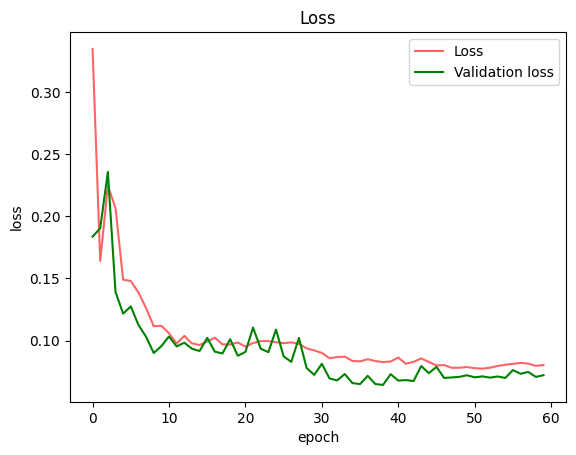

step 1, accuracy_train:0.4375, loss: 0.33039178094643407
step 2, accuracy_train:0.6125, loss: 0.1470378529837697
step 3, accuracy_train:0.64375, loss: 0.201686951078521
step 4, accuracy_train:0.7375, loss: 0.1852409398521503
step 5, accuracy_train:0.74375, loss: 0.11376081070224005
step 6, accuracy_train:0.725, loss: 0.11059263930276096
step 7, accuracy_train:0.725, loss: 0.10252829677395905
step 8, accuracy_train:0.75, loss: 0.09429281469285408
step 9, accuracy_train:0.825, loss: 0.09091531054244467
step 10, accuracy_train:0.83125, loss: 0.08995002849240036
step 11, accuracy_train:0.8125, loss: 0.08612904740269728
step 12, accuracy_train:0.825, loss: 0.08098683665418502
step 13, accuracy_train:0.8625, loss: 0.07872884699353769
step 14, accuracy_train:0.83125, loss: 0.0780935887937667
step 15, accuracy_train:0.83125, loss: 0.07681657781570497
step 16, accuracy_train:0.8125, loss: 0.0806195311699428
step 17, accuracy_train:0.84375, loss: 0.0830397558613022
step 18, accuracy_train:0.85, 

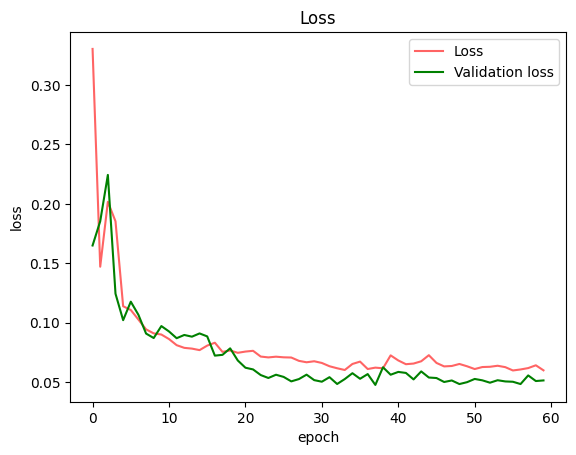

step 1, accuracy_train:0.4375, loss: 0.33046344324345894
step 2, accuracy_train:0.64375, loss: 0.1525980722745734
step 3, accuracy_train:0.66875, loss: 0.20419816349242897
step 4, accuracy_train:0.64375, loss: 0.17336380681041072
step 5, accuracy_train:0.75625, loss: 0.11462950014825958
step 6, accuracy_train:0.76875, loss: 0.10895767643602004
step 7, accuracy_train:0.7875, loss: 0.09843737585884109
step 8, accuracy_train:0.8, loss: 0.09138295324844109
step 9, accuracy_train:0.79375, loss: 0.09787884250120635
step 10, accuracy_train:0.81875, loss: 0.0962771361187498
step 11, accuracy_train:0.825, loss: 0.08756396671469388
step 12, accuracy_train:0.83125, loss: 0.08221337422141828
step 13, accuracy_train:0.86875, loss: 0.08101004677330548
step 14, accuracy_train:0.85625, loss: 0.07851311406400807
step 15, accuracy_train:0.84375, loss: 0.07906737246044045
step 16, accuracy_train:0.8625, loss: 0.07684402959084069
step 17, accuracy_train:0.81875, loss: 0.07804957666494075
step 18, accuracy

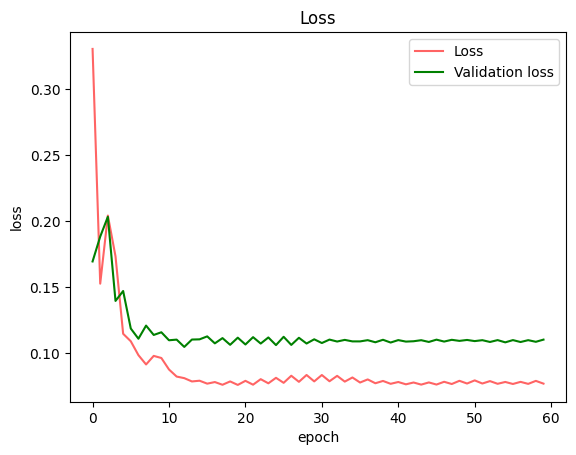

step 1, accuracy_train:0.45625, loss: 0.32737466215776323
step 2, accuracy_train:0.675, loss: 0.14606403590425868
step 3, accuracy_train:0.725, loss: 0.1653810278787195
step 4, accuracy_train:0.725, loss: 0.1847337304200211
step 5, accuracy_train:0.76875, loss: 0.1154674893709566
step 6, accuracy_train:0.825, loss: 0.08574677002898072
step 7, accuracy_train:0.83125, loss: 0.07412175798239022
step 8, accuracy_train:0.80625, loss: 0.07435883957815394
step 9, accuracy_train:0.8125, loss: 0.06591737783655535
step 10, accuracy_train:0.8625, loss: 0.07060430679894944
step 11, accuracy_train:0.8375, loss: 0.06903878690936716
step 12, accuracy_train:0.8625, loss: 0.061927541561433014
step 13, accuracy_train:0.86875, loss: 0.06143042232525056
step 14, accuracy_train:0.85, loss: 0.06154761726764456
step 15, accuracy_train:0.8375, loss: 0.059349138360734466
step 16, accuracy_train:0.8375, loss: 0.06198803302571222
step 17, accuracy_train:0.875, loss: 0.05895372863087438
step 18, accuracy_train:0.

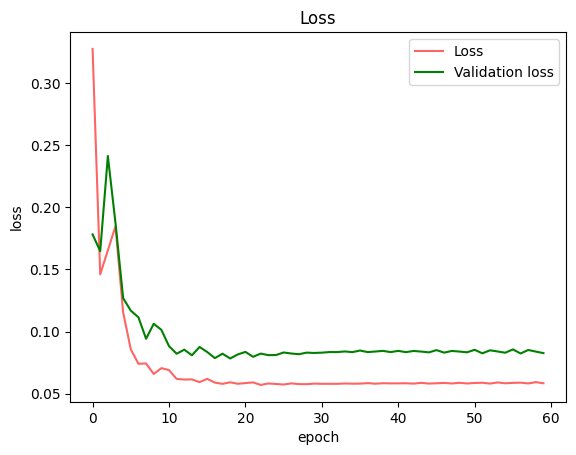

cv_time ：83.230986 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.44375, loss: 0.42718837033588686
step 2, accuracy_train:0.6125, loss: 0.2249562004118575
step 3, accuracy_train:0.675, loss: 0.14750703738661441
step 4, accuracy_train:0.7, loss: 0.12793360055090158
step 5, accuracy_train:0.73125, loss: 0.16383615171539062
step 6, accuracy_train:0.75625, loss: 0.19184554440888754
step 7, accuracy_train:0.8, loss: 0.1876539777821428
step 8, accuracy_train:0.79375, loss: 0.16514825983064674
step 9, accuracy_train:0.825, loss: 0.12734812184336858
step 10, accuracy_train:0.79375, loss: 0.10598246022648217
step 11, accuracy_train:0.83125, loss: 0.08876898254720693
step 12, accuracy_train:0.84375, loss: 0.09133667325090951
step 13, accuracy_train:0.825, loss: 0.08972340187563024
step 14, accuracy_train:0.84375, loss: 0.08420829277189826
step 15, accuracy_train:0.83125, loss: 0.07787850203925792
step 16, accuracy_train:0.83125, loss: 0.07488155631

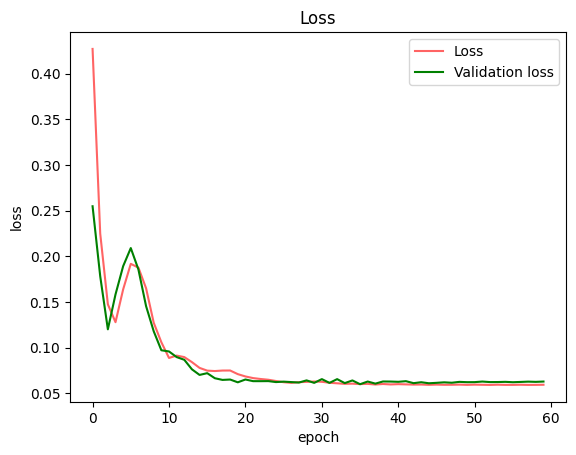

step 1, accuracy_train:0.4375, loss: 0.42778440148844704
step 2, accuracy_train:0.5875, loss: 0.22689638365753292
step 3, accuracy_train:0.625, loss: 0.1482683022276974
step 4, accuracy_train:0.6625, loss: 0.1325834961324647
step 5, accuracy_train:0.7125, loss: 0.15688593465713957
step 6, accuracy_train:0.7625, loss: 0.19058482922482578
step 7, accuracy_train:0.79375, loss: 0.17073717848766817
step 8, accuracy_train:0.8, loss: 0.14964660224958218
step 9, accuracy_train:0.81875, loss: 0.12013300734989202
step 10, accuracy_train:0.8, loss: 0.09835323227091305
step 11, accuracy_train:0.8, loss: 0.08970454303671865
step 12, accuracy_train:0.825, loss: 0.0871735000898442
step 13, accuracy_train:0.81875, loss: 0.08818215275770636
step 14, accuracy_train:0.8125, loss: 0.08300906040484263
step 15, accuracy_train:0.825, loss: 0.08066645655063996
step 16, accuracy_train:0.84375, loss: 0.07862241701999147
step 17, accuracy_train:0.8625, loss: 0.07888497822549174
step 18, accuracy_train:0.875, los

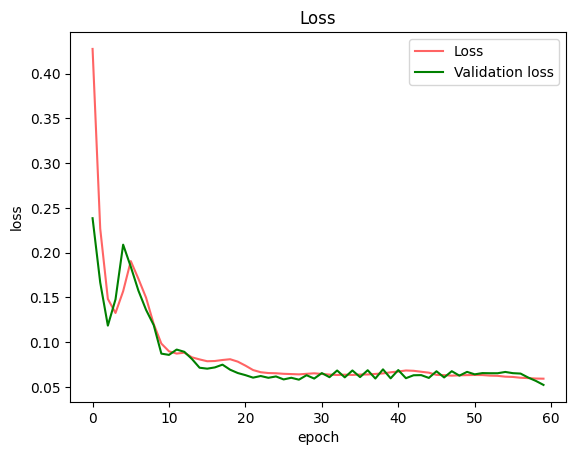

step 1, accuracy_train:0.4625, loss: 0.42659225988318805
step 2, accuracy_train:0.60625, loss: 0.22298133691615746
step 3, accuracy_train:0.6125, loss: 0.1544612684607633
step 4, accuracy_train:0.64375, loss: 0.1426119856936895
step 5, accuracy_train:0.69375, loss: 0.1668768314555223
step 6, accuracy_train:0.73125, loss: 0.199073527458677
step 7, accuracy_train:0.7875, loss: 0.18047596845493868
step 8, accuracy_train:0.79375, loss: 0.14983134423564473
step 9, accuracy_train:0.75, loss: 0.12636289926031685
step 10, accuracy_train:0.8, loss: 0.10289043521395948
step 11, accuracy_train:0.8, loss: 0.09078366566953558
step 12, accuracy_train:0.825, loss: 0.08753244798867152
step 13, accuracy_train:0.85625, loss: 0.08775751675103913
step 14, accuracy_train:0.84375, loss: 0.0803313268953263
step 15, accuracy_train:0.83125, loss: 0.07587270530931872
step 16, accuracy_train:0.8375, loss: 0.07355280260589922
step 17, accuracy_train:0.85625, loss: 0.06973399692515529
step 18, accuracy_train:0.868

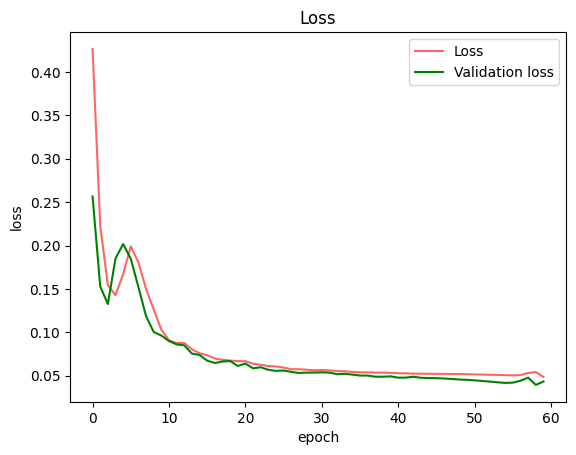

step 1, accuracy_train:0.46875, loss: 0.4276886885776394
step 2, accuracy_train:0.6125, loss: 0.22159674660119297
step 3, accuracy_train:0.675, loss: 0.1517520064543572
step 4, accuracy_train:0.7125, loss: 0.12312287238659148
step 5, accuracy_train:0.7375, loss: 0.16381057098896112
step 6, accuracy_train:0.8, loss: 0.1910172933544914
step 7, accuracy_train:0.75, loss: 0.18696985833176136
step 8, accuracy_train:0.825, loss: 0.15357247936423546
step 9, accuracy_train:0.86875, loss: 0.12469987383073175
step 10, accuracy_train:0.8125, loss: 0.10092518587036214
step 11, accuracy_train:0.84375, loss: 0.08791762985081722
step 12, accuracy_train:0.81875, loss: 0.09056794570543561
step 13, accuracy_train:0.84375, loss: 0.08761081843231602
step 14, accuracy_train:0.86875, loss: 0.08357004099919928
step 15, accuracy_train:0.86875, loss: 0.07888153851907406
step 16, accuracy_train:0.85, loss: 0.0780467829190006
step 17, accuracy_train:0.85, loss: 0.07598510850555915
step 18, accuracy_train:0.8625,

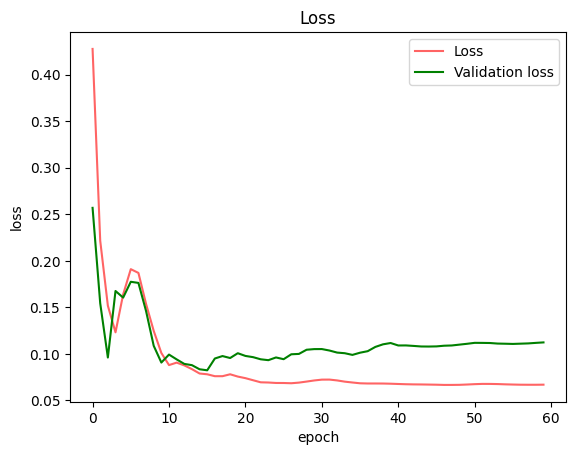

step 1, accuracy_train:0.43125, loss: 0.4309245157023407
step 2, accuracy_train:0.63125, loss: 0.21395298370500257
step 3, accuracy_train:0.70625, loss: 0.14372651290788258
step 4, accuracy_train:0.71875, loss: 0.12628921176845848
step 5, accuracy_train:0.73125, loss: 0.15454074833611653
step 6, accuracy_train:0.775, loss: 0.18525688897956027
step 7, accuracy_train:0.80625, loss: 0.19786173571626908
step 8, accuracy_train:0.80625, loss: 0.17099818175851292
step 9, accuracy_train:0.81875, loss: 0.15111843446983142
step 10, accuracy_train:0.81875, loss: 0.11541003573464109
step 11, accuracy_train:0.8625, loss: 0.08370670852182374
step 12, accuracy_train:0.83125, loss: 0.07417666816524487
step 13, accuracy_train:0.84375, loss: 0.07294352767211384
step 14, accuracy_train:0.84375, loss: 0.07390317169464106
step 15, accuracy_train:0.85625, loss: 0.071069820333624
step 16, accuracy_train:0.875, loss: 0.0677694096448081
step 17, accuracy_train:0.8625, loss: 0.06482098901165875
step 18, accurac

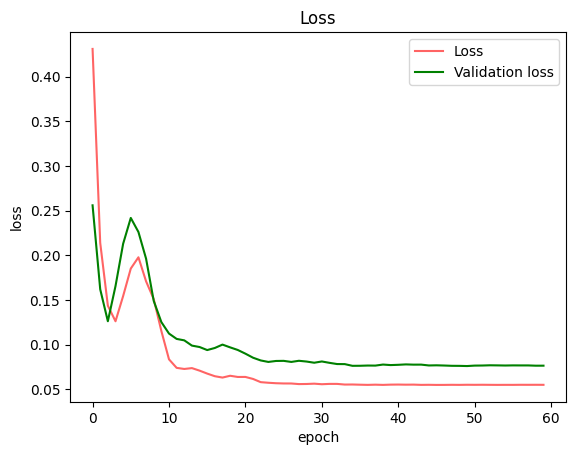

cv_time ：83.343450 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.55625, loss: 0.46404695634525694
step 2, accuracy_train:0.2125, loss: 0.39416298190705285
step 3, accuracy_train:0.6125, loss: 0.24933624138268287
step 4, accuracy_train:0.6625, loss: 0.19137277628416227
step 5, accuracy_train:0.63125, loss: 0.15749706412701747
step 6, accuracy_train:0.76875, loss: 0.12556500067381934
step 7, accuracy_train:0.78125, loss: 0.11053677897194901
step 8, accuracy_train:0.775, loss: 0.13248309613505502
step 9, accuracy_train:0.775, loss: 0.14742530615214644
step 10, accuracy_train:0.78125, loss: 0.15470454729099348
step 11, accuracy_train:0.7375, loss: 0.1809228500991401
step 12, accuracy_train:0.8, loss: 0.19566956300442234
step 13, accuracy_train:0.825, loss: 0.1983247462039456
step 14, accuracy_train:0.84375, loss: 0.17906953714190835
step 15, accuracy_train:0.8, loss: 0.16017860952950128
step 16, accuracy_train:0.7375, loss: 0.15003058759236

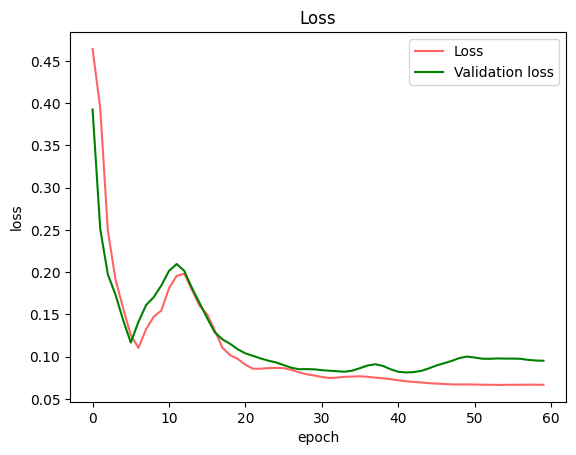

step 1, accuracy_train:0.55, loss: 0.4647921782121349
step 2, accuracy_train:0.23125, loss: 0.39402677241836814
step 3, accuracy_train:0.5625, loss: 0.2523255149558984
step 4, accuracy_train:0.64375, loss: 0.1933144603195133
step 5, accuracy_train:0.65625, loss: 0.16039164953641905
step 6, accuracy_train:0.76875, loss: 0.12490326361899502
step 7, accuracy_train:0.7125, loss: 0.11351619664421107
step 8, accuracy_train:0.70625, loss: 0.13422239594500943
step 9, accuracy_train:0.79375, loss: 0.14175000185995976
step 10, accuracy_train:0.83125, loss: 0.15616156210868926
step 11, accuracy_train:0.7125, loss: 0.18497072717145402
step 12, accuracy_train:0.78125, loss: 0.19112590357448322
step 13, accuracy_train:0.76875, loss: 0.18980388644421164
step 14, accuracy_train:0.7875, loss: 0.1861925646360834
step 15, accuracy_train:0.79375, loss: 0.1760028546833547
step 16, accuracy_train:0.8125, loss: 0.14935488086972173
step 17, accuracy_train:0.81875, loss: 0.13247113495571913
step 18, accuracy_t

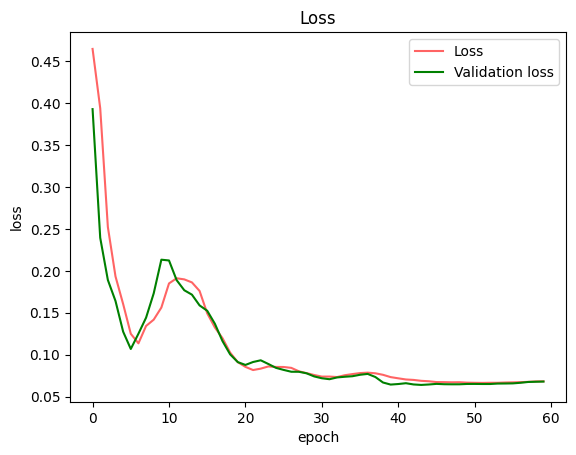

step 1, accuracy_train:0.575, loss: 0.46330182602866155
step 2, accuracy_train:0.21875, loss: 0.3939332554067816
step 3, accuracy_train:0.60625, loss: 0.2516922429722887
step 4, accuracy_train:0.66875, loss: 0.19038964686198
step 5, accuracy_train:0.65625, loss: 0.16195411192017584
step 6, accuracy_train:0.75625, loss: 0.1256053895004297
step 7, accuracy_train:0.78125, loss: 0.10651040053221064
step 8, accuracy_train:0.75625, loss: 0.13145924608335496
step 9, accuracy_train:0.73125, loss: 0.14584504081817515
step 10, accuracy_train:0.79375, loss: 0.15494408619819072
step 11, accuracy_train:0.79375, loss: 0.1701104870221809
step 12, accuracy_train:0.7875, loss: 0.1898330702660468
step 13, accuracy_train:0.75625, loss: 0.18987582356101151
step 14, accuracy_train:0.79375, loss: 0.16703553452244685
step 15, accuracy_train:0.74375, loss: 0.1498780941547999
step 16, accuracy_train:0.8, loss: 0.1337765328304105
step 17, accuracy_train:0.8125, loss: 0.12133349523819037
step 18, accuracy_train:

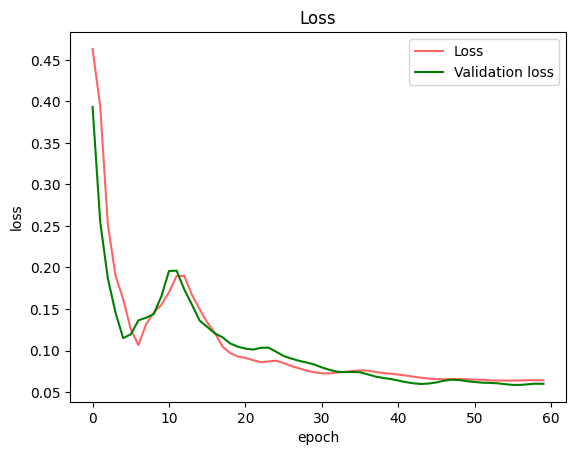

step 1, accuracy_train:0.5625, loss: 0.4650273546144238
step 2, accuracy_train:0.225, loss: 0.39225812703003915
step 3, accuracy_train:0.56875, loss: 0.25337452074843503
step 4, accuracy_train:0.65, loss: 0.19247838754965954
step 5, accuracy_train:0.675, loss: 0.16635985152047822
step 6, accuracy_train:0.7625, loss: 0.13445744302463813
step 7, accuracy_train:0.8375, loss: 0.1057472108758522
step 8, accuracy_train:0.83125, loss: 0.13415907419528908
step 9, accuracy_train:0.78125, loss: 0.15464228449122794
step 10, accuracy_train:0.8125, loss: 0.14724878177187772
step 11, accuracy_train:0.71875, loss: 0.17363371934704985
step 12, accuracy_train:0.7875, loss: 0.18348439281093154
step 13, accuracy_train:0.7875, loss: 0.18424476171127957
step 14, accuracy_train:0.75625, loss: 0.16789999887259666
step 15, accuracy_train:0.7875, loss: 0.1545219609998589
step 16, accuracy_train:0.75625, loss: 0.14202153180238875
step 17, accuracy_train:0.76875, loss: 0.12316768611994305
step 18, accuracy_train

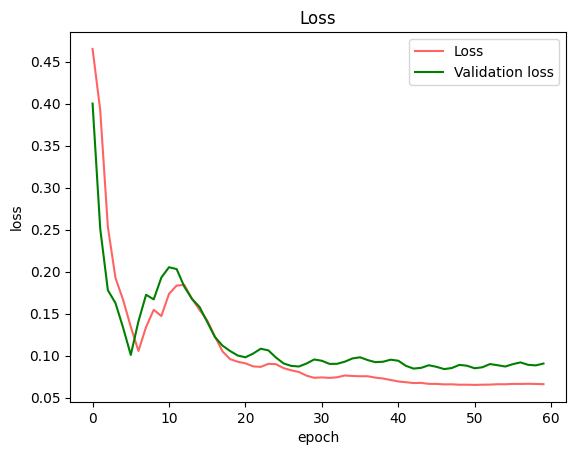

step 1, accuracy_train:0.55625, loss: 0.4641604203755734
step 2, accuracy_train:0.1875, loss: 0.3946849991638408
step 3, accuracy_train:0.6, loss: 0.24750004755805805
step 4, accuracy_train:0.6625, loss: 0.1919227283720378
step 5, accuracy_train:0.64375, loss: 0.1601705349994537
step 6, accuracy_train:0.7875, loss: 0.12223804906231912
step 7, accuracy_train:0.8625, loss: 0.10035634225762811
step 8, accuracy_train:0.81875, loss: 0.1343051815741049
step 9, accuracy_train:0.81875, loss: 0.1438958035871408
step 10, accuracy_train:0.88125, loss: 0.1419355581513441
step 11, accuracy_train:0.79375, loss: 0.17174584014812552
step 12, accuracy_train:0.79375, loss: 0.18108364449900852
step 13, accuracy_train:0.8625, loss: 0.1716242932789005
step 14, accuracy_train:0.84375, loss: 0.16029719191304068
step 15, accuracy_train:0.825, loss: 0.15182402231202557
step 16, accuracy_train:0.85, loss: 0.13350669266566775
step 17, accuracy_train:0.85, loss: 0.11685079334739588
step 18, accuracy_train:0.83125

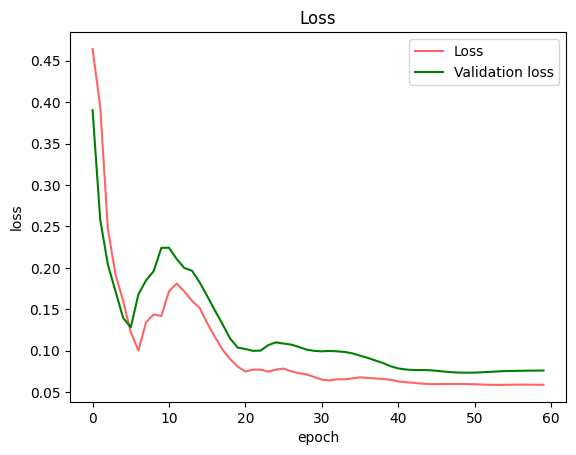

cv_time ：42.879226 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


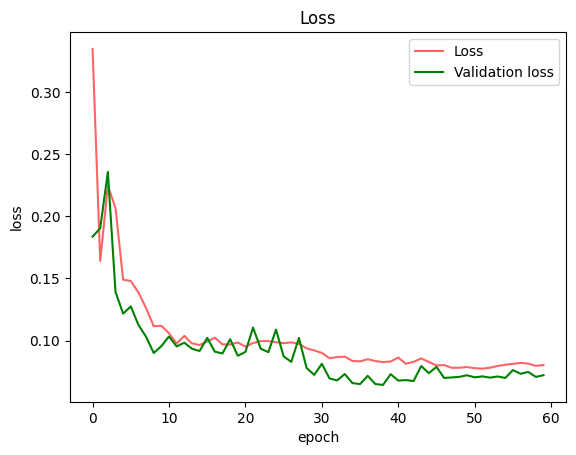

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.225, loss: 0.21947702167251926
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.575, loss: 0.1692957438466718
step 3, accuracy_train:0.5625, loss: 0.14817214151746588
step 4, accuracy_train:0.70625, loss: 0.11970766050941996
step 5, accuracy_train:0.74375, loss: 0.14314180114397945
step 6, accuracy_train:0.76875, loss: 0.14754260173498973
step 7, accuracy_train:0.775, loss: 0.11815019239427021
step 8, accuracy_train:0.79375, loss: 0.10444442772009047
step 9, accuracy_train:0.80625, loss: 0.10458568471004642
step 10, accuracy_train:0.8375, loss: 0.11390224863145351
step 11, accuracy_train:0.8125, loss: 0.10985272611016916
step 12, accuracy_train:0.84375, loss: 0.10607697615453943
step 13, accuracy_train:0.84375, loss: 0.094683

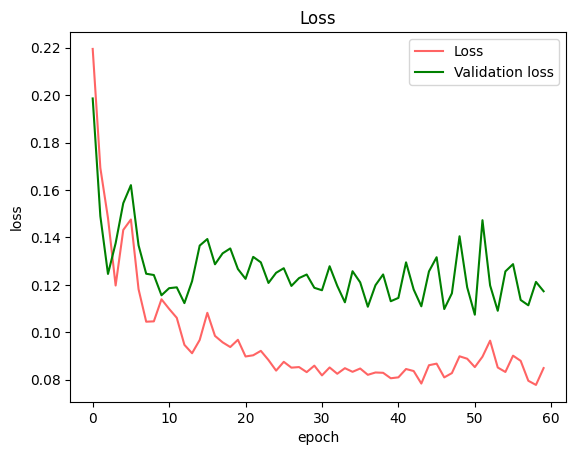

step 1, accuracy_train:0.2125, loss: 0.22372105875911077
step 2, accuracy_train:0.5625, loss: 0.18769611202133826
step 3, accuracy_train:0.70625, loss: 0.1616410745945885
step 4, accuracy_train:0.76875, loss: 0.13460492844018038
step 5, accuracy_train:0.7625, loss: 0.1260898288365647
step 6, accuracy_train:0.73125, loss: 0.1377067664224271
step 7, accuracy_train:0.775, loss: 0.13234812309889046
step 8, accuracy_train:0.79375, loss: 0.10955804473056818
step 9, accuracy_train:0.7875, loss: 0.10930476943079202
step 10, accuracy_train:0.83125, loss: 0.1112947770956649
step 11, accuracy_train:0.76875, loss: 0.11077718975536796
step 12, accuracy_train:0.825, loss: 0.10635690151618868
step 13, accuracy_train:0.8125, loss: 0.10328771164241282
step 14, accuracy_train:0.7875, loss: 0.0986647495329977
step 15, accuracy_train:0.825, loss: 0.09419509507682938
step 16, accuracy_train:0.80625, loss: 0.0894130410715405
step 17, accuracy_train:0.83125, loss: 0.08671882858069761
step 18, accuracy_train:

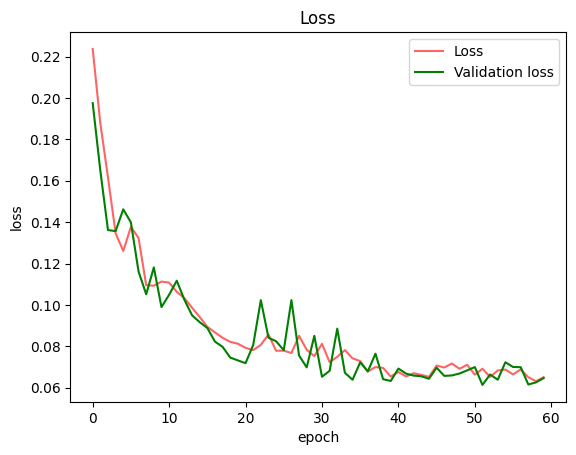

step 1, accuracy_train:0.18125, loss: 0.21893345053070523
step 2, accuracy_train:0.51875, loss: 0.19025517786041957
step 3, accuracy_train:0.6, loss: 0.16911177923928788
step 4, accuracy_train:0.68125, loss: 0.13753405497338506
step 5, accuracy_train:0.65625, loss: 0.13224222620275955
step 6, accuracy_train:0.75, loss: 0.1454868262669362
step 7, accuracy_train:0.8375, loss: 0.14611787514755853
step 8, accuracy_train:0.85, loss: 0.11995788229631638
step 9, accuracy_train:0.81875, loss: 0.11375153229188344
step 10, accuracy_train:0.8625, loss: 0.10953546153449237
step 11, accuracy_train:0.8625, loss: 0.11699369316554911
step 12, accuracy_train:0.84375, loss: 0.11876113246809157
step 13, accuracy_train:0.875, loss: 0.10905685465457014
step 14, accuracy_train:0.84375, loss: 0.10367902309407791
step 15, accuracy_train:0.8625, loss: 0.10142334998809327
step 16, accuracy_train:0.8875, loss: 0.1072161678916568
step 17, accuracy_train:0.84375, loss: 0.10556747549389801
step 18, accuracy_train:0

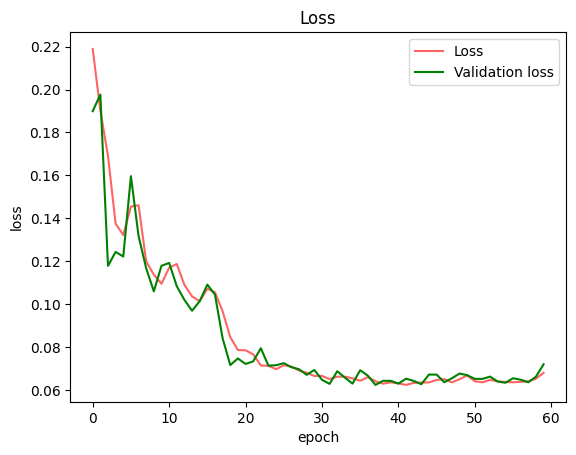

step 1, accuracy_train:0.24375, loss: 0.22290563488587248
step 2, accuracy_train:0.56875, loss: 0.19894079728522068
step 3, accuracy_train:0.63125, loss: 0.17278330499834377
step 4, accuracy_train:0.65625, loss: 0.14325580588060907
step 5, accuracy_train:0.7, loss: 0.12940717086675885
step 6, accuracy_train:0.69375, loss: 0.13040083353067464
step 7, accuracy_train:0.76875, loss: 0.1550085738855349
step 8, accuracy_train:0.86875, loss: 0.12257686191976802
step 9, accuracy_train:0.8375, loss: 0.08757032797754621
step 10, accuracy_train:0.85, loss: 0.08114076583746843
step 11, accuracy_train:0.86875, loss: 0.07741552013010321
step 12, accuracy_train:0.89375, loss: 0.08254047947729357
step 13, accuracy_train:0.86875, loss: 0.07546700133150486
step 14, accuracy_train:0.875, loss: 0.07270386547058788
step 15, accuracy_train:0.875, loss: 0.069469393958493
step 16, accuracy_train:0.88125, loss: 0.07090080802805071
step 17, accuracy_train:0.8875, loss: 0.06900567275624238
step 18, accuracy_trai

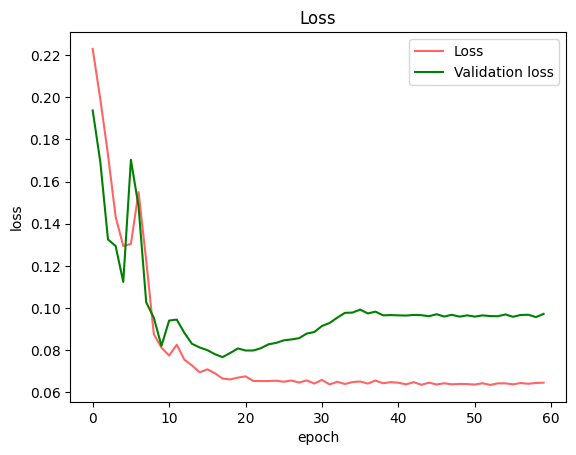

step 1, accuracy_train:0.24375, loss: 0.21003414158490435
step 2, accuracy_train:0.5375, loss: 0.1726996360859749
step 3, accuracy_train:0.6625, loss: 0.15549917175166583
step 4, accuracy_train:0.69375, loss: 0.1262158239665532
step 5, accuracy_train:0.79375, loss: 0.1081214519756544
step 6, accuracy_train:0.80625, loss: 0.10791467503943351
step 7, accuracy_train:0.8125, loss: 0.10130518660552665
step 8, accuracy_train:0.8, loss: 0.10278685011287955
step 9, accuracy_train:0.81875, loss: 0.083029909583375
step 10, accuracy_train:0.80625, loss: 0.08976068434084654
step 11, accuracy_train:0.83125, loss: 0.09893095687688076
step 12, accuracy_train:0.85, loss: 0.08291698506495417
step 13, accuracy_train:0.8125, loss: 0.06937789921384319
step 14, accuracy_train:0.8125, loss: 0.06562043902342905
step 15, accuracy_train:0.825, loss: 0.06769207138901802
step 16, accuracy_train:0.85, loss: 0.071813506137782
step 17, accuracy_train:0.84375, loss: 0.06724968400243554
step 18, accuracy_train:0.8687

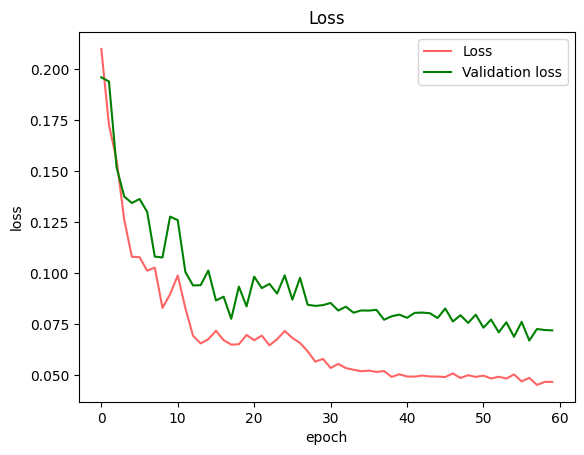

cv_time ：172.965026 s
((0.15, 0.05, 0.01), 60, 50, 50, (0.05, 0.03, 0.01))
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.16875, loss: 0.23758092947894355
step 2, accuracy_train:0.38125, loss: 0.19660185504936661
step 3, accuracy_train:0.4875, loss: 0.18734396702623413
step 4, accuracy_train:0.63125, loss: 0.18577139817358998
step 5, accuracy_train:0.78125, loss: 0.16400864376350233
step 6, accuracy_train:0.78125, loss: 0.13814797868711481
step 7, accuracy_train:0.79375, loss: 0.11521430109787356
step 8, accuracy_train:0.83125, loss: 0.10181995533270902
step 9, accuracy_train:0.8, loss: 0.09652585538716522
step 10, accuracy_train:0.84375, loss: 0.08971968690056278
step 11, accuracy_train:0.85625, loss: 0.08954000236918498
step 12, accuracy_train:0.875, loss: 0.0889923282908123
step 13, accuracy_train:0.88125, loss: 0.09064542731340133

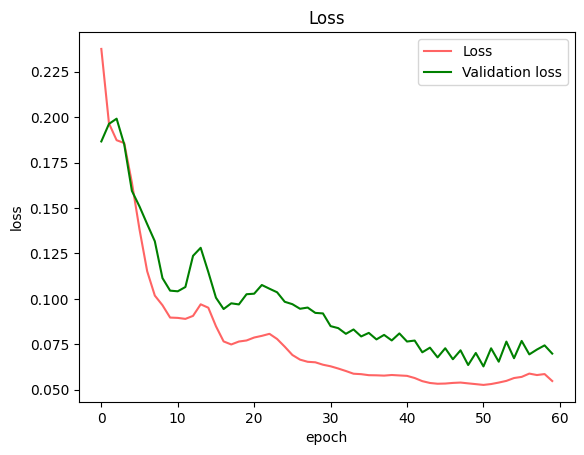

step 1, accuracy_train:0.19375, loss: 0.23772504892863372
step 2, accuracy_train:0.40625, loss: 0.19917606142622873
step 3, accuracy_train:0.4875, loss: 0.1802198757537935
step 4, accuracy_train:0.64375, loss: 0.1778607030869598
step 5, accuracy_train:0.64375, loss: 0.18129946779369466
step 6, accuracy_train:0.6625, loss: 0.16403408634492658
step 7, accuracy_train:0.7875, loss: 0.1286661002891723
step 8, accuracy_train:0.74375, loss: 0.10897034478099743
step 9, accuracy_train:0.8, loss: 0.10244949314337515
step 10, accuracy_train:0.79375, loss: 0.09717498901571754
step 11, accuracy_train:0.80625, loss: 0.09335777437398811
step 12, accuracy_train:0.8125, loss: 0.09216192083118635
step 13, accuracy_train:0.825, loss: 0.09946664576187597
step 14, accuracy_train:0.825, loss: 0.10752492070888839
step 15, accuracy_train:0.8625, loss: 0.10800657684999715
step 16, accuracy_train:0.8375, loss: 0.09920297940711506
step 17, accuracy_train:0.84375, loss: 0.08896169711378799
step 18, accuracy_train

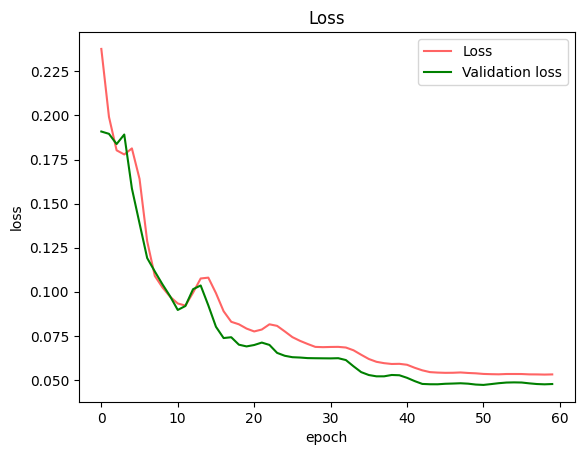

step 1, accuracy_train:0.18125, loss: 0.23815370370889366
step 2, accuracy_train:0.35625, loss: 0.19740798604251186
step 3, accuracy_train:0.5375, loss: 0.1842564049478682
step 4, accuracy_train:0.60625, loss: 0.16531229086874227
step 5, accuracy_train:0.6375, loss: 0.15375821329483313
step 6, accuracy_train:0.65625, loss: 0.12888273092223526
step 7, accuracy_train:0.70625, loss: 0.10865796483048748
step 8, accuracy_train:0.80625, loss: 0.10616352649699046
step 9, accuracy_train:0.8125, loss: 0.11122939701496079
step 10, accuracy_train:0.81875, loss: 0.11100433840726026
step 11, accuracy_train:0.8, loss: 0.11395704108380578
step 12, accuracy_train:0.84375, loss: 0.11486162016341236
step 13, accuracy_train:0.89375, loss: 0.11137131852711993
step 14, accuracy_train:0.90625, loss: 0.09926017496118657
step 15, accuracy_train:0.86875, loss: 0.08783916043001455
step 16, accuracy_train:0.875, loss: 0.08165236971462556
step 17, accuracy_train:0.88125, loss: 0.08019006328732398
step 18, accurac

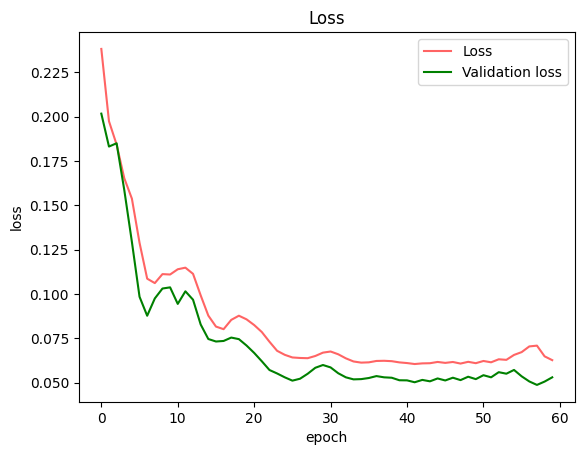

step 1, accuracy_train:0.20625, loss: 0.24017344503219434
step 2, accuracy_train:0.35625, loss: 0.194415892616969
step 3, accuracy_train:0.475, loss: 0.18538202289719577
step 4, accuracy_train:0.59375, loss: 0.18031996355091212
step 5, accuracy_train:0.7, loss: 0.17206118745352983
step 6, accuracy_train:0.71875, loss: 0.14186013561710645
step 7, accuracy_train:0.74375, loss: 0.12193915261652127
step 8, accuracy_train:0.76875, loss: 0.10740018796807874
step 9, accuracy_train:0.775, loss: 0.10637616688427065
step 10, accuracy_train:0.825, loss: 0.09952298706967164
step 11, accuracy_train:0.875, loss: 0.09485354633393038
step 12, accuracy_train:0.85625, loss: 0.09134972905860231
step 13, accuracy_train:0.8625, loss: 0.08943353447563765
step 14, accuracy_train:0.84375, loss: 0.0906215859084673
step 15, accuracy_train:0.8375, loss: 0.08832599446873796
step 16, accuracy_train:0.8625, loss: 0.08281529900655406
step 17, accuracy_train:0.88125, loss: 0.07928649926442913
step 18, accuracy_train:

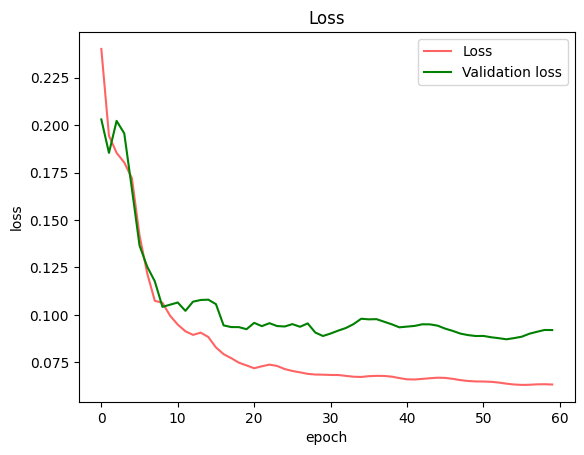

step 1, accuracy_train:0.19375, loss: 0.239363100533869
step 2, accuracy_train:0.3, loss: 0.20235890573152074
step 3, accuracy_train:0.4875, loss: 0.1902777756233528
step 4, accuracy_train:0.53125, loss: 0.19128902384147714
step 5, accuracy_train:0.71875, loss: 0.18735643536754465
step 6, accuracy_train:0.7125, loss: 0.16865125298220537
step 7, accuracy_train:0.7625, loss: 0.13262222693726433
step 8, accuracy_train:0.79375, loss: 0.11287634267592916
step 9, accuracy_train:0.8, loss: 0.09829748620992287
step 10, accuracy_train:0.8375, loss: 0.09039444088212195
step 11, accuracy_train:0.8625, loss: 0.09492071196504846
step 12, accuracy_train:0.83125, loss: 0.09944582709171551
step 13, accuracy_train:0.875, loss: 0.10674984644674892
step 14, accuracy_train:0.8875, loss: 0.10554781900486618
step 15, accuracy_train:0.89375, loss: 0.09435030227162469
step 16, accuracy_train:0.86875, loss: 0.0828804162552158
step 17, accuracy_train:0.85, loss: 0.07537317994596814
step 18, accuracy_train:0.875

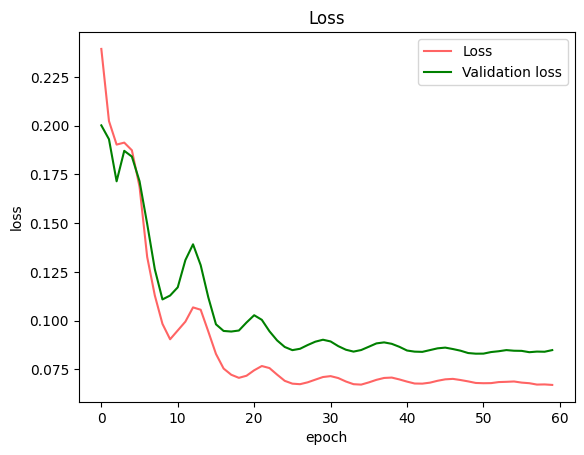

cv_time ：165.046316 s
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.13125, loss: 0.2584203270634705
step 2, accuracy_train:0.1875, loss: 0.22660708280794928
step 3, accuracy_train:0.26875, loss: 0.21031944461665011
step 4, accuracy_train:0.35, loss: 0.18364821738365109
step 5, accuracy_train:0.5125, loss: 0.170552731831305
step 6, accuracy_train:0.6375, loss: 0.1572598221615402
step 7, accuracy_train:0.65, loss: 0.16366583295768672
step 8, accuracy_train:0.78125, loss: 0.16289054226490898
step 9, accuracy_train:0.85, loss: 0.15486946570509438
step 10, accuracy_train:0.84375, loss: 0.1476661903852006
step 11, accuracy_train:0.83125, loss: 0.14117238444925778
step 12, accuracy_train:0.85625, loss: 0.12708488223553674
step 13, accuracy_train:0.85625, loss: 0.12050287777155824
step 14, accuracy_train:0.85, loss: 0.10906994015547194
step 15, accuracy_train:0.83125, loss: 0.1001164278558409
step 16, accuracy_train:0.8375, loss: 0.09872777422369101
step 17, ac

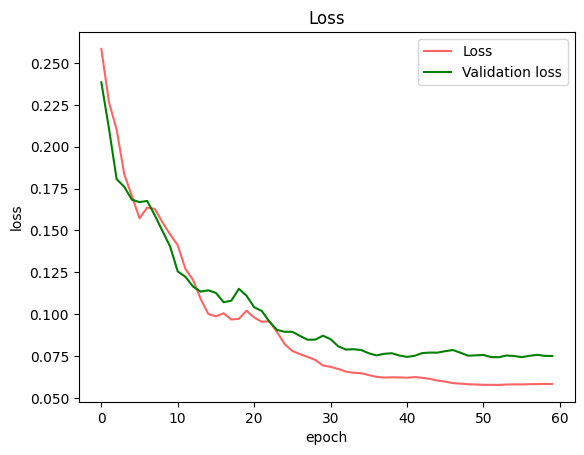

step 1, accuracy_train:0.1375, loss: 0.25914779172125463
step 2, accuracy_train:0.18125, loss: 0.2263165409648728
step 3, accuracy_train:0.2875, loss: 0.19874778797694367
step 4, accuracy_train:0.44375, loss: 0.18620616474409624
step 5, accuracy_train:0.51875, loss: 0.1779558454890213
step 6, accuracy_train:0.58125, loss: 0.16354612016513004
step 7, accuracy_train:0.6625, loss: 0.16654475726404955
step 8, accuracy_train:0.69375, loss: 0.1609066599119856
step 9, accuracy_train:0.7375, loss: 0.14793589050031083
step 10, accuracy_train:0.76875, loss: 0.12712790381626732
step 11, accuracy_train:0.74375, loss: 0.1213875114061413
step 12, accuracy_train:0.7125, loss: 0.11576054426485127
step 13, accuracy_train:0.75625, loss: 0.10703424986953138
step 14, accuracy_train:0.81875, loss: 0.10127213915970501
step 15, accuracy_train:0.80625, loss: 0.10187717415214331
step 16, accuracy_train:0.775, loss: 0.1041104087398738
step 17, accuracy_train:0.7875, loss: 0.10309271386093324
step 18, accuracy_t

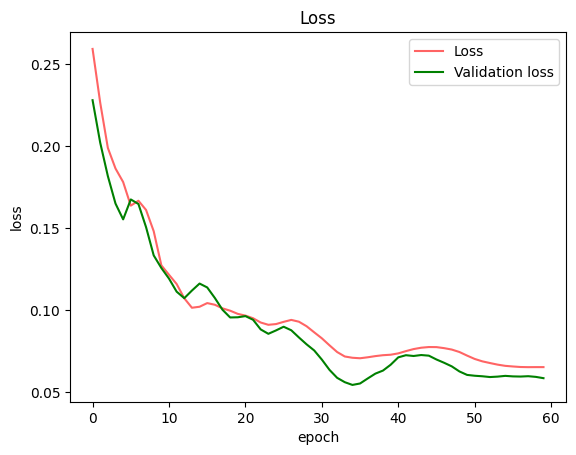

step 1, accuracy_train:0.14375, loss: 0.2591364881941502
step 2, accuracy_train:0.2375, loss: 0.22261813912212214
step 3, accuracy_train:0.3625, loss: 0.17799564855233974
step 4, accuracy_train:0.43125, loss: 0.1869222787393068
step 5, accuracy_train:0.55, loss: 0.1651278208236354
step 6, accuracy_train:0.65, loss: 0.1536085853250332
step 7, accuracy_train:0.725, loss: 0.13910396094194666
step 8, accuracy_train:0.71875, loss: 0.130834209520972
step 9, accuracy_train:0.73125, loss: 0.12006314624441906
step 10, accuracy_train:0.7375, loss: 0.11338372761232349
step 11, accuracy_train:0.71875, loss: 0.11444728571514397
step 12, accuracy_train:0.7375, loss: 0.11349871743758279
step 13, accuracy_train:0.76875, loss: 0.11464658248737912
step 14, accuracy_train:0.75625, loss: 0.11620015181236876
step 15, accuracy_train:0.75625, loss: 0.11556309453546064
step 16, accuracy_train:0.76875, loss: 0.11521014168274173
step 17, accuracy_train:0.79375, loss: 0.11156641341252718
step 18, accuracy_train:

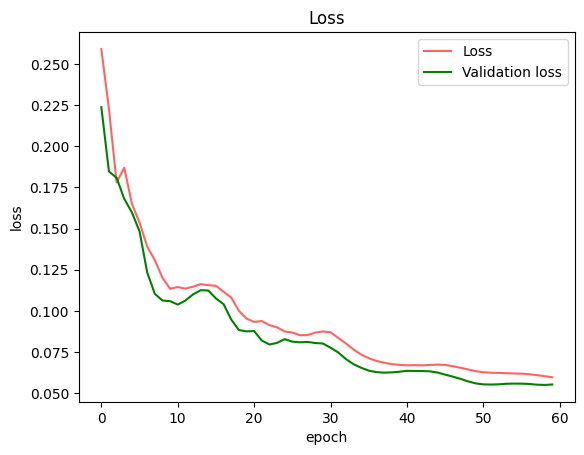

step 1, accuracy_train:0.1375, loss: 0.25985173562158514
step 2, accuracy_train:0.18125, loss: 0.22789358106593824
step 3, accuracy_train:0.26875, loss: 0.2060897623155091
step 4, accuracy_train:0.43125, loss: 0.18113997393157508
step 5, accuracy_train:0.4375, loss: 0.1867463502005182
step 6, accuracy_train:0.575, loss: 0.17669373705974253
step 7, accuracy_train:0.68125, loss: 0.16764112654928467
step 8, accuracy_train:0.73125, loss: 0.1611308881330987
step 9, accuracy_train:0.81875, loss: 0.14756134097053653
step 10, accuracy_train:0.7625, loss: 0.13845040483045903
step 11, accuracy_train:0.725, loss: 0.13215099650981116
step 12, accuracy_train:0.725, loss: 0.12155833084628558
step 13, accuracy_train:0.7875, loss: 0.11186560705407017
step 14, accuracy_train:0.8, loss: 0.10632556612817323
step 15, accuracy_train:0.84375, loss: 0.09966306060428645
step 16, accuracy_train:0.875, loss: 0.09692329330999436
step 17, accuracy_train:0.8625, loss: 0.09916977234886414
step 18, accuracy_train:0.

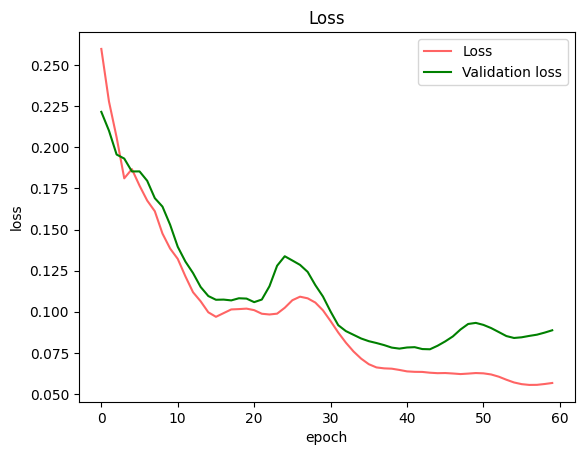

step 1, accuracy_train:0.15, loss: 0.25696112128837245
step 2, accuracy_train:0.10625, loss: 0.23119871580960896
step 3, accuracy_train:0.28125, loss: 0.1978109318405722
step 4, accuracy_train:0.35, loss: 0.19552728580412745
step 5, accuracy_train:0.49375, loss: 0.1882241901866959
step 6, accuracy_train:0.41875, loss: 0.1950525774878904
step 7, accuracy_train:0.46875, loss: 0.1966097489975888
step 8, accuracy_train:0.5375, loss: 0.1951829274429823
step 9, accuracy_train:0.56875, loss: 0.1858783743303337
step 10, accuracy_train:0.6375, loss: 0.1674727024352088
step 11, accuracy_train:0.75, loss: 0.14679024944285862
step 12, accuracy_train:0.8375, loss: 0.12886193674455082
step 13, accuracy_train:0.84375, loss: 0.1163962305683043
step 14, accuracy_train:0.85625, loss: 0.10676231490446314
step 15, accuracy_train:0.85, loss: 0.10131361763478719
step 16, accuracy_train:0.85625, loss: 0.09919582692402147
step 17, accuracy_train:0.83125, loss: 0.0976294846973795
step 18, accuracy_train:0.8375

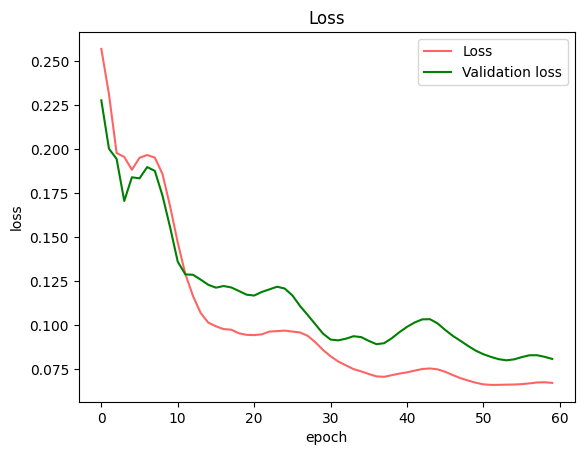

cv_time ：77.881488 s
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.225, loss: 0.21947702167251926
step 2, accuracy_train:0.575, loss: 0.1692957438466718
step 3, accuracy_train:0.5625, loss: 0.14817214151746588
step 4, accuracy_train:0.70625, loss: 0.11970766050941996
step 5, accuracy_train:0.74375, loss: 0.14314180114397945
step 6, accuracy_train:0.76875, loss: 0.14754260173498973
step 7, accuracy_train:0.775, loss: 0.11815019239427021
step 8, accuracy_train:0.79375, loss: 0.10444442772009047
step 9, accuracy_train:0.80625, loss: 0.10458568471004642
step 10, accuracy_train:0.8375, loss: 0.11390224863145351
step 11, accuracy_train:0.8125, loss: 0.10985272611016916
step 12, accuracy_train:0.84375, loss: 0.10607697615453943
step 13, accuracy_train:0.84375, loss: 0.09468302665249402
step 14, accuracy_train:0.8375, loss: 0.09114238174502146
step 15, accuracy_train:0.825, loss: 0.09673435579302478
step 16, accuracy_train:0.86875, loss: 0.10818912308867346
ste

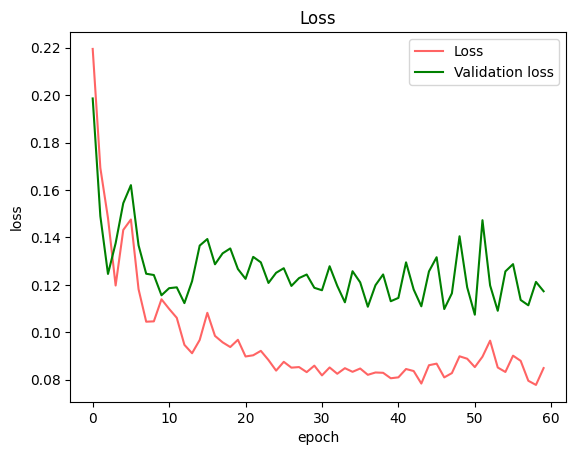

step 1, accuracy_train:0.2125, loss: 0.22372105875911077
step 2, accuracy_train:0.5625, loss: 0.18769611202133826
step 3, accuracy_train:0.70625, loss: 0.1616410745945885
step 4, accuracy_train:0.76875, loss: 0.13460492844018038
step 5, accuracy_train:0.7625, loss: 0.1260898288365647
step 6, accuracy_train:0.73125, loss: 0.1377067664224271
step 7, accuracy_train:0.775, loss: 0.13234812309889046
step 8, accuracy_train:0.79375, loss: 0.10955804473056818
step 9, accuracy_train:0.7875, loss: 0.10930476943079202
step 10, accuracy_train:0.83125, loss: 0.1112947770956649
step 11, accuracy_train:0.76875, loss: 0.11077718975536796
step 12, accuracy_train:0.825, loss: 0.10635690151618868
step 13, accuracy_train:0.8125, loss: 0.10328771164241282
step 14, accuracy_train:0.7875, loss: 0.0986647495329977
step 15, accuracy_train:0.825, loss: 0.09419509507682938
step 16, accuracy_train:0.80625, loss: 0.0894130410715405
step 17, accuracy_train:0.83125, loss: 0.08671882858069761
step 18, accuracy_train:

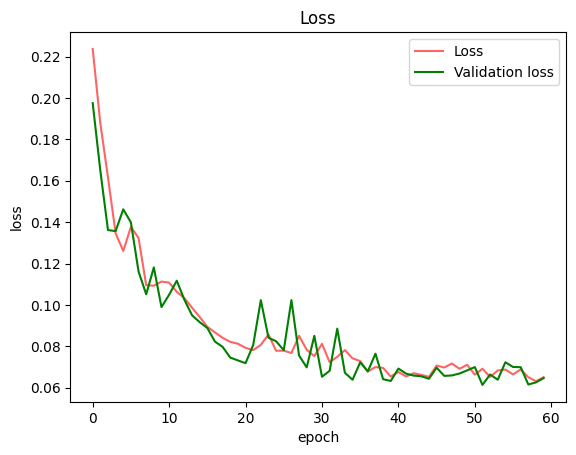

step 1, accuracy_train:0.18125, loss: 0.21893345053070523
step 2, accuracy_train:0.51875, loss: 0.19025517786041957
step 3, accuracy_train:0.6, loss: 0.16911177923928788
step 4, accuracy_train:0.68125, loss: 0.13753405497338506
step 5, accuracy_train:0.65625, loss: 0.13224222620275955
step 6, accuracy_train:0.75, loss: 0.1454868262669362
step 7, accuracy_train:0.8375, loss: 0.14611787514755853
step 8, accuracy_train:0.85, loss: 0.11995788229631638
step 9, accuracy_train:0.81875, loss: 0.11375153229188344
step 10, accuracy_train:0.8625, loss: 0.10953546153449237
step 11, accuracy_train:0.8625, loss: 0.11699369316554911
step 12, accuracy_train:0.84375, loss: 0.11876113246809157
step 13, accuracy_train:0.875, loss: 0.10905685465457014
step 14, accuracy_train:0.84375, loss: 0.10367902309407791
step 15, accuracy_train:0.8625, loss: 0.10142334998809327
step 16, accuracy_train:0.8875, loss: 0.1072161678916568
step 17, accuracy_train:0.84375, loss: 0.10556747549389801
step 18, accuracy_train:0

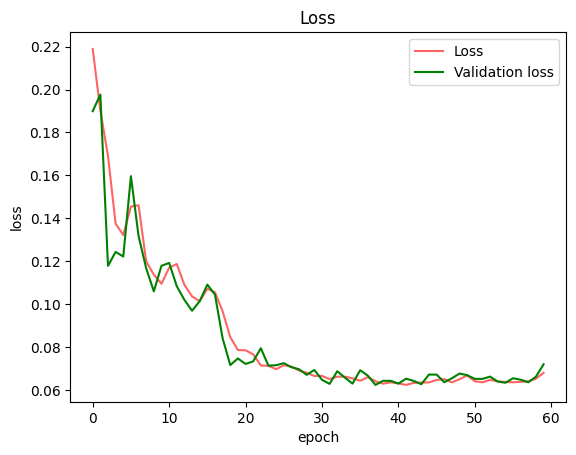

step 1, accuracy_train:0.24375, loss: 0.22290563488587248
step 2, accuracy_train:0.56875, loss: 0.19894079728522068
step 3, accuracy_train:0.63125, loss: 0.17278330499834377
step 4, accuracy_train:0.65625, loss: 0.14325580588060907
step 5, accuracy_train:0.7, loss: 0.12940717086675885
step 6, accuracy_train:0.69375, loss: 0.13040083353067464
step 7, accuracy_train:0.76875, loss: 0.1550085738855349
step 8, accuracy_train:0.86875, loss: 0.12257686191976802
step 9, accuracy_train:0.8375, loss: 0.08757032797754621
step 10, accuracy_train:0.85, loss: 0.08114076583746843
step 11, accuracy_train:0.86875, loss: 0.07741552013010321
step 12, accuracy_train:0.89375, loss: 0.08254047947729357
step 13, accuracy_train:0.86875, loss: 0.07546700133150486
step 14, accuracy_train:0.875, loss: 0.07270386547058788
step 15, accuracy_train:0.875, loss: 0.069469393958493
step 16, accuracy_train:0.88125, loss: 0.07090080802805071
step 17, accuracy_train:0.8875, loss: 0.06900567275624238
step 18, accuracy_trai

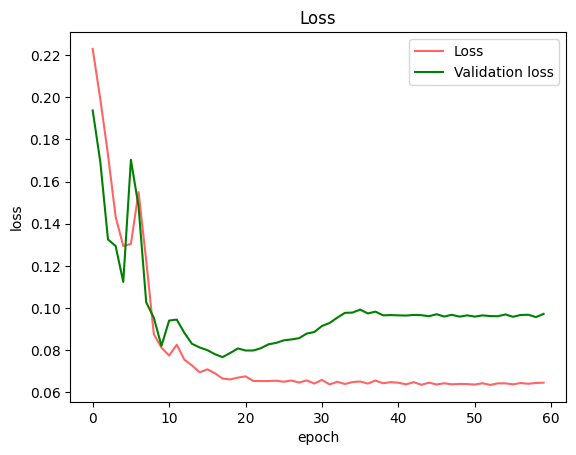

step 1, accuracy_train:0.24375, loss: 0.21003414158490435
step 2, accuracy_train:0.5375, loss: 0.1726996360859749
step 3, accuracy_train:0.6625, loss: 0.15549917175166583
step 4, accuracy_train:0.69375, loss: 0.1262158239665532
step 5, accuracy_train:0.79375, loss: 0.1081214519756544
step 6, accuracy_train:0.80625, loss: 0.10791467503943351
step 7, accuracy_train:0.8125, loss: 0.10130518660552665
step 8, accuracy_train:0.8, loss: 0.10278685011287955
step 9, accuracy_train:0.81875, loss: 0.083029909583375
step 10, accuracy_train:0.80625, loss: 0.08976068434084654
step 11, accuracy_train:0.83125, loss: 0.09893095687688076
step 12, accuracy_train:0.85, loss: 0.08291698506495417
step 13, accuracy_train:0.8125, loss: 0.06937789921384319
step 14, accuracy_train:0.8125, loss: 0.06562043902342905
step 15, accuracy_train:0.825, loss: 0.06769207138901802
step 16, accuracy_train:0.85, loss: 0.071813506137782
step 17, accuracy_train:0.84375, loss: 0.06724968400243554
step 18, accuracy_train:0.8687

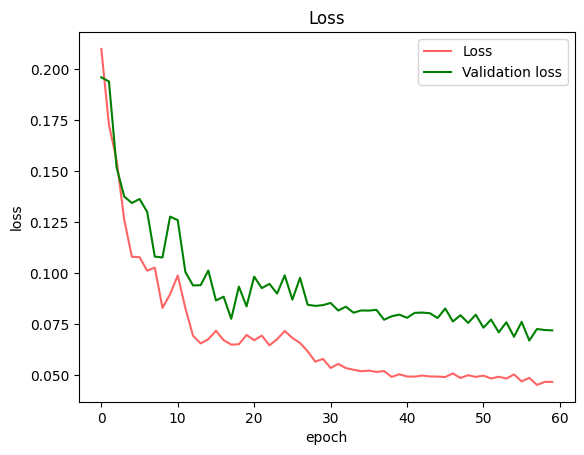

cv_time ：157.303351 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 50, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.16875, loss: 0.23758092947894355
step 2, accuracy_train:0.38125, loss: 0.19660185504936661
step 3, accuracy_train:0.4875, loss: 0.18734396702623413
step 4, accuracy_train:0.63125, loss: 0.18577139817358998
step 5, accuracy_train:0.78125, loss: 0.16400864376350233
step 6, accuracy_train:0.78125, loss: 0.13814797868711481
step 7, accuracy_train:0.79375, loss: 0.11521430109787356
step 8, accuracy_train:0.83125, loss: 0.10181995533270902
step 9, accuracy_train:0.8, loss: 0.09652585538716522
step 10, accuracy_train:0.84375, loss: 0.08971968690056278
step 11, accuracy_train:0.85625, loss: 0.08954000236918498
step 12, accuracy_train:0.875, loss: 0.0889923282908123
step 13, accuracy_train:0.88125, loss: 0.09064542731340133
step 14, accuracy_train:0.88125, loss: 0.09701686204192081
step 15, accuracy_train:0.85, loss: 0.09513872583324344
step 16, accuracy_train:0.9, loss: 0.08492996

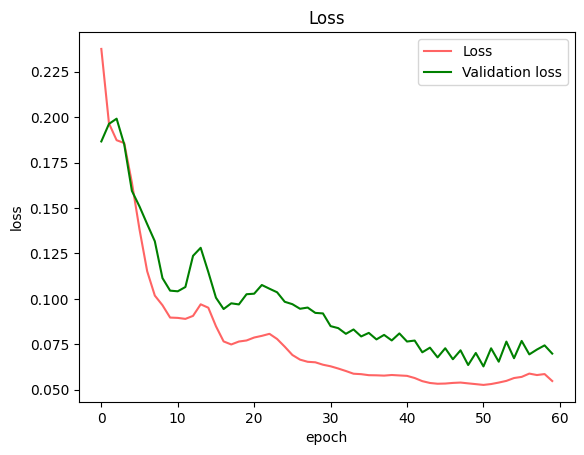

step 1, accuracy_train:0.19375, loss: 0.23772504892863372
step 2, accuracy_train:0.40625, loss: 0.19917606142622873
step 3, accuracy_train:0.4875, loss: 0.1802198757537935
step 4, accuracy_train:0.64375, loss: 0.1778607030869598
step 5, accuracy_train:0.64375, loss: 0.18129946779369466
step 6, accuracy_train:0.6625, loss: 0.16403408634492658
step 7, accuracy_train:0.7875, loss: 0.1286661002891723
step 8, accuracy_train:0.74375, loss: 0.10897034478099743
step 9, accuracy_train:0.8, loss: 0.10244949314337515
step 10, accuracy_train:0.79375, loss: 0.09717498901571754
step 11, accuracy_train:0.80625, loss: 0.09335777437398811
step 12, accuracy_train:0.8125, loss: 0.09216192083118635
step 13, accuracy_train:0.825, loss: 0.09946664576187597
step 14, accuracy_train:0.825, loss: 0.10752492070888839
step 15, accuracy_train:0.8625, loss: 0.10800657684999715
step 16, accuracy_train:0.8375, loss: 0.09920297940711506
step 17, accuracy_train:0.84375, loss: 0.08896169711378799
step 18, accuracy_train

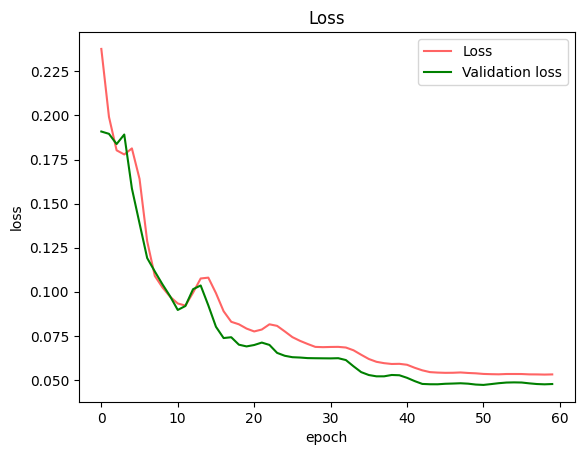

step 1, accuracy_train:0.18125, loss: 0.23815370370889366
step 2, accuracy_train:0.35625, loss: 0.19740798604251186
step 3, accuracy_train:0.5375, loss: 0.1842564049478682
step 4, accuracy_train:0.60625, loss: 0.16531229086874227
step 5, accuracy_train:0.6375, loss: 0.15375821329483313
step 6, accuracy_train:0.65625, loss: 0.12888273092223526
step 7, accuracy_train:0.70625, loss: 0.10865796483048748
step 8, accuracy_train:0.80625, loss: 0.10616352649699046
step 9, accuracy_train:0.8125, loss: 0.11122939701496079
step 10, accuracy_train:0.81875, loss: 0.11100433840726026
step 11, accuracy_train:0.8, loss: 0.11395704108380578
step 12, accuracy_train:0.84375, loss: 0.11486162016341236
step 13, accuracy_train:0.89375, loss: 0.11137131852711993
step 14, accuracy_train:0.90625, loss: 0.09926017496118657
step 15, accuracy_train:0.86875, loss: 0.08783916043001455
step 16, accuracy_train:0.875, loss: 0.08165236971462556
step 17, accuracy_train:0.88125, loss: 0.08019006328732398
step 18, accurac

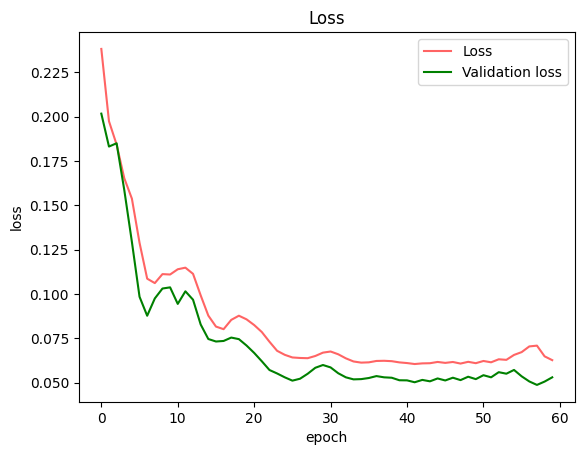

step 1, accuracy_train:0.20625, loss: 0.24017344503219434
step 2, accuracy_train:0.35625, loss: 0.194415892616969
step 3, accuracy_train:0.475, loss: 0.18538202289719577
step 4, accuracy_train:0.59375, loss: 0.18031996355091212
step 5, accuracy_train:0.7, loss: 0.17206118745352983
step 6, accuracy_train:0.71875, loss: 0.14186013561710645
step 7, accuracy_train:0.74375, loss: 0.12193915261652127
step 8, accuracy_train:0.76875, loss: 0.10740018796807874
step 9, accuracy_train:0.775, loss: 0.10637616688427065
step 10, accuracy_train:0.825, loss: 0.09952298706967164
step 11, accuracy_train:0.875, loss: 0.09485354633393038
step 12, accuracy_train:0.85625, loss: 0.09134972905860231
step 13, accuracy_train:0.8625, loss: 0.08943353447563765
step 14, accuracy_train:0.84375, loss: 0.0906215859084673
step 15, accuracy_train:0.8375, loss: 0.08832599446873796
step 16, accuracy_train:0.8625, loss: 0.08281529900655406
step 17, accuracy_train:0.88125, loss: 0.07928649926442913
step 18, accuracy_train:

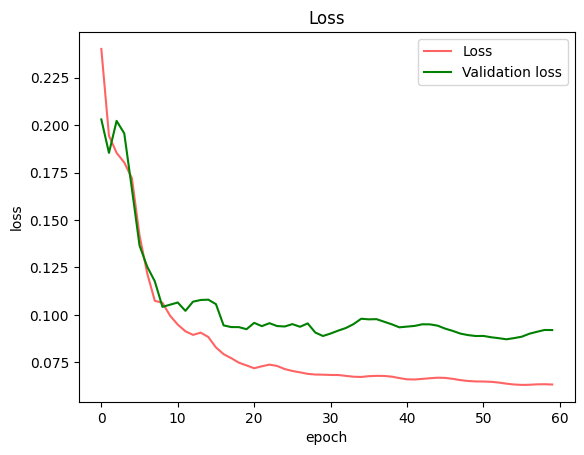

step 1, accuracy_train:0.19375, loss: 0.239363100533869
step 2, accuracy_train:0.3, loss: 0.20235890573152074
step 3, accuracy_train:0.4875, loss: 0.1902777756233528
step 4, accuracy_train:0.53125, loss: 0.19128902384147714
step 5, accuracy_train:0.71875, loss: 0.18735643536754465
step 6, accuracy_train:0.7125, loss: 0.16865125298220537
step 7, accuracy_train:0.7625, loss: 0.13262222693726433
step 8, accuracy_train:0.79375, loss: 0.11287634267592916
step 9, accuracy_train:0.8, loss: 0.09829748620992287
step 10, accuracy_train:0.8375, loss: 0.09039444088212195
step 11, accuracy_train:0.8625, loss: 0.09492071196504846
step 12, accuracy_train:0.83125, loss: 0.09944582709171551
step 13, accuracy_train:0.875, loss: 0.10674984644674892
step 14, accuracy_train:0.8875, loss: 0.10554781900486618
step 15, accuracy_train:0.89375, loss: 0.09435030227162469
step 16, accuracy_train:0.86875, loss: 0.0828804162552158
step 17, accuracy_train:0.85, loss: 0.07537317994596814
step 18, accuracy_train:0.875

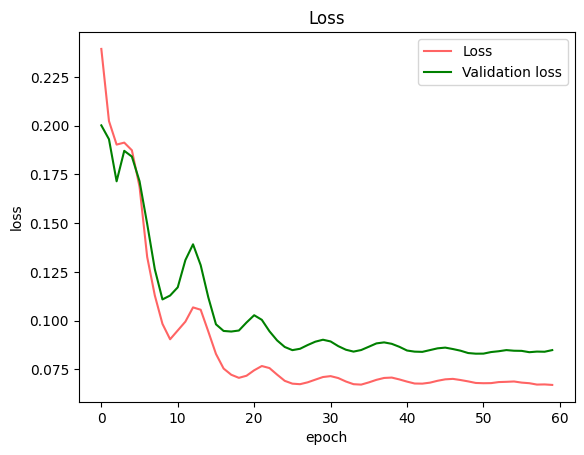

cv_time ：155.451955 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 100, 50, (0.05, 0.03, 0.01))
step 1, accuracy_train:0.13125, loss: 0.2584203270634705
step 2, accuracy_train:0.1875, loss: 0.22660708280794928
step 3, accuracy_train:0.26875, loss: 0.21031944461665011
step 4, accuracy_train:0.35, loss: 0.18364821738365109
step 5, accuracy_train:0.5125, loss: 0.170552731831305
step 6, accuracy_train:0.6375, loss: 0.1572598221615402
step 7, accuracy_train:0.65, loss: 0.16366583295768672
step 8, accuracy_train:0.78125, loss: 0.16289054226490898
step 9, accuracy_train:0.85, loss: 0.15486946570509438
step 10, accuracy_train:0.84375, loss: 0.1476661903852006
step 11, accuracy_train:0.83125, loss: 0.14117238444925778
step 12, accuracy_train:0.85625, loss: 0.12708488223553674
step 13, accuracy_train:0.85625, loss: 0.12050287777155824
step 14, accuracy_train:0.85, loss: 0.10906994015547194
step 15, accuracy_train:0.83125, loss: 0.1001164278558409
step 16, accuracy_train:0.8375, loss: 0.09872777422369

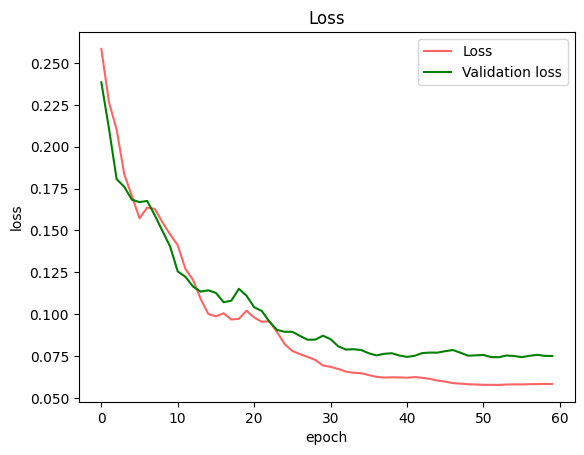

step 1, accuracy_train:0.1375, loss: 0.25914779172125463
step 2, accuracy_train:0.18125, loss: 0.2263165409648728
step 3, accuracy_train:0.2875, loss: 0.19874778797694367
step 4, accuracy_train:0.44375, loss: 0.18620616474409624
step 5, accuracy_train:0.51875, loss: 0.1779558454890213
step 6, accuracy_train:0.58125, loss: 0.16354612016513004
step 7, accuracy_train:0.6625, loss: 0.16654475726404955
step 8, accuracy_train:0.69375, loss: 0.1609066599119856
step 9, accuracy_train:0.7375, loss: 0.14793589050031083
step 10, accuracy_train:0.76875, loss: 0.12712790381626732
step 11, accuracy_train:0.74375, loss: 0.1213875114061413
step 12, accuracy_train:0.7125, loss: 0.11576054426485127
step 13, accuracy_train:0.75625, loss: 0.10703424986953138
step 14, accuracy_train:0.81875, loss: 0.10127213915970501
step 15, accuracy_train:0.80625, loss: 0.10187717415214331
step 16, accuracy_train:0.775, loss: 0.1041104087398738
step 17, accuracy_train:0.7875, loss: 0.10309271386093324
step 18, accuracy_t

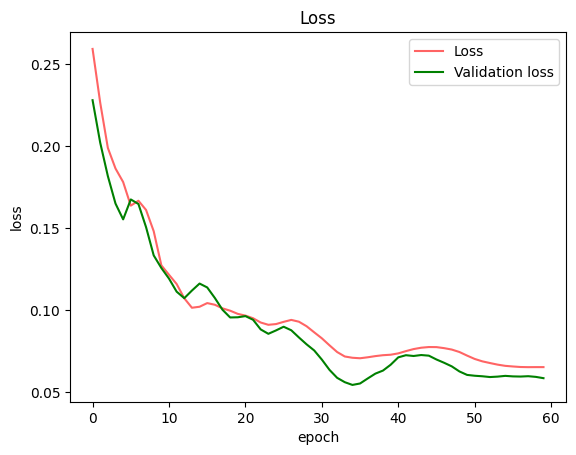

step 1, accuracy_train:0.14375, loss: 0.2591364881941502
step 2, accuracy_train:0.2375, loss: 0.22261813912212214
step 3, accuracy_train:0.3625, loss: 0.17799564855233974
step 4, accuracy_train:0.43125, loss: 0.1869222787393068
step 5, accuracy_train:0.55, loss: 0.1651278208236354
step 6, accuracy_train:0.65, loss: 0.1536085853250332
step 7, accuracy_train:0.725, loss: 0.13910396094194666
step 8, accuracy_train:0.71875, loss: 0.130834209520972
step 9, accuracy_train:0.73125, loss: 0.12006314624441906
step 10, accuracy_train:0.7375, loss: 0.11338372761232349
step 11, accuracy_train:0.71875, loss: 0.11444728571514397
step 12, accuracy_train:0.7375, loss: 0.11349871743758279
step 13, accuracy_train:0.76875, loss: 0.11464658248737912
step 14, accuracy_train:0.75625, loss: 0.11620015181236876
step 15, accuracy_train:0.75625, loss: 0.11556309453546064
step 16, accuracy_train:0.76875, loss: 0.11521014168274173
step 17, accuracy_train:0.79375, loss: 0.11156641341252718
step 18, accuracy_train:

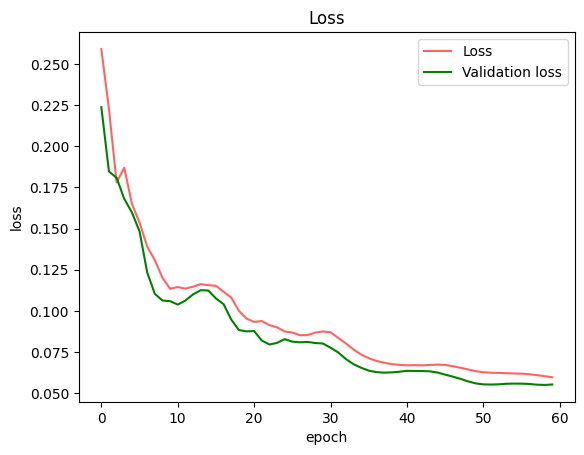

step 1, accuracy_train:0.1375, loss: 0.25985173562158514
step 2, accuracy_train:0.18125, loss: 0.22789358106593824
step 3, accuracy_train:0.26875, loss: 0.2060897623155091
step 4, accuracy_train:0.43125, loss: 0.18113997393157508
step 5, accuracy_train:0.4375, loss: 0.1867463502005182
step 6, accuracy_train:0.575, loss: 0.17669373705974253
step 7, accuracy_train:0.68125, loss: 0.16764112654928467
step 8, accuracy_train:0.73125, loss: 0.1611308881330987
step 9, accuracy_train:0.81875, loss: 0.14756134097053653
step 10, accuracy_train:0.7625, loss: 0.13845040483045903
step 11, accuracy_train:0.725, loss: 0.13215099650981116
step 12, accuracy_train:0.725, loss: 0.12155833084628558
step 13, accuracy_train:0.7875, loss: 0.11186560705407017
step 14, accuracy_train:0.8, loss: 0.10632556612817323
step 15, accuracy_train:0.84375, loss: 0.09966306060428645
step 16, accuracy_train:0.875, loss: 0.09692329330999436
step 17, accuracy_train:0.8625, loss: 0.09916977234886414
step 18, accuracy_train:0.

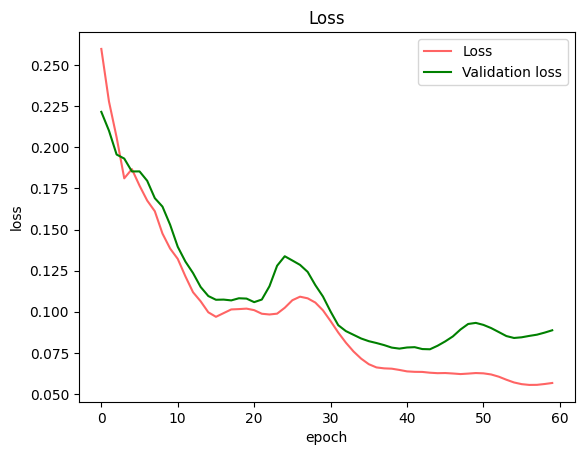

step 1, accuracy_train:0.15, loss: 0.25696112128837245
step 2, accuracy_train:0.10625, loss: 0.23119871580960896
step 3, accuracy_train:0.28125, loss: 0.1978109318405722
step 4, accuracy_train:0.35, loss: 0.19552728580412745
step 5, accuracy_train:0.49375, loss: 0.1882241901866959
step 6, accuracy_train:0.41875, loss: 0.1950525774878904
step 7, accuracy_train:0.46875, loss: 0.1966097489975888
step 8, accuracy_train:0.5375, loss: 0.1951829274429823
step 9, accuracy_train:0.56875, loss: 0.1858783743303337
step 10, accuracy_train:0.6375, loss: 0.1674727024352088
step 11, accuracy_train:0.75, loss: 0.14679024944285862
step 12, accuracy_train:0.8375, loss: 0.12886193674455082
step 13, accuracy_train:0.84375, loss: 0.1163962305683043
step 14, accuracy_train:0.85625, loss: 0.10676231490446314
step 15, accuracy_train:0.85, loss: 0.10131361763478719
step 16, accuracy_train:0.85625, loss: 0.09919582692402147
step 17, accuracy_train:0.83125, loss: 0.0976294846973795
step 18, accuracy_train:0.8375

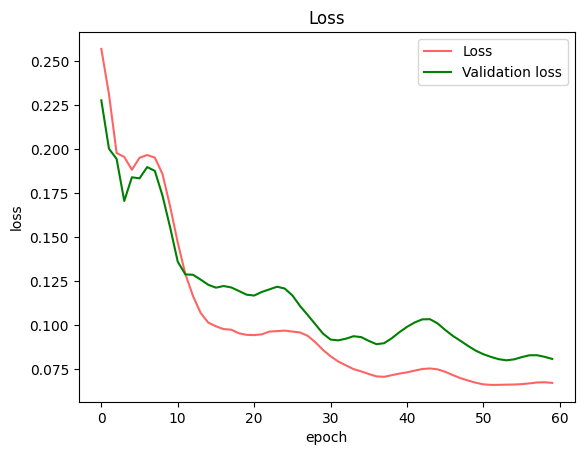

cv_time ：79.246329 s
((0.15, 0.05, 0.01, 0.001, 0.0001), 60, 300, 50, (0.05, 0.03, 0.01))


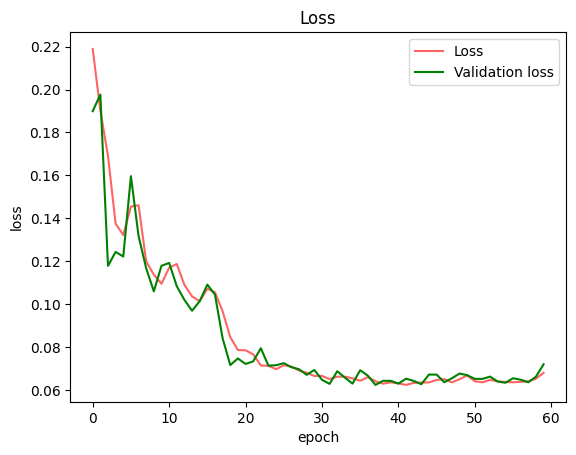

In [17]:
# Grid search of hyper-parameters
best_h_pm, h_pm_rsts =[], []
cv_start = time.process_time()
configs['noise'] = training_noise
for setting in settings:
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    
    h_pm_rst=[]
    loss_history_cvs=[]
    configs['qc'] = qcircuit(*setting, **configs)
    
    for h_pm in h_pms:
        learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pm
        configs['_h_pm'] = tuple(h_pm)
        
        seed_rsts, seed_params = [], []
        loss_history, valid_loss_history = [], []
        accuracy_history = []
        h_pm_rst.append(n_cv(num_cvs, X_train, y_train,setting, **configs))
        print(h_pm)

        
    h_pm_i = np.argmax(h_pm_rst,axis=0)[0]
    best_h_pm.append(h_pm_i)
    h_pm_rsts.append(h_pm_rst)
    l_h_best, val_l_h_best = loss_history_cvs[h_pm_i]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting, fig_name=f'{setting}_loss_best_h_pms')
t_cvs = time.process_time()-cv_start

In [18]:
def run(seed_num, x_tr, y_tr, *args, x_te=None, y_te=None, ratio_tr=0.875, **kwargs):
    #if:   x_te=None & y_te=None -> choosing random seed with validation accuracy
    #else: train and test
    global loss_history, valid_loss_history, lr    
    # print('run args', args)
    # configs['qc'] = qcircuit(*args, **configs)
    
    if x_te is None and y_te is None:
        from sklearn.utils import shuffle
        from sklearn.model_selection import train_test_split
        xs_tr, xs_val, ys_tr, ys_val = train_test_split(
            x_tr,y_tr,train_size=ratio_tr,random_state=seed_num,stratify=y_tr)
        # xs = shuffle(x_tr, random_state=seed_num, n_samples=None)
        # ys = shuffle(y_tr, random_state=seed_num, n_samples=None)
        # num_seed_train = int(num_training*ratio_tr)
        # num_seed_valid = num_training-num_seed_train
        # xs_tr = xs[:num_seed_train] 
        # ys_tr = ys[:num_seed_train]
        # xs_val = xs[num_seed_train:] 
        # ys_val = ys[num_seed_train:] 
    else:
        xs_tr, ys_tr, xs_val, ys_val = x_tr, y_tr, x_te, y_te

    params = initialize_params(enc_dim, num_qubits, num_layers, num_reupload, num_rot, num_class, seed_num)
    optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=lr)
    opt_state = optimizer.init(params)
    if x_te is None and y_te is None: # optimized by validation data but not peeking in true test data
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr,x_valid=xs_val,y_valid=ys_val, *args, **kwargs)  
    else: 
        params, lr, opt_state, num_epoch = fit(params, optimizer, opt_state, xs_tr, ys_tr, *args, **configs)
    accuracy_train, loss, accuracy_valid, loss_test = scores(params, xs_tr, ys_tr, x_te=xs_val, y_te=ys_val, *args, **kwargs)
    plot_loss_history(loss_history, valid_loss_history, setting=args, fig_name=None)
    
    if x_te is None and y_te is None:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Validation Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    else:
        print("Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(0, loss, accuracy_train, accuracy_valid))
    print(f"(n_dim, n_q, n_f, n_r, n_rot) = {enc_dim, num_qubits, num_layers, num_reupload, num_rot}")
    
    return params, [seed_num, accuracy_train, accuracy_valid, loss, num_epoch]

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.14857142857142858, loss: 0.3243489022773129
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.41714285714285715, loss: 0.2558893435603522
step 3, accuracy_train:0.4514285714285714, loss: 0.22645390539567367
step 4, accuracy_train:0.44571428571428573, loss: 0.21995703730695684
step 5, accuracy_train:0.4857142857142857, loss: 0.19127557458234556
step 6, accuracy_train:0.48, loss: 0.1692281366961624
step 7, accuracy_train:0.52, loss: 0.18082831446464337
step 8, accuracy_train:0.5428571428571428, loss: 0.1816140948174968
step 9, accuracy_train:0.6114285714285714, loss: 0.16638699680855884
step 10, accuracy_train:0.5714285714285714, loss: 0.1646995609790254
step 11, accuracy_train:0.56, loss: 0.16931060221027158
step 12, accuracy_train:0.6, loss: 0.1542118889941876
step 13, accuracy_train:0.6914285714285714, loss: 0.1

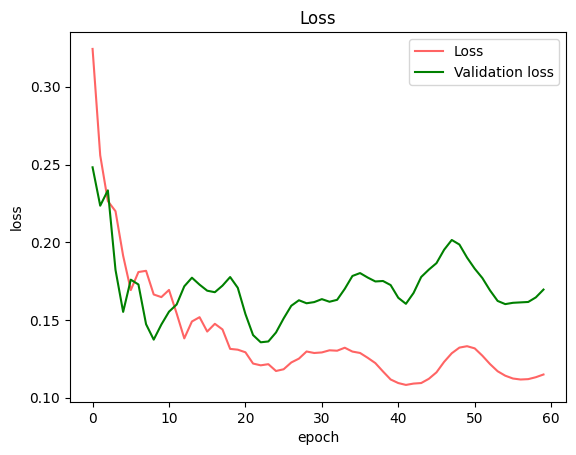

Epoch:  0 | Cost: 0.120813 | Train accuracy: 0.742857 | Validation Accuracy: 0.600000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.18285714285714286, loss: 0.40765261744456344
step 2, accuracy_train:0.17714285714285713, loss: 0.3755702025438128
step 3, accuracy_train:0.2914285714285714, loss: 0.3217900558223873
step 4, accuracy_train:0.34285714285714286, loss: 0.2711835085433904
step 5, accuracy_train:0.37142857142857144, loss: 0.24817270291322155
step 6, accuracy_train:0.45714285714285713, loss: 0.2254253220393921
step 7, accuracy_train:0.4114285714285714, loss: 0.2515371249662832
step 8, accuracy_train:0.3942857142857143, loss: 0.26053017491334546
step 9, accuracy_train:0.4342857142857143, loss: 0.23096234514121655
step 10, accuracy_train:0.5028571428571429, loss: 0.19293101536591833
step 11, accuracy_train:0.6114285714285714, loss: 0.16604160577452812
step 12, accuracy_train:0.6228571428571429, loss: 0.1571325743299682
step 13, accuracy_train:0.64, loss: 

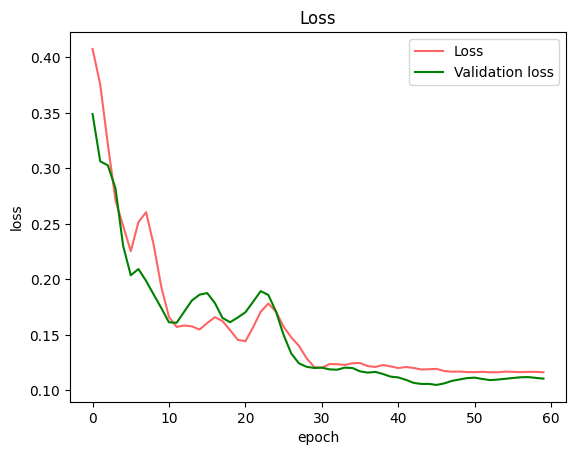

Epoch:  0 | Cost: 0.119309 | Train accuracy: 0.714286 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.16, loss: 0.34594057391923133
step 2, accuracy_train:0.32571428571428573, loss: 0.25950812408727214
step 3, accuracy_train:0.45714285714285713, loss: 0.22325332838785153
step 4, accuracy_train:0.6228571428571429, loss: 0.15452850448866845
step 5, accuracy_train:0.6057142857142858, loss: 0.15786342206401974
step 6, accuracy_train:0.6685714285714286, loss: 0.13583493871273475
step 7, accuracy_train:0.7714285714285715, loss: 0.11461909679506793
step 8, accuracy_train:0.5942857142857143, loss: 0.12635011184176906
step 9, accuracy_train:0.8057142857142857, loss: 0.12069487100087012
step 10, accuracy_train:0.8228571428571428, loss: 0.13642397862121286
step 11, accuracy_train:0.8, loss: 0.15180329916229776
step 12, accuracy_train:0.84, loss: 0.13360932087152685
step 13, accuracy_train:0.84, loss: 0.1206238907862792
step 14, accuracy_tra

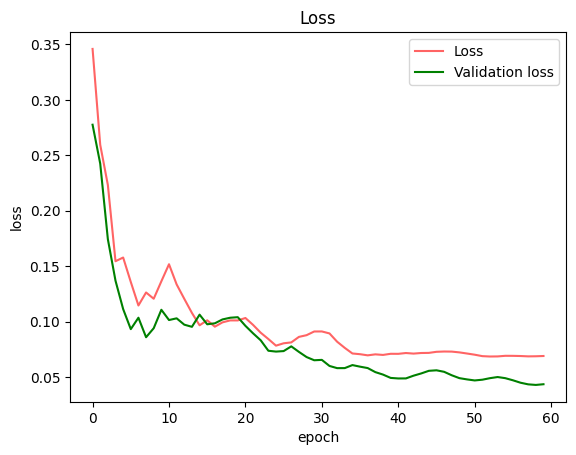

Epoch:  0 | Cost: 0.068837 | Train accuracy: 0.874286 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.2571428571428571, loss: 0.3608466074112972
step 2, accuracy_train:0.48, loss: 0.2617167477650054
step 3, accuracy_train:0.5942857142857143, loss: 0.17631617801672572
step 4, accuracy_train:0.6228571428571429, loss: 0.15498877397381888
step 5, accuracy_train:0.5771428571428572, loss: 0.1680531057817776
step 6, accuracy_train:0.5828571428571429, loss: 0.17481175673449256
step 7, accuracy_train:0.6457142857142857, loss: 0.16302796942964182
step 8, accuracy_train:0.6685714285714286, loss: 0.15402906806967567
step 9, accuracy_train:0.6971428571428572, loss: 0.15291329847757945
step 10, accuracy_train:0.6914285714285714, loss: 0.15144117436358476
step 11, accuracy_train:0.6971428571428572, loss: 0.15156441645288266
step 12, accuracy_train:0.6914285714285714, loss: 0.15131068599810016
step 13, accuracy_train:0.68, loss: 0.15115326849435

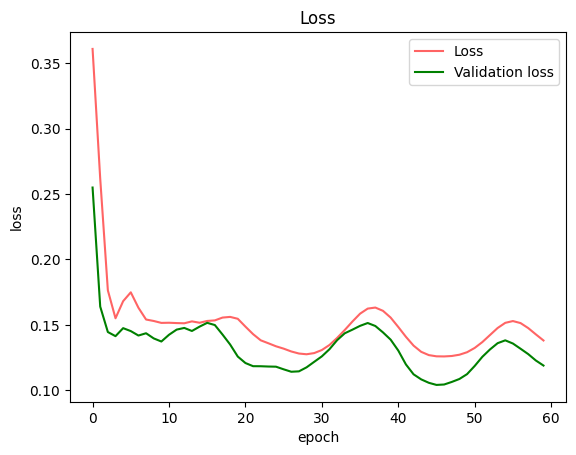

Epoch:  0 | Cost: 0.125901 | Train accuracy: 0.702857 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.5142857142857142, loss: 0.2018510925121967
step 2, accuracy_train:0.2057142857142857, loss: 0.3132805066459886
step 3, accuracy_train:0.48, loss: 0.19113912454427806
step 4, accuracy_train:0.44571428571428573, loss: 0.24965460987380977
step 5, accuracy_train:0.4342857142857143, loss: 0.24636494126997957
step 6, accuracy_train:0.4857142857142857, loss: 0.2055325922938102
step 7, accuracy_train:0.5085714285714286, loss: 0.19027197973453497
step 8, accuracy_train:0.46285714285714286, loss: 0.2318915892572653
step 9, accuracy_train:0.36, loss: 0.2632924958833177
step 10, accuracy_train:0.4228571428571429, loss: 0.25183465170889074
step 11, accuracy_train:0.5942857142857143, loss: 0.21037463519505362
step 12, accuracy_train:0.6457142857142857, loss: 0.18267179629469596
step 13, accuracy_train:0.6, loss: 0.18287851994884527
step 14, ac

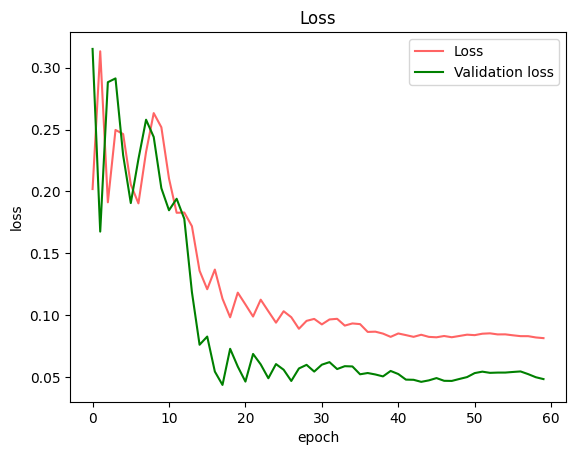

Epoch:  0 | Cost: 0.113167 | Train accuracy: 0.765714 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.5714285714285714, loss: 0.40003941361760004
step 2, accuracy_train:0.09714285714285714, loss: 0.3866368014356783
step 3, accuracy_train:0.68, loss: 0.20597151504112057
step 4, accuracy_train:0.5428571428571428, loss: 0.20557817301587394
step 5, accuracy_train:0.5771428571428572, loss: 0.17739546840793136
step 6, accuracy_train:0.7257142857142858, loss: 0.10898407339303917
step 7, accuracy_train:0.6, loss: 0.16127453142888834
step 8, accuracy_train:0.7085714285714285, loss: 0.13311657269644236
step 9, accuracy_train:0.7714285714285715, loss: 0.11263809263128625
step 10, accuracy_train:0.6628571428571428, loss: 0.1593008918595459
step 11, accuracy_train:0.6742857142857143, loss: 0.14682751372338468
step 12, accuracy_train:0.7885714285714286, loss: 0.10473684298732536
step 13, accuracy_train:0.7885714285714286, loss: 0.1039547029986

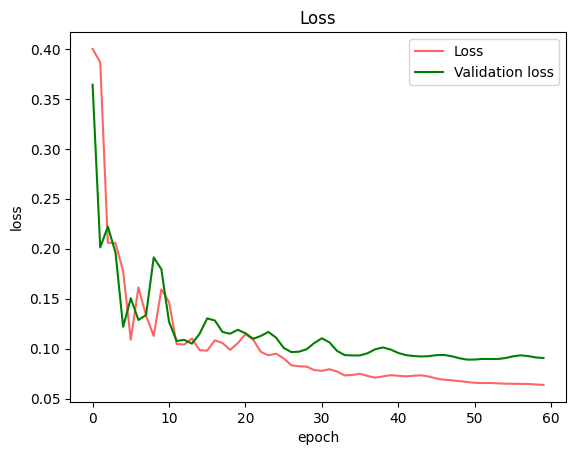

Epoch:  0 | Cost: 0.066541 | Train accuracy: 0.868571 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.28, loss: 0.2944505386910554
step 2, accuracy_train:0.17142857142857143, loss: 0.35919241971863164
step 3, accuracy_train:0.5314285714285715, loss: 0.21551726727049758
step 4, accuracy_train:0.52, loss: 0.24683378226047514
step 5, accuracy_train:0.6, loss: 0.2263475266269489
step 6, accuracy_train:0.7085714285714285, loss: 0.14791732620830705
step 7, accuracy_train:0.6857142857142857, loss: 0.1378602865695765
step 8, accuracy_train:0.5771428571428572, loss: 0.1656832849755183
step 9, accuracy_train:0.56, loss: 0.17390135177533014
step 10, accuracy_train:0.6285714285714286, loss: 0.1771501578404583
step 11, accuracy_train:0.6114285714285714, loss: 0.190104741098211
step 12, accuracy_train:0.6057142857142858, loss: 0.20083680535539056
step 13, accuracy_train:0.6285714285714286, loss: 0.19495411277214048
step 14, accuracy_train:0.69

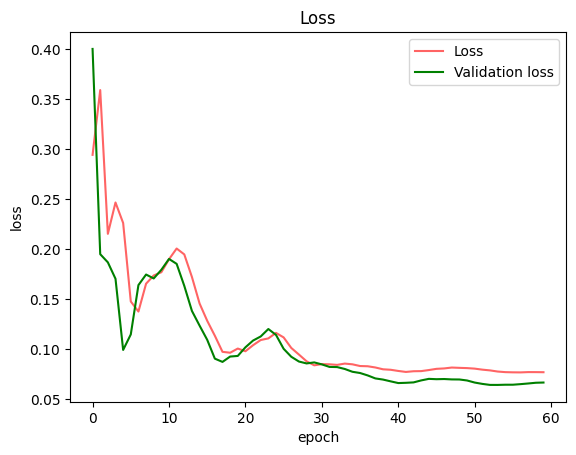

Epoch:  0 | Cost: 0.077907 | Train accuracy: 0.834286 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.5828571428571429, loss: 0.17492091612465147
step 2, accuracy_train:0.3314285714285714, loss: 0.3118226455116414
step 3, accuracy_train:0.5942857142857143, loss: 0.17386432889921427
step 4, accuracy_train:0.4685714285714286, loss: 0.19325018944733433
step 5, accuracy_train:0.44, loss: 0.21423708959436222
step 6, accuracy_train:0.6628571428571428, loss: 0.17536356085909927
step 7, accuracy_train:0.7714285714285715, loss: 0.15579197371334938
step 8, accuracy_train:0.5714285714285714, loss: 0.18494730055105577
step 9, accuracy_train:0.6, loss: 0.16959382897050243
step 10, accuracy_train:0.7885714285714286, loss: 0.11415363696568985
step 11, accuracy_train:0.8228571428571428, loss: 0.10076376092596198
step 12, accuracy_train:0.6742857142857143, loss: 0.12836081987620662
step 13, accuracy_train:0.7257142857142858, loss: 0.1216106527722

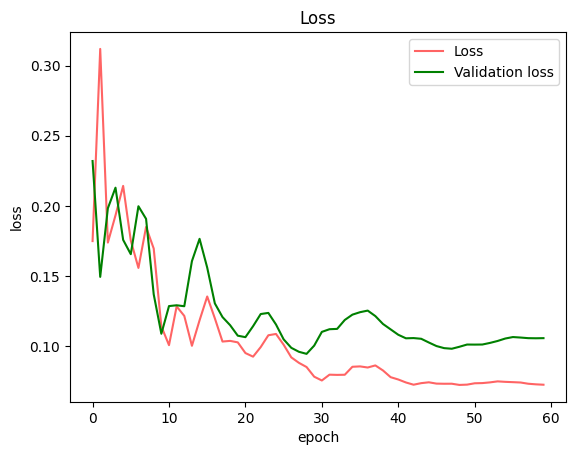

Epoch:  0 | Cost: 0.085177 | Train accuracy: 0.834286 | Validation Accuracy: 0.840000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.5657142857142857, loss: 0.5561573388490214
step 2, accuracy_train:0.37714285714285717, loss: 0.439821267001407
step 3, accuracy_train:0.6571428571428571, loss: 0.29950475389027353
step 4, accuracy_train:0.6971428571428572, loss: 0.21167495904008385
step 5, accuracy_train:0.6685714285714286, loss: 0.1557891778278458
step 6, accuracy_train:0.7542857142857143, loss: 0.10458638133429064
step 7, accuracy_train:0.8342857142857143, loss: 0.09200894019149106
step 8, accuracy_train:0.7828571428571428, loss: 0.10241882262073672
step 9, accuracy_train:0.84, loss: 0.0965715541182486
step 10, accuracy_train:0.8171428571428572, loss: 0.11472155202835956
step 11, accuracy_train:0.7714285714285715, loss: 0.13431959797189633
step 12, accuracy_train:0.8285714285714286, loss: 0.11654990898596485
step 13, accuracy_train:0.8171428571428572, loss: 0.1

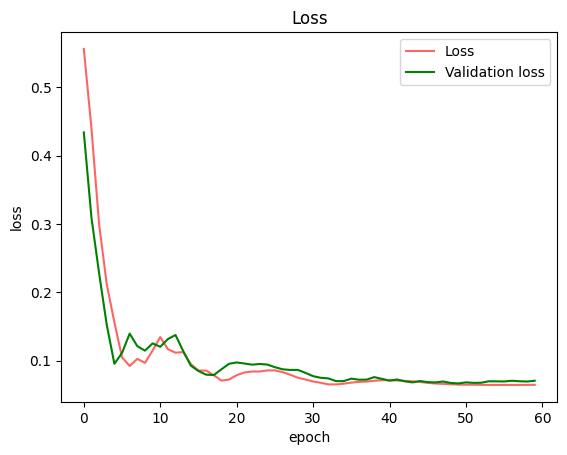

Epoch:  0 | Cost: 0.064687 | Train accuracy: 0.868571 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
step 1, accuracy_train:0.3485714285714286, loss: 0.23853039221368916
step 2, accuracy_train:0.38285714285714284, loss: 0.22920201581499336
step 3, accuracy_train:0.64, loss: 0.15651902646632807
step 4, accuracy_train:0.4857142857142857, loss: 0.1722479627007696
step 5, accuracy_train:0.5828571428571429, loss: 0.15641503077863805
step 6, accuracy_train:0.6, loss: 0.14970967741554742
step 7, accuracy_train:0.6171428571428571, loss: 0.16632478656213998
step 8, accuracy_train:0.6571428571428571, loss: 0.16052693149956176
step 9, accuracy_train:0.6171428571428571, loss: 0.1731334096861173
step 10, accuracy_train:0.6171428571428571, loss: 0.17352124357871185
step 11, accuracy_train:0.6457142857142857, loss: 0.14831209628141112
step 12, accuracy_train:0.6914285714285714, loss: 0.137472003174573
step 13, accuracy_train:0.6857142857142857, loss: 0.143611466340694

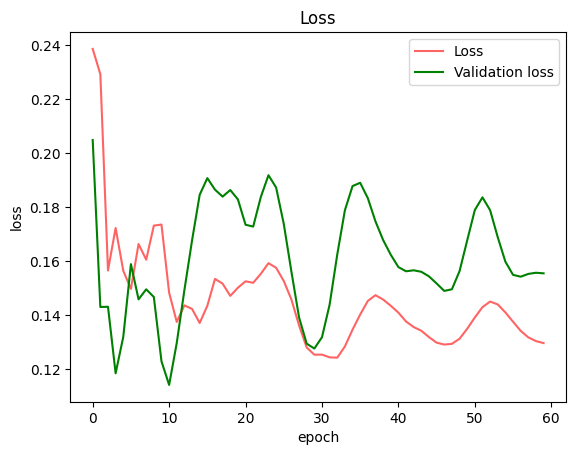

Epoch:  0 | Cost: 0.148312 | Train accuracy: 0.645714 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)
t_n_seeds: 41.388587500000085


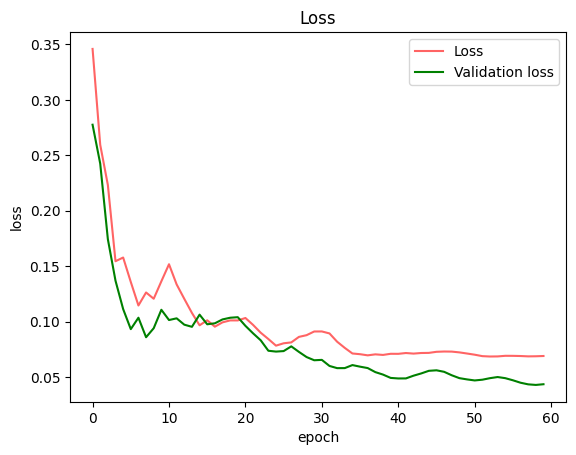

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.155, loss: 0.3451602107171529
step 2, accuracy_train:0.33, loss: 0.261769809673971
step 3, accuracy_train:0.46, loss: 0.22669609703525473
step 4, accuracy_train:0.585, loss: 0.1599408840856607
step 5, accuracy_train:0.605, loss: 0.15393938479886457
step 6, accuracy_train:0.645, loss: 0.13682362152870675
step 7, accuracy_train:0.795, loss: 0.11028395266650556
step 8, accuracy_train:0.56, loss: 0.1292654009357428
step 9, accuracy_train:0.755, loss: 0.12567955524283797
step 10, accuracy_train:0.83, loss: 0.13444238908829595
step 11, accuracy_train:0.805, loss: 0.15454531945480363
step 12, accuracy_train:0.84, loss: 0.13822813662623912
step 13, accuracy_train:0.865, loss: 0.11994765345220686
step 14, accuracy_train:0.815, loss: 0.11400435216302642
step 15, accuracy_train:0.86, loss: 0.09529231834866614
step 16, accuracy_train:0.815, loss: 0.09799656926655548
step 17, accuracy_tr

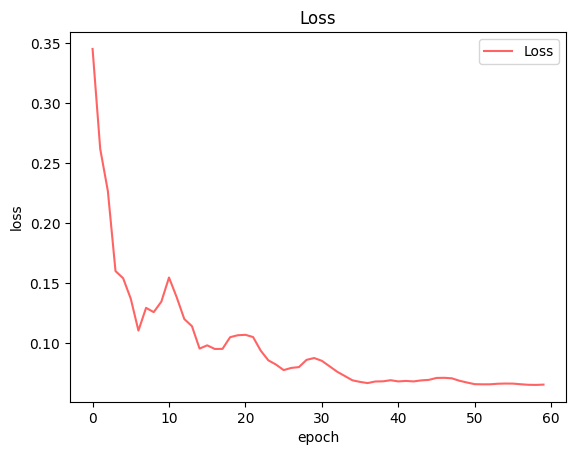

Epoch:  0 | Cost: 0.064994 | Train accuracy: 0.880000 | Test Accuracy: 0.720000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 1, 1, 1, 3)


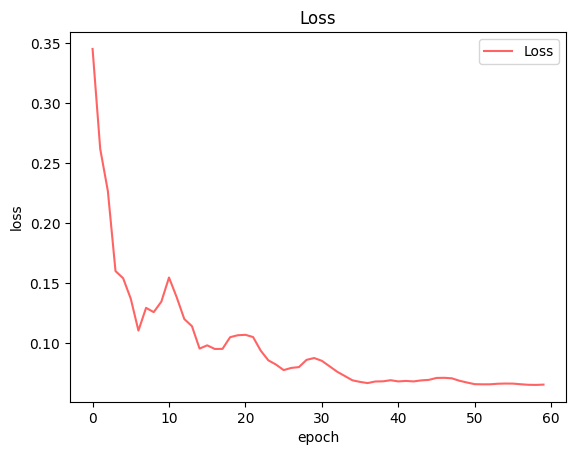

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.34285714285714286, loss: 0.28421175975651347
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.3314285714285714, loss: 0.23974051611191025
step 3, accuracy_train:0.38285714285714284, loss: 0.21132076831894595
step 4, accuracy_train:0.4685714285714286, loss: 0.20921759948222846
step 5, accuracy_train:0.38857142857142857, loss: 0.2329378289012109
step 6, accuracy_train:0.4, loss: 0.24715792466007339
step 7, accuracy_train:0.4, loss: 0.2383550066010418
step 8, accuracy_train:0.5485714285714286, loss: 0.22137699832225288
step 9, accuracy_train:0.5657142857142857, loss: 0.20622699035571912
step 10, accuracy_train:0.56, loss: 0.18739342522091118
step 11, accuracy_train:0.5485714285714286, loss: 0.16874124436536636
step 12, accuracy_train:0.5885714285714285, loss: 0.15774878017510283
step 13, accuracy_train:0.5942857142

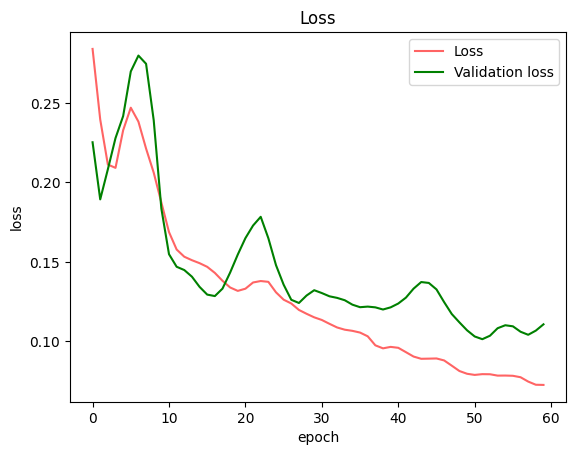

Epoch:  0 | Cost: 0.079174 | Train accuracy: 0.822857 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.3142857142857143, loss: 0.20184357712580595
step 2, accuracy_train:0.42857142857142855, loss: 0.19234833454691969
step 3, accuracy_train:0.52, loss: 0.16117381596519972
step 4, accuracy_train:0.6171428571428571, loss: 0.16136010323712233
step 5, accuracy_train:0.6285714285714286, loss: 0.16126308182162116
step 6, accuracy_train:0.6057142857142858, loss: 0.15037379080667032
step 7, accuracy_train:0.6742857142857143, loss: 0.13234108558069205
step 8, accuracy_train:0.6571428571428571, loss: 0.1276217327471004
step 9, accuracy_train:0.6628571428571428, loss: 0.12651304454577436
step 10, accuracy_train:0.7542857142857143, loss: 0.11155443591245821
step 11, accuracy_train:0.7942857142857143, loss: 0.10621201761288528
step 12, accuracy_train:0.8114285714285714, loss: 0.09676224999384857
step 13, accuracy_train:0.8057142857142857, loss:

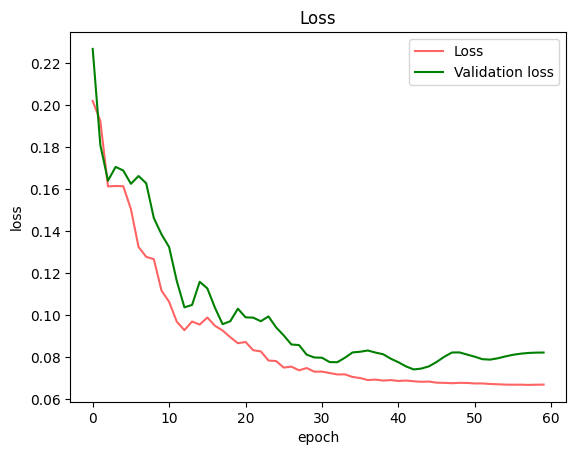

Epoch:  0 | Cost: 0.068377 | Train accuracy: 0.885714 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.41714285714285715, loss: 0.2662875917141986
step 2, accuracy_train:0.56, loss: 0.18339735371446783
step 3, accuracy_train:0.5885714285714285, loss: 0.15419595214331133
step 4, accuracy_train:0.6971428571428572, loss: 0.152787899791523
step 5, accuracy_train:0.6857142857142857, loss: 0.17198946806696622
step 6, accuracy_train:0.6857142857142857, loss: 0.1529223393072932
step 7, accuracy_train:0.7028571428571428, loss: 0.1288181323478437
step 8, accuracy_train:0.7485714285714286, loss: 0.11731413232169548
step 9, accuracy_train:0.76, loss: 0.11083497282866278
step 10, accuracy_train:0.7771428571428571, loss: 0.1006881056029241
step 11, accuracy_train:0.7485714285714286, loss: 0.09692881856364859
step 12, accuracy_train:0.7142857142857143, loss: 0.10465017522637311
step 13, accuracy_train:0.7028571428571428, loss: 0.1077327032801300

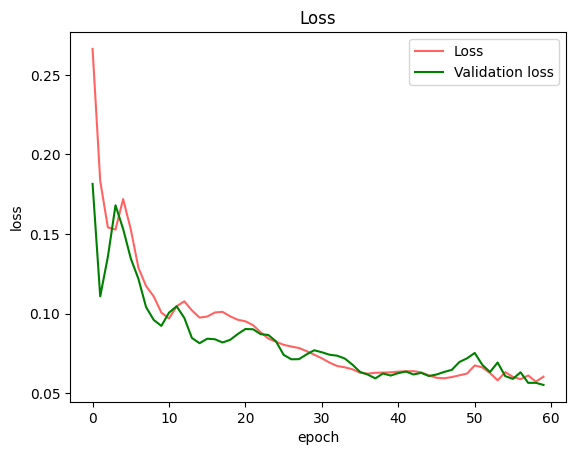

Epoch:  0 | Cost: 0.060367 | Train accuracy: 0.920000 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.29714285714285715, loss: 0.5210330313708099
step 2, accuracy_train:0.3485714285714286, loss: 0.4007147731362648
step 3, accuracy_train:0.5485714285714286, loss: 0.2863552419952754
step 4, accuracy_train:0.6457142857142857, loss: 0.2137009965287399
step 5, accuracy_train:0.6, loss: 0.17191517191188715
step 6, accuracy_train:0.72, loss: 0.13347770110958204
step 7, accuracy_train:0.7028571428571428, loss: 0.12520447804774384
step 8, accuracy_train:0.68, loss: 0.13828917808844046
step 9, accuracy_train:0.6971428571428572, loss: 0.14507326444406968
step 10, accuracy_train:0.7485714285714286, loss: 0.14769601534280408
step 11, accuracy_train:0.7828571428571428, loss: 0.14913504145199824
step 12, accuracy_train:0.8, loss: 0.1476689046631827
step 13, accuracy_train:0.7942857142857143, loss: 0.14153443521069384
step 14, accuracy_train:0.7

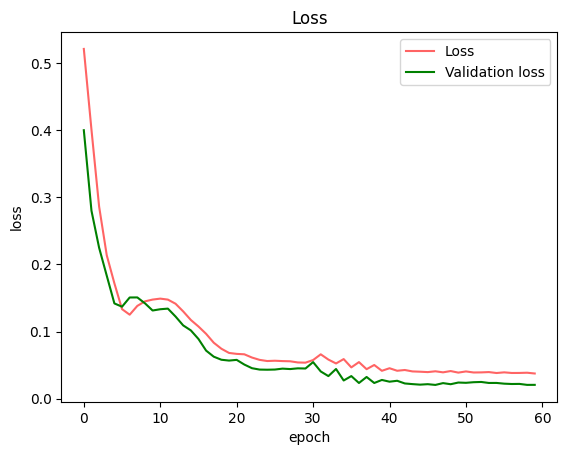

Epoch:  0 | Cost: 0.040906 | Train accuracy: 0.920000 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.18857142857142858, loss: 0.24315091692753296
step 2, accuracy_train:0.44, loss: 0.1942730107744136
step 3, accuracy_train:0.48, loss: 0.1924282324869231
step 4, accuracy_train:0.5885714285714285, loss: 0.15964394978086408
step 5, accuracy_train:0.6857142857142857, loss: 0.1377689385539989
step 6, accuracy_train:0.6171428571428571, loss: 0.1488061591502754
step 7, accuracy_train:0.6457142857142857, loss: 0.14350691374988558
step 8, accuracy_train:0.5828571428571429, loss: 0.14425192140552165
step 9, accuracy_train:0.5542857142857143, loss: 0.14420988194490755
step 10, accuracy_train:0.7028571428571428, loss: 0.12804853014475837
step 11, accuracy_train:0.7257142857142858, loss: 0.12027413838420936
step 12, accuracy_train:0.7314285714285714, loss: 0.12412575983286968
step 13, accuracy_train:0.7542857142857143, loss: 0.11932360352091

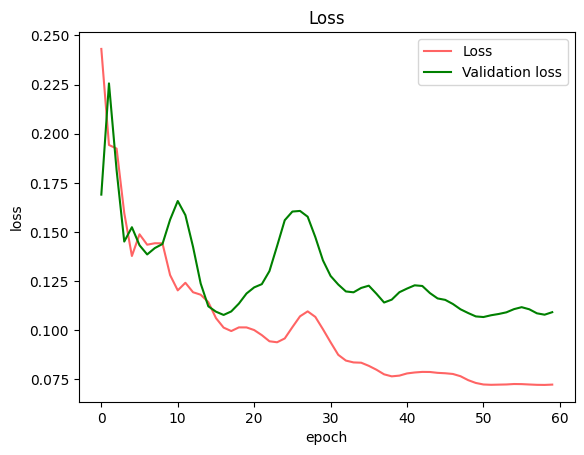

Epoch:  0 | Cost: 0.072369 | Train accuracy: 0.834286 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.37142857142857144, loss: 0.23058479411161004
step 2, accuracy_train:0.64, loss: 0.17114499158324353
step 3, accuracy_train:0.5771428571428572, loss: 0.16994117691154004
step 4, accuracy_train:0.5028571428571429, loss: 0.1833157515108088
step 5, accuracy_train:0.5828571428571429, loss: 0.17022645037130413
step 6, accuracy_train:0.72, loss: 0.15854661404536896
step 7, accuracy_train:0.7085714285714285, loss: 0.1505315886627619
step 8, accuracy_train:0.7257142857142858, loss: 0.13147973498853138
step 9, accuracy_train:0.7257142857142858, loss: 0.11118871845608004
step 10, accuracy_train:0.7485714285714286, loss: 0.09883066913503046
step 11, accuracy_train:0.7657142857142857, loss: 0.09131119818529114
step 12, accuracy_train:0.8057142857142857, loss: 0.08655499682073767
step 13, accuracy_train:0.8285714285714286, loss: 0.089192274215

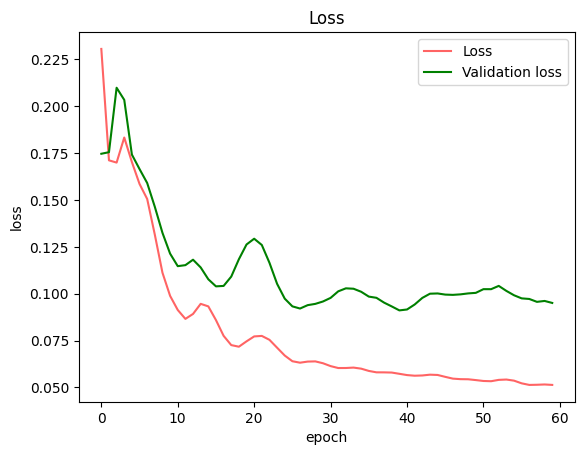

Epoch:  0 | Cost: 0.057253 | Train accuracy: 0.908571 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.28, loss: 0.6123001271105116
step 2, accuracy_train:0.25142857142857145, loss: 0.4814138537801691
step 3, accuracy_train:0.46285714285714286, loss: 0.36327463864376014
step 4, accuracy_train:0.6285714285714286, loss: 0.2630301905152965
step 5, accuracy_train:0.6285714285714286, loss: 0.20218774808453605
step 6, accuracy_train:0.6457142857142857, loss: 0.157863222207649
step 7, accuracy_train:0.6685714285714286, loss: 0.13618150423191647
step 8, accuracy_train:0.76, loss: 0.12198143734496447
step 9, accuracy_train:0.7771428571428571, loss: 0.1142514754757595
step 10, accuracy_train:0.7885714285714286, loss: 0.1338600457902401
step 11, accuracy_train:0.7771428571428571, loss: 0.14121856008263556
step 12, accuracy_train:0.7657142857142857, loss: 0.16481674723370043
step 13, accuracy_train:0.7942857142857143, loss: 0.1640059358502779

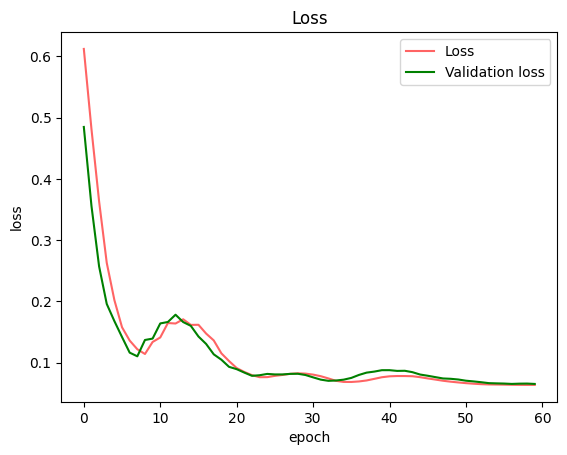

Epoch:  0 | Cost: 0.063753 | Train accuracy: 0.868571 | Validation Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.49142857142857144, loss: 0.21547987369283692
step 2, accuracy_train:0.22285714285714286, loss: 0.2483711136657076
step 3, accuracy_train:0.5657142857142857, loss: 0.16164867726568047
step 4, accuracy_train:0.56, loss: 0.158585676367389
step 5, accuracy_train:0.5428571428571428, loss: 0.16209187979420667
step 6, accuracy_train:0.5485714285714286, loss: 0.15113845495689304
step 7, accuracy_train:0.5771428571428572, loss: 0.1421154961725055
step 8, accuracy_train:0.5942857142857143, loss: 0.1497434163292367
step 9, accuracy_train:0.5942857142857143, loss: 0.14779354173715795
step 10, accuracy_train:0.6228571428571429, loss: 0.13024197993109773
step 11, accuracy_train:0.6514285714285715, loss: 0.11983797953904128
step 12, accuracy_train:0.7028571428571428, loss: 0.11549575281754415
step 13, accuracy_train:0.7714285714285715, loss: 0.

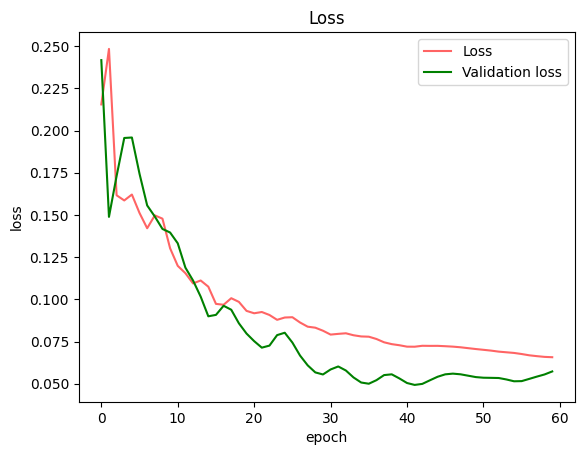

Epoch:  0 | Cost: 0.071924 | Train accuracy: 0.817143 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.30857142857142855, loss: 0.6395291628350062
step 2, accuracy_train:0.5771428571428572, loss: 0.49132343644911575
step 3, accuracy_train:0.6, loss: 0.37556091753531484
step 4, accuracy_train:0.76, loss: 0.2519009732744453
step 5, accuracy_train:0.7314285714285714, loss: 0.19377052063271322
step 6, accuracy_train:0.76, loss: 0.12831328378065934
step 7, accuracy_train:0.76, loss: 0.1128561343164312
step 8, accuracy_train:0.7885714285714286, loss: 0.09800254674887773
step 9, accuracy_train:0.8, loss: 0.10652424127445329
step 10, accuracy_train:0.8457142857142858, loss: 0.11510956159862261
step 11, accuracy_train:0.84, loss: 0.11680936781505787
step 12, accuracy_train:0.8171428571428572, loss: 0.13396342474696718
step 13, accuracy_train:0.8114285714285714, loss: 0.12730952651925556
step 14, accuracy_train:0.8057142857142857, loss: 0.1

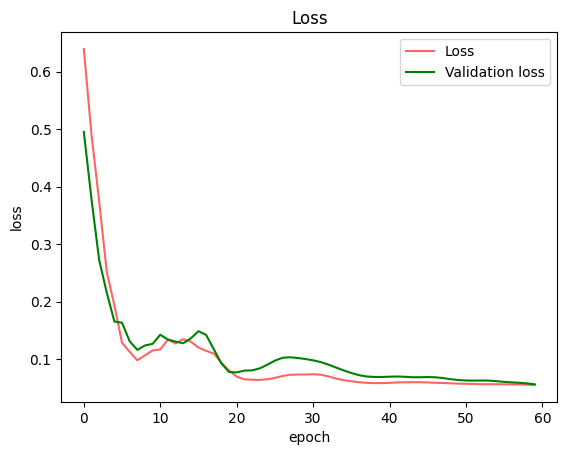

Epoch:  0 | Cost: 0.055150 | Train accuracy: 0.897143 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
step 1, accuracy_train:0.41714285714285715, loss: 0.6062803216450207
step 2, accuracy_train:0.35428571428571426, loss: 0.4731151643115178
step 3, accuracy_train:0.5942857142857143, loss: 0.3400116413427437
step 4, accuracy_train:0.4685714285714286, loss: 0.2649126841031308
step 5, accuracy_train:0.6857142857142857, loss: 0.1804300977785491
step 6, accuracy_train:0.6971428571428572, loss: 0.14413635540082537
step 7, accuracy_train:0.7428571428571429, loss: 0.11371571761292935
step 8, accuracy_train:0.7942857142857143, loss: 0.09866231879628808
step 9, accuracy_train:0.8228571428571428, loss: 0.09069070929067638
step 10, accuracy_train:0.8228571428571428, loss: 0.11768107670801291
step 11, accuracy_train:0.8285714285714286, loss: 0.1391415745831551
step 12, accuracy_train:0.84, loss: 0.15018335767452565
step 13, accuracy_train:0.8228571428571428, loss: 0.1

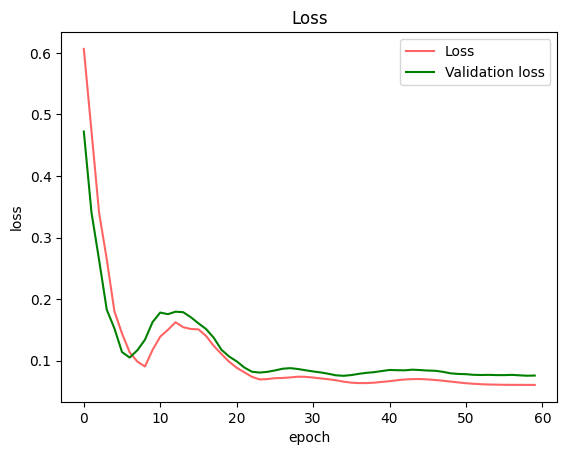

Epoch:  0 | Cost: 0.066016 | Train accuracy: 0.857143 | Validation Accuracy: 0.840000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)
t_n_seeds: 90.16390000000001


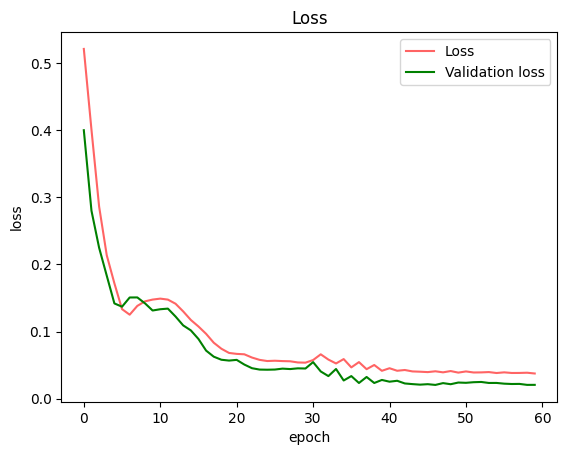

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.28, loss: 0.5206766562505731
step 2, accuracy_train:0.36, loss: 0.40062266947606817
step 3, accuracy_train:0.56, loss: 0.28437191668891687
step 4, accuracy_train:0.64, loss: 0.21575822011643755
step 5, accuracy_train:0.625, loss: 0.1713906298958529
step 6, accuracy_train:0.725, loss: 0.1334556384635968
step 7, accuracy_train:0.715, loss: 0.12696865420132994
step 8, accuracy_train:0.705, loss: 0.13451238765608675
step 9, accuracy_train:0.72, loss: 0.13655806407381582
step 10, accuracy_train:0.765, loss: 0.14392069229860224
step 11, accuracy_train:0.8, loss: 0.14683014217312187
step 12, accuracy_train:0.805, loss: 0.15330904546269117
step 13, accuracy_train:0.815, loss: 0.1483347999677633
step 14, accuracy_train:0.84, loss: 0.1343498624164023
step 15, accuracy_train:0.845, loss: 0.12182192093032262
step 16, accuracy_train:0.84, loss: 0.10762869777802232
step 17, accuracy_train

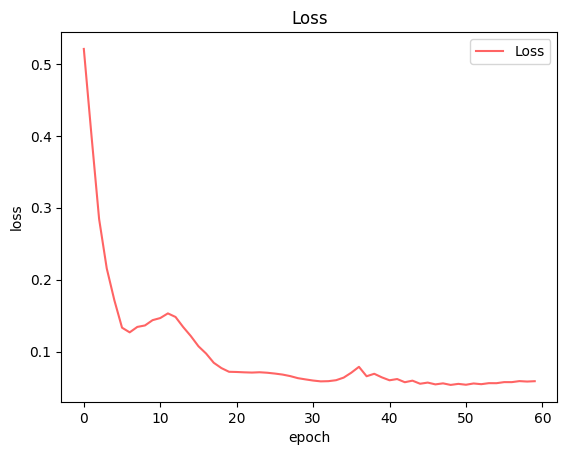

Epoch:  0 | Cost: 0.053947 | Train accuracy: 0.880000 | Test Accuracy: 0.680000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 2, 1, 1, 3)


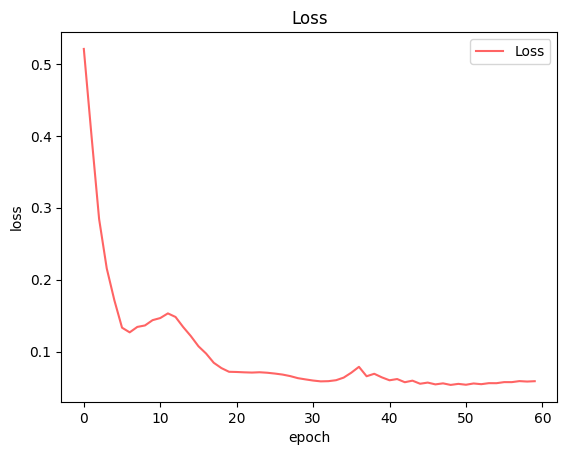

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.2857142857142857, loss: 0.25689471113554085
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 2, accuracy_train:0.4057142857142857, loss: 0.2145893438587841
step 3, accuracy_train:0.6628571428571428, loss: 0.14378981117970804
step 4, accuracy_train:0.64, loss: 0.1477963771341936
step 5, accuracy_train:0.7028571428571428, loss: 0.1375179444216722
step 6, accuracy_train:0.7542857142857143, loss: 0.1248502588736879
step 7, accuracy_train:0.8, loss: 0.11168432418618388
step 8, accuracy_train:0.8514285714285714, loss: 0.09506066368224884
step 9, accuracy_train:0.8342857142857143, loss: 0.09210543127495946
step 10, accuracy_train:0.8228571428571428, loss: 0.08957744995895994
step 11, accuracy_train:0.84, loss: 0.08607226570135003
step 12, accuracy_train:0.8685714285714285, loss: 0.08458598662146544
step 13, accuracy_train:0.84571428571428

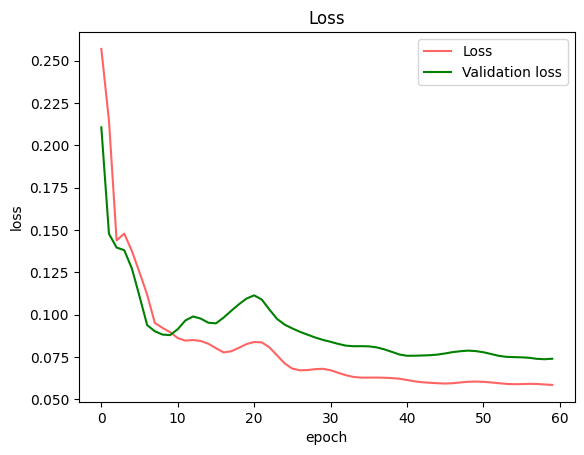

Epoch:  0 | Cost: 0.058675 | Train accuracy: 0.880000 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.37714285714285717, loss: 0.3113872700099073
step 2, accuracy_train:0.48, loss: 0.24147192916247667
step 3, accuracy_train:0.4857142857142857, loss: 0.17820322449150605
step 4, accuracy_train:0.6171428571428571, loss: 0.1448124420426027
step 5, accuracy_train:0.6457142857142857, loss: 0.13215369355758733
step 6, accuracy_train:0.7542857142857143, loss: 0.11656677621391547
step 7, accuracy_train:0.6971428571428572, loss: 0.12268370598036059
step 8, accuracy_train:0.8457142857142858, loss: 0.11458956974987346
step 9, accuracy_train:0.8, loss: 0.13158498892694984
step 10, accuracy_train:0.8685714285714285, loss: 0.1346223219166246
step 11, accuracy_train:0.8342857142857143, loss: 0.13922992084206964
step 12, accuracy_train:0.8628571428571429, loss: 0.1321801381849588
step 13, accuracy_train:0.8742857142857143, loss: 0.117430489829948

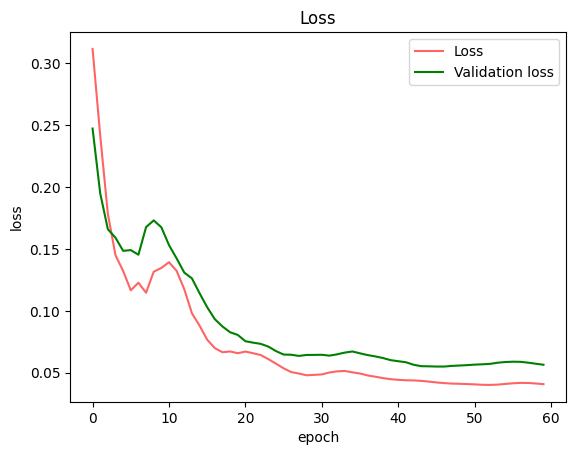

Epoch:  0 | Cost: 0.041639 | Train accuracy: 0.937143 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.45714285714285713, loss: 0.3022477678936173
step 2, accuracy_train:0.45714285714285713, loss: 0.2734960782443633
step 3, accuracy_train:0.5257142857142857, loss: 0.18471376142783585
step 4, accuracy_train:0.6, loss: 0.1643596183734321
step 5, accuracy_train:0.6628571428571428, loss: 0.13802488607188576
step 6, accuracy_train:0.7371428571428571, loss: 0.11716466645761739
step 7, accuracy_train:0.7371428571428571, loss: 0.11954642148565783
step 8, accuracy_train:0.7714285714285715, loss: 0.11412578524519282
step 9, accuracy_train:0.8114285714285714, loss: 0.10643203786013482
step 10, accuracy_train:0.84, loss: 0.10397210145515705
step 11, accuracy_train:0.8342857142857143, loss: 0.11275044142779762
step 12, accuracy_train:0.8685714285714285, loss: 0.0986374215665372
step 13, accuracy_train:0.88, loss: 0.1019809326420043
step 14, ac

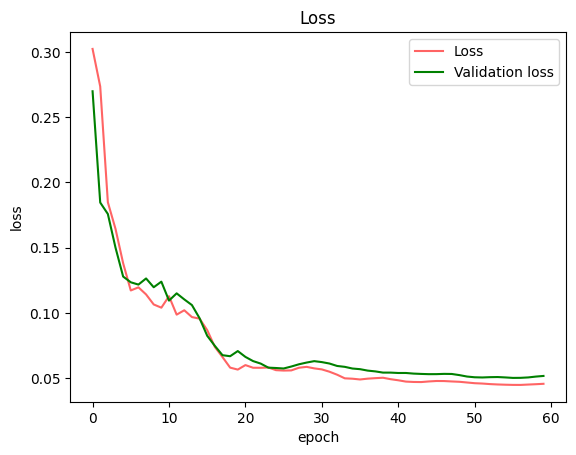

Epoch:  0 | Cost: 0.044802 | Train accuracy: 0.891429 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.18285714285714286, loss: 0.3575185652436683
step 2, accuracy_train:0.33714285714285713, loss: 0.25816390363465014
step 3, accuracy_train:0.41714285714285715, loss: 0.225400559168763
step 4, accuracy_train:0.5314285714285715, loss: 0.19543629362955794
step 5, accuracy_train:0.6171428571428571, loss: 0.16621031256219543
step 6, accuracy_train:0.7657142857142857, loss: 0.14043273256795788
step 7, accuracy_train:0.6628571428571428, loss: 0.13592512124933664
step 8, accuracy_train:0.7142857142857143, loss: 0.12853040810662622
step 9, accuracy_train:0.7542857142857143, loss: 0.12859911778472635
step 10, accuracy_train:0.7657142857142857, loss: 0.13085627015214582
step 11, accuracy_train:0.8228571428571428, loss: 0.12809504284911258
step 12, accuracy_train:0.8342857142857143, loss: 0.13012644983911115
step 13, accuracy_train:0.811428571

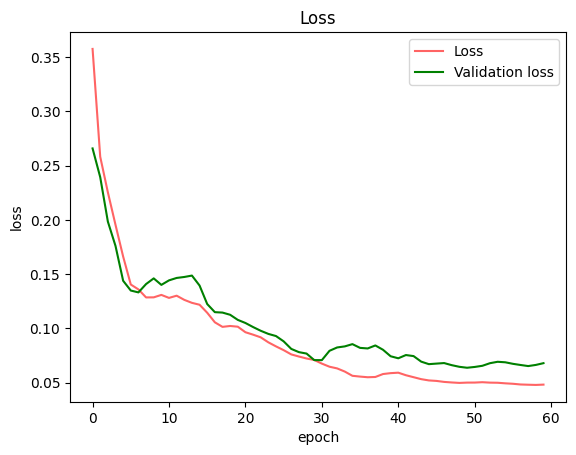

Epoch:  0 | Cost: 0.050046 | Train accuracy: 0.914286 | Validation Accuracy: 0.960000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.34285714285714286, loss: 0.32079307769725046
step 2, accuracy_train:0.4685714285714286, loss: 0.2327997304766518
step 3, accuracy_train:0.5142857142857142, loss: 0.1754477584990528
step 4, accuracy_train:0.6114285714285714, loss: 0.12847335659431786
step 5, accuracy_train:0.68, loss: 0.1256260439570741
step 6, accuracy_train:0.7714285714285715, loss: 0.1143006896453733
step 7, accuracy_train:0.7885714285714286, loss: 0.12378844302801705
step 8, accuracy_train:0.84, loss: 0.12583814022850248
step 9, accuracy_train:0.8457142857142858, loss: 0.12445576966155548
step 10, accuracy_train:0.8457142857142858, loss: 0.12486191865745165
step 11, accuracy_train:0.8514285714285714, loss: 0.11583908389769675
step 12, accuracy_train:0.88, loss: 0.09969493417968432
step 13, accuracy_train:0.8914285714285715, loss: 0.08974840055320592
step 14, a

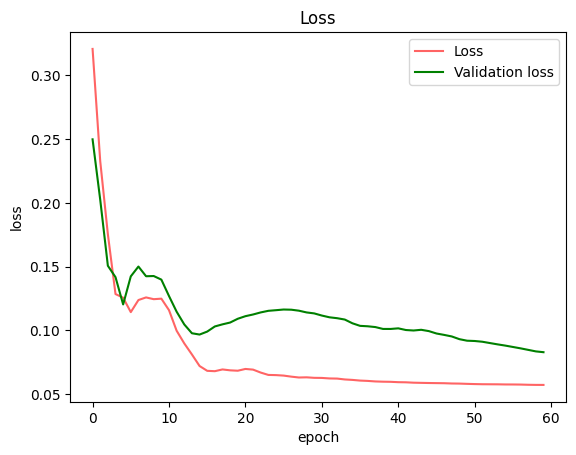

Epoch:  0 | Cost: 0.057190 | Train accuracy: 0.897143 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.35428571428571426, loss: 0.5438498748647067
step 2, accuracy_train:0.45714285714285713, loss: 0.41189658759427605
step 3, accuracy_train:0.5542857142857143, loss: 0.306689730554098
step 4, accuracy_train:0.7028571428571428, loss: 0.2147070301283408
step 5, accuracy_train:0.6114285714285714, loss: 0.16490077002416825
step 6, accuracy_train:0.6571428571428571, loss: 0.13323765741340438
step 7, accuracy_train:0.6914285714285714, loss: 0.11037743485317454
step 8, accuracy_train:0.7371428571428571, loss: 0.10591386481842513
step 9, accuracy_train:0.8171428571428572, loss: 0.11177733832669684
step 10, accuracy_train:0.8685714285714285, loss: 0.1218846204620067
step 11, accuracy_train:0.8571428571428571, loss: 0.14180820713641723
step 12, accuracy_train:0.8571428571428571, loss: 0.15771733370425867
step 13, accuracy_train:0.857142857142

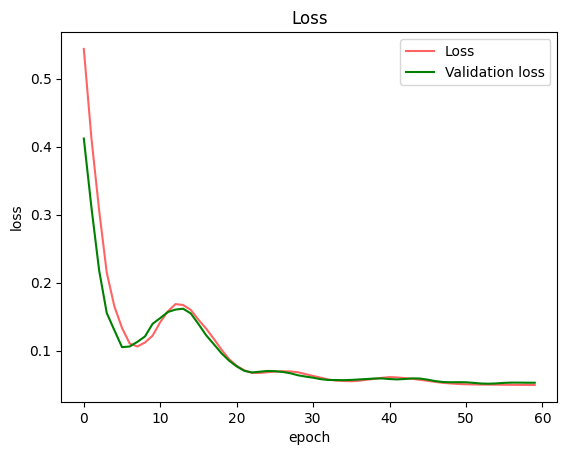

Epoch:  0 | Cost: 0.049799 | Train accuracy: 0.914286 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.18857142857142858, loss: 0.31339385311140683
step 2, accuracy_train:0.3314285714285714, loss: 0.22371935745101215
step 3, accuracy_train:0.6057142857142858, loss: 0.16749613405702948
step 4, accuracy_train:0.6571428571428571, loss: 0.12990322562747664
step 5, accuracy_train:0.6171428571428571, loss: 0.13587778229458142
step 6, accuracy_train:0.7028571428571428, loss: 0.13507703382451236
step 7, accuracy_train:0.7257142857142858, loss: 0.14454028424176205
step 8, accuracy_train:0.72, loss: 0.15187549717960172
step 9, accuracy_train:0.7371428571428571, loss: 0.14693745151303733
step 10, accuracy_train:0.7371428571428571, loss: 0.14417410939825548
step 11, accuracy_train:0.7428571428571429, loss: 0.13633704014138126
step 12, accuracy_train:0.7428571428571429, loss: 0.1296908623232769
step 13, accuracy_train:0.7428571428571429, loss:

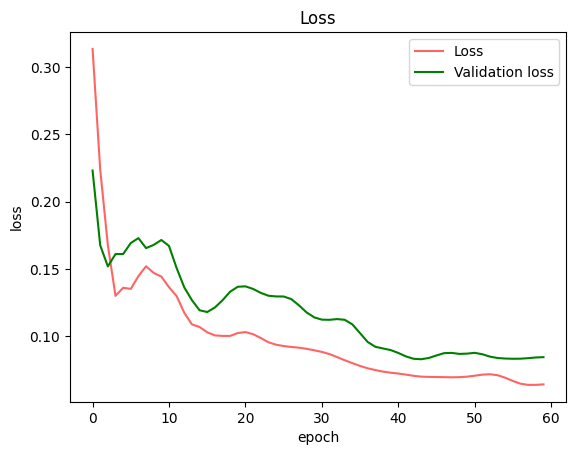

Epoch:  0 | Cost: 0.069860 | Train accuracy: 0.868571 | Validation Accuracy: 0.800000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.25142857142857145, loss: 0.24418894886688447
step 2, accuracy_train:0.19428571428571428, loss: 0.2563967905581196
step 3, accuracy_train:0.5314285714285715, loss: 0.19909165902787032
step 4, accuracy_train:0.35428571428571426, loss: 0.21144616954581644
step 5, accuracy_train:0.49714285714285716, loss: 0.2034815648085563
step 6, accuracy_train:0.49714285714285716, loss: 0.21774288469049277
step 7, accuracy_train:0.6228571428571429, loss: 0.20263730369606434
step 8, accuracy_train:0.6285714285714286, loss: 0.20576957466965493
step 9, accuracy_train:0.68, loss: 0.17564005836503724
step 10, accuracy_train:0.6742857142857143, loss: 0.17036891043043187
step 11, accuracy_train:0.64, loss: 0.16746690373311693
step 12, accuracy_train:0.6971428571428572, loss: 0.15842982702630093
step 13, accuracy_train:0.7314285714285714, loss: 0.14918974

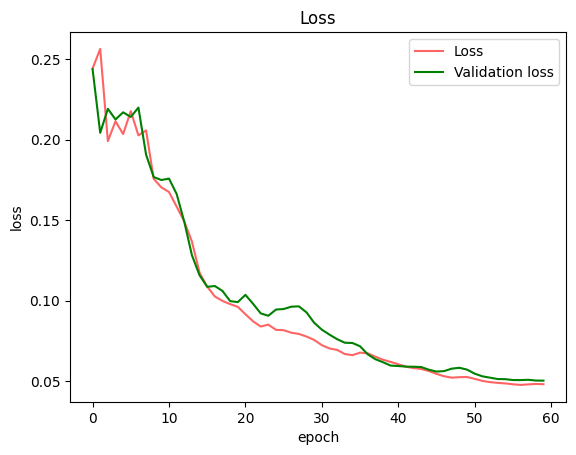

Epoch:  0 | Cost: 0.048020 | Train accuracy: 0.937143 | Validation Accuracy: 1.000000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.1657142857142857, loss: 0.35716230801703147
step 2, accuracy_train:0.3485714285714286, loss: 0.2667730755050501
step 3, accuracy_train:0.37714285714285717, loss: 0.2101940909028759
step 4, accuracy_train:0.4742857142857143, loss: 0.17821859697163053
step 5, accuracy_train:0.5142857142857142, loss: 0.1531023879682292
step 6, accuracy_train:0.6171428571428571, loss: 0.1523571466734691
step 7, accuracy_train:0.6285714285714286, loss: 0.15808879087810035
step 8, accuracy_train:0.6628571428571428, loss: 0.16116356785809485
step 9, accuracy_train:0.6342857142857142, loss: 0.15983710756769148
step 10, accuracy_train:0.64, loss: 0.1643794519267672
step 11, accuracy_train:0.6914285714285714, loss: 0.15609116655095337
step 12, accuracy_train:0.7371428571428571, loss: 0.14239992652739136
step 13, accuracy_train:0.8171428571428572, loss: 0.1

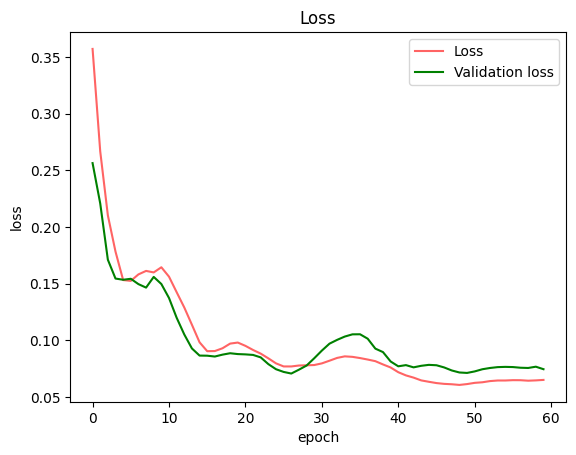

Epoch:  0 | Cost: 0.076810 | Train accuracy: 0.840000 | Validation Accuracy: 0.920000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
step 1, accuracy_train:0.49714285714285716, loss: 0.437807657174102
step 2, accuracy_train:0.3485714285714286, loss: 0.3572814024229463
step 3, accuracy_train:0.5828571428571429, loss: 0.249607769714936
step 4, accuracy_train:0.5257142857142857, loss: 0.2008055875608587
step 5, accuracy_train:0.72, loss: 0.13665842382342896
step 6, accuracy_train:0.7771428571428571, loss: 0.11821008890862253
step 7, accuracy_train:0.8057142857142857, loss: 0.10730306940344435
step 8, accuracy_train:0.8342857142857143, loss: 0.12140577502308152
step 9, accuracy_train:0.8171428571428572, loss: 0.1340111715271928
step 10, accuracy_train:0.8171428571428572, loss: 0.13283115127215242
step 11, accuracy_train:0.8457142857142858, loss: 0.13970681468413923
step 12, accuracy_train:0.8628571428571429, loss: 0.13277891917380993
step 13, accuracy_train:0.8685714285714285, loss: 0.127

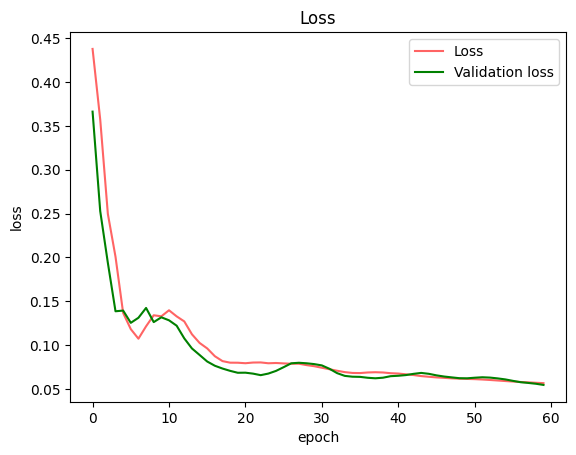

Epoch:  0 | Cost: 0.056606 | Train accuracy: 0.897143 | Validation Accuracy: 0.880000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)
t_n_seeds: 168.8784704000002


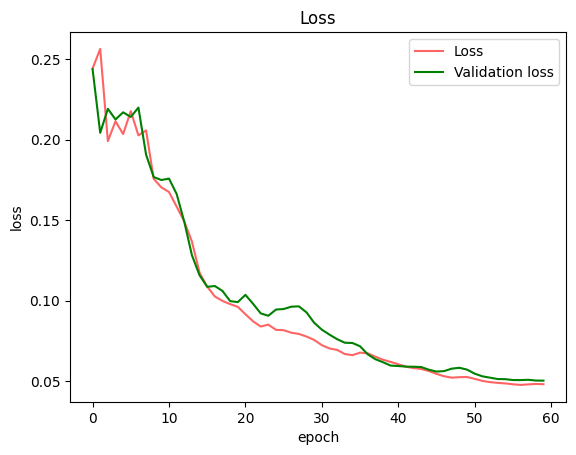

circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
circuit_end is jitted
step 1, accuracy_train:0.25, loss: 0.24411236247447513
step 2, accuracy_train:0.185, loss: 0.25482463627893176
step 3, accuracy_train:0.515, loss: 0.19871592665602558
step 4, accuracy_train:0.33, loss: 0.2115325024425345
step 5, accuracy_train:0.53, loss: 0.2105525833396164
step 6, accuracy_train:0.475, loss: 0.21687962607847408
step 7, accuracy_train:0.61, loss: 0.20636938266444843
step 8, accuracy_train:0.62, loss: 0.20231721110596376
step 9, accuracy_train:0.72, loss: 0.17676023750936892
step 10, accuracy_train:0.65, loss: 0.1734850276035161
step 11, accuracy_train:0.63, loss: 0.16536530457600368
step 12, accuracy_train:0.64, loss: 0.16354504298930816
step 13, accuracy_train:0.7, loss: 0.1520468509955746
step 14, accuracy_train:0.73, loss: 0.1391896172331639
step 15, accuracy_train:0.77, loss: 0.12196007104226575
step 16, accuracy_train:0.78, loss: 0.1107280882783975
step 17, accuracy_train:0.805

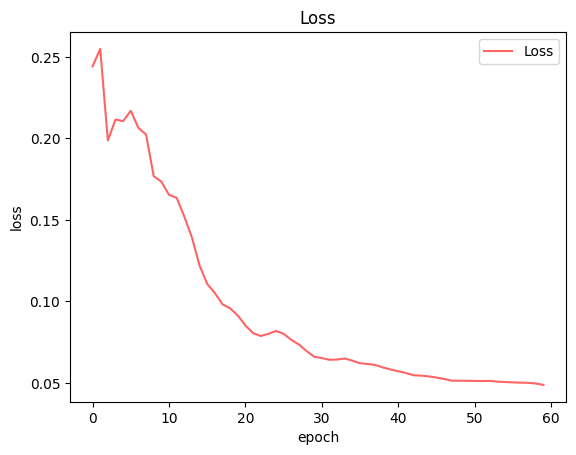

Epoch:  0 | Cost: 0.048806 | Train accuracy: 0.935000 | Test Accuracy: 0.760000
(n_dim, n_q, n_f, n_r, n_rot) = (5, 3, 1, 1, 3)


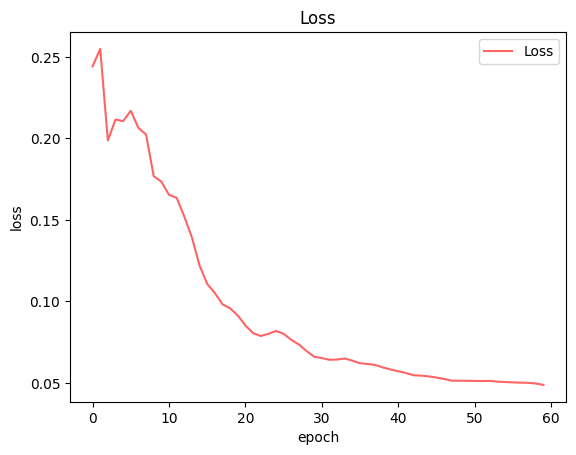

In [19]:
t_seed_start = time.process_time()
configs['noise'] = training_noise
best_params = []
results = []
for i,setting in enumerate(settings):
    enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
    learning_rate,max_epoch,batch_size,dynamic_size,threshold = h_pms[best_h_pm[i]]
    t_seed_start = time.process_time()
    # Generate training and test data
    X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
    configs['qc'] = qcircuit(*setting, **configs)
    
    seed_rsts, seed_params = [], []
    loss_history_seeds= []
    #run 10 seeds
    for seed_num in seeds:
        #########
        loss_history = []
        valid_loss_history = []
        accuracy_history = []  
        configs['iter_lr'] = iter(learning_rate)
        configs['iter_thres'] = iter(list(threshold))
        configs['lr'] = next(configs['iter_lr'])
        configs['thres_n'] = next(configs['iter_thres'])

        seed_rst = run(seed_num, X_train, y_train, *setting, **configs)
        #########
        seed_params.append(seed_rst[0])
        seed_rsts.append(seed_rst[1])
        loss_history_seeds.append([loss_history,valid_loss_history])
    t_n_seeds = time.process_time()-t_seed_start
    print('t_n_seeds:', t_n_seeds)
    best_index = np.argmax(seed_rsts,axis=0)[2]  #best index based on validation accuracy->(seed_num,accuracy_train, accuracy_valid,...) 
    #best_rst = seed_rsts[best_index]
    seed_num = seeds[best_index]
    l_h_best, val_l_h_best = loss_history_seeds[best_index]
    plot_loss_history(l_h_best, val_l_h_best, setting=setting,
                      fig_name = f'{setting}_loss_best_seed')
    #########
    configs['noise'] = test_noise
    loss_history = []
    valid_loss_history = []
    accuracy_history = []
    configs['iter_lr'] = iter(learning_rate)
    configs['iter_thres'] = iter(list(threshold))
    configs['lr'] = next(configs['iter_lr'])
    configs['thres_n'] = next(configs['iter_thres'])
    params,best_rst = run(seed_num, X_train, y_train, x_te = X_test, y_te = y_test, ratio_tr=1, *setting, **configs)
    plot_loss_history(loss_history, setting=setting)
    #########
    best_params.append(params)
    results.append([enc_dim,num_qubits,num_layers,num_reupload,num_rot,*best_rst, t_n_seeds])
t_seeds = time.process_time()-t_seed_start

In [20]:
def name_experiment(num_settings,start_value):
    exp_name = '('
    exp = ['enc','q','f','r','rot']
    # if len(exp)!=len(num_settings): print(experiment styles not matched!)
    for i, j in enumerate(num_settings):
        exp_name = exp_name+f'{start_value[i]}' if j==1 else exp_name+f'{exp[i]}'
        exp_name = exp_name+')' if i==len(exp)-1 else exp_name+','
    return exp_name
exp_name = name_experiment(num_settings,start_values)
exp_name

'(5,q,1,1,3)'

In [21]:
import pandas as pd
data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'seed_num' : [],
        'Train_acc' : [],
        'Test_acc' : [],
        'loss' : [],
        'num_epoch':[],
        f'time_{num_seeds}_seeds' : []}
for result in results:
    for i,(d,r) in enumerate(zip(data,result)):
        print(d,r)
        if i<5: data[d].append(int(r));
        else:   data[d].append(float(r))

# 将数据转换为DataFrame
df = pd.DataFrame(data)
df.style.hide()
# 显示DataFrame
#print(df.to_string(index=False))
# 若要在Jupyter Notebook中显示漂亮的表格，可以使用以下方法
display(df)
# 如果需要将DataFrame保存为HTML文件，可以使用以下方法
# df.to_html('table.html')

# Export to Excel
excel_file_path = f'Data_{exp_name}.xlsx'
sheet_name = 'Sheet1'

df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

enc_dim 5
num_qubits 1
num_layers 1
num_reupload 1
num_rot  3
seed_num 68678
Train_acc 0.88
Test_acc 0.72
loss 0.0649940166747986
num_epoch 60
time_10_seeds 41.388587500000085
enc_dim 5
num_qubits 2
num_layers 1
num_reupload 1
num_rot  3
seed_num 4174
Train_acc 0.88
Test_acc 0.68
loss 0.05394690558795287
num_epoch 60
time_10_seeds 90.16390000000001
enc_dim 5
num_qubits 3
num_layers 1
num_reupload 1
num_rot  3
seed_num 83505
Train_acc 0.935
Test_acc 0.76
loss 0.048806144859453664
num_epoch 60
time_10_seeds 168.8784704000002


enc_dim  num_qubits  num_layers  num_reupload  num_rot   seed_num  \
0        5           1           1             1         3   68678.0   
1        5           2           1             1         3    4174.0   
2        5           3           1             1         3   83505.0   

   Train_acc  Test_acc      loss  num_epoch  time_10_seeds  
0      0.880      0.72  0.064994       60.0      41.388588  
1      0.880      0.68  0.053947       60.0      90.163900  
2      0.935      0.76  0.048806       60.0     168.878470

In [22]:
rec_settings = {'problem':problem,
                'shape':shape, 
                'rot':rot,
                'num_training':len(X_train),
                'num_test':len(X_test),
                'preprocess':configs['preprocess'],
                'max_converge_number':max_n_converge,
                'threshold_of_converge':thres_converge,
                'data_seed_num': data_seed_num,
                'param_seed_nums': seeds,
                f't_{num_cvs}_cv': f'{t_cvs} s',
                f't_{num_seeds}_seeds': f'{t_seeds} s',
                '[enc_dim,num_qubits,num_layers,num_reupload,num_rot]':settings,
                '[learning_rate,max_epoch,batch_size,dynamic_size,threshold]':[h_pms[i] for i in best_h_pm ]
               }
#dict_settings = {k:v for i,(k,v) in enumerate(data.items()) if i<6 }

In [23]:
F = open("{}_settings.txt".format(ver), "w")
for i,j in rec_settings.items():
    F.write(i+": {}\n".format(j))
    
for i,setting in enumerate(settings):
    F.write(f"params of setting {setting}：\n")
    for key, value in best_params[i].items():
        F.write(f"    {key}: {value} \n")
F.close()

In [24]:
print(t_cvs)
t_seeds

1431.1143184


191.02120670000022

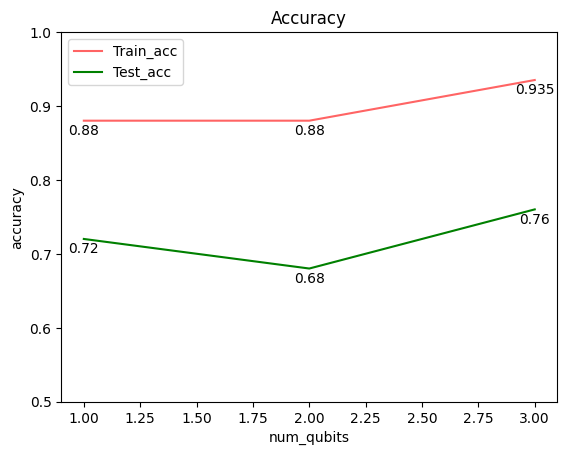

In [25]:
for run_exp, x_label in zip([i != 1 for i in num_settings],data):
    if run_exp:
        fig, ax = plt.subplots(1, 1)
        ax.set_ylim([0.5, 1])
        plt.plot(data[x_label],data['Train_acc'],color=(255/255,100/255,100/255),label='Train_acc')
        plt.plot(data[x_label],data['Test_acc'],color='g',label='Test_acc')
        for i,j,k in zip(data[x_label],data['Train_acc'],data['Test_acc']):
            ax.annotate(f'{j}', xy=(i,j), xytext=(0,-10), textcoords='offset points' ,ha='center')
            ax.annotate(f'{k}', xy=(i,k), xytext=(0,-10), textcoords='offset points' ,ha='center')
        plt.title("Accuracy") # title
        plt.ylabel("accuracy") # y label
        plt.xlabel(x_label) # x label
        plt.legend()
        plt.show()
        fig.savefig(f'Accuracy-{x_label}.png', transparent=True)

In [96]:
for i in best_h_pm:
    print(h_pms[i])
best_h_pm

((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))
((0.15, 0.05, 0.01), 60, 100, 50, (0.05, 0.03, 0.01))
((0.15, 0.05, 0.01), 60, 300, 50, (0.05, 0.03, 0.01))


[np.int64(2), np.int64(1), np.int64(2)]

In [97]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report

X_train, y_train, X_test, y_test = initialize_data(problem,num_training,num_test,seed_num,enc_dim,**configs)
max_search_n=20
n_nodes = []
t1_c = time.process_time()

r_enc, r_q ,r_f, r_r, r_rot = num_settings 

for f in range(r_f):
    scores=[]
    for n in range(max_search_n):
        size = [n+1]*(f+1)
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                            random_state=data_seed_num,max_iter=6000, warm_start=False)
        score = np.min(cross_val_score(clf, X_train, y_train, cv=10))  
        if score >= data['Test_acc'][f] or n == (max_search_n-1): 
            n_nodes.append(n+1)
            break

sizes = [[n_nodes[f]]*(f+1) for f in range(r_f)] if r_f!=1 else [[n_nodes[f]]]*len(settings)
accuracy_tr, accuracy=[],[]

for size in sizes:
    seed_tr_rsts, seed_rsts = [], []
    for seed in seeds:
        clf = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=size, 
                                random_state=seed,max_iter=6000, warm_start=False)
        clf.fit(X_train, y_train)
        y_pred_tr = clf.predict(X_train)
        y_pred = clf.predict(X_test)
        # report = classification_report(y_test, y_pred)
        seed_tr_rsts.append(accuracy_score(y_train, y_pred_tr))
        seed_rsts.append(accuracy_score(y_test, y_pred))
    accuracy_tr.append(np.average(seed_tr_rsts))
    accuracy.append(np.average(seed_rsts))
t_c_tot = time.process_time()-t1_c
print(f'Time for classical NN: {t_c_tot} s') # Need modified  as detail version
print(accuracy_tr)
print(accuracy)
print(data['Test_acc'])
sizes

Time for classical NN: 9.135480099999995 s
[np.float64(0.6975), np.float64(0.6975), np.float64(0.6975)]
[np.float64(0.68), np.float64(0.68), np.float64(0.68)]
[0.72, 0.68, 0.76]


[[2], [2], [2]]

In [98]:
def param_n_model(settings, model='NN'):
    if model=='NN':
        n_params = []
        for n_nodes in settings:
            # n_params = []
            r_f = len(n_nodes)
            for f in range(r_f):
                n_p=0
                for i in range(f+1):
                    n_p=n_p+(len(X_train[0])+1)*n_nodes[f] if i==0  else n_p
                    n_p=n_p+(n_nodes[i]+1)*num_class if i==(r_f-1) else n_p
                    n_p=n_p+(n_nodes[f]+1)*n_nodes[f] if i!=0 or i!=(r_f-1) else n_p
                n_params.append(n_p)
    if model=='QNN':
        n_params=[]
        for setting in settings:
            enc_dim,num_qubits,num_layers,num_reupload,num_rot = setting
            n_params.append((enc_dim +num_rot*3)*num_qubits*num_reupload*num_layers+ num_class* num_qubits)

    return n_params
num_params_NN = param_n_model(sizes,model='NN')
num_params_QNN = param_n_model(settings,model='QNN') 

print('Number of params in NN model:', num_params_NN)
print('Number of params in QNN model:', num_params_QNN)

Number of params in NN model: [np.int64(15), np.int64(15), np.int64(15)]
Number of params in QNN model: [np.int64(15), np.int64(30), np.int64(45)]


In [99]:
import pandas as pd
c_values=np.array([[str(size) for size in sizes],accuracy_tr,accuracy,data['Test_acc'],
                   num_params_NN,num_params_QNN,[t_c_tot]*len(settings)])
c_values=np.append(settings,c_values.T, axis=1)
c_data = {'enc_dim' : [],
        'num_qubits' : [],
        'num_layers' : [],
        'num_reupload' : [],
        'num_rot ': [],
        'num_c_nodes ': [],
        'C_train_acc' : [],
        'C_test_acc' : [],
        'Q_test_acc' : [],
        'num_params_NN' : [],
        'num_params_QNN' : [],
        f'time_{num_seeds}_seeds' : []}
for result in c_values:
    for i,(d,r) in enumerate(zip(c_data,result)):
        # if type(r) is np.str_: c_data[d].append(r);
        # elif i<6: c_data[d].append(int(r));
        # else:   c_data[d].append(float(r))
        if i<6: c_data[d].append(r);
        else:   c_data[d].append(float(r))


df = pd.DataFrame(c_data)
df.style.hide()
display(df)
# Export to Excel
excel_file_path = f'classical_data_comparism.xlsx'
sheet_name = 'Sheet1'
df.to_excel(excel_file_path, index=False, sheet_name=sheet_name)

enc_dim num_qubits num_layers num_reupload num_rot  num_c_nodes   \
0       5          1          1            1        3          [2]   
1       5          2          1            1        3          [2]   
2       5          3          1            1        3          [2]   

   C_train_acc  C_test_acc  Q_test_acc  num_params_NN  num_params_QNN  \
0       0.6975        0.68        0.72           15.0            15.0   
1       0.6975        0.68        0.68           15.0            30.0   
2       0.6975        0.68        0.76           15.0            45.0   

   time_10_seeds  
0        9.13548  
1        9.13548  
2        9.13548

In [100]:
for fx

SyntaxError: invalid syntax (2384900765.py, line 1)

In [101]:
# from qiskit.providers.fake_provider import FakeBelem
# backend = FakeBelem()
# # backend.qubit_properties()
# from datetime import datetime

# t = datetime(day=15, month=4, year=2020, hour=10)
# backend.properties(datetime=t)

In [ ]:
F = open("{}_settings.txt".format(ver), "a")
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    ), file = F)#)#

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_test[:,:], initial_predictions, fig, axes[0])
plot_data(X_test[:,:], predicted_test, fig, axes[1])
plot_data(X_test[:,:], y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Training Accuracy = {} \n Test Accuracy = {}".format(accuracy_train,accuracy_test))
axes[2].set_title("True test data \n # of points = {}".format(num_test))
plt.tight_layout()
plt.show()
fig.savefig('{}_train.png'.format(ver), transparent=True)

In [104]:
#initialize_data(problem,num_Test,seed_num=seed_num)

In [ ]:
num_Test = 568
configs['noise'] = test_noise
X_Test, y_Test = initialize_data(problem,num_Test,seed_num=seed_num,**configs)#data_gen(problem,num_Test,seed_num=np.random.randint(num_Test))#circle(num_test)#
predicted_Test, loss, _  = test(params, X_Test, y_Test,*setting,**configs)
accuracy_Test = accuracy_score(y_Test, predicted_Test)  


print("Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_Test), file = F)



fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train[:,:,], y_train, fig, axes[0])
plot_data(X_Test[:,:], predicted_Test, fig, axes[1])
plot_data(X_Test[:,:], y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy = {}".format(accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_test.png'.format(ver), transparent=True)
print("process_time ：%f s" % (time.process_time()- end))

In [ ]:
for fx

In [ ]:
%whos 

In [ ]:
# from qiskit_ibm_provider import least_busy
# backend = least_busy(provider.backends(min_num_qubits=5,simulator=False,operational=True))
# backend = backend.name
# print(backend)

In [ ]:
#noisy device
str_error = None
noise=True
noise_num_Test = 100
sleep_time = 2
num_retries = 10
noise_batch_size = 9 if real_device else noise_num_Test
#ver = ver+'_'+backend if noise else ver

noise_start = time.time()
noise_XTest, noise_y_Test = data_gen(problem,noise_num_Test,seed_num=noise_num_Test)#circle(num_test)#
noise_X_Test = np.hstack((np.zeros((noise_num_Test,1)), noise_XTest))
noise_predicted_Test = jnp.array([])
noise_minibatches = iterate_minibatches(noise_X_Test, noise_y_Test, batch_size=noise_batch_size)
backend = 'ibm_algiers'
print(backend,noise_start)

In [ ]:
while True:
    try: 
        if not str_error:
            Xbatch, ybatch = next(noise_minibatches)
        for x in range(0, num_retries):  
            try:
                str_error = 'Calculating...'
                configs['noise'] = test_noise
                predicted, loss, _  = test(params, Xbatch, ybatch,*setting,**configs)
                noise_predicted_Test = jnp.append(noise_predicted_Test, predicted)
                print(predicted)
                str_error = None
            except Exception as e:
                str_error = str(e)
                print('err:',str_error)
            if str_error:               # if None->break, if 'some_string'(error happens)->sleep and retry
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 1.5  
                if x==(num_retries-1):
                    print('operation fail')
                else:
                    print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break
noise_end = time.time()

In [ ]:
noise_accuracy_Test = accuracy_score(noise_y_Test, noise_predicted_Test)  
print("noise:",noise,", real_device:",real_device,', backend:',backend,', num_noise_Test:',noise_num_Test,file = F)#)#
print("Cost: {:3f} | Noisy Test Accuracy : {:3f}".format(loss, noise_accuracy_Test), file = F)#)#
print("process_time ：%f s" % (noise_end- noise_start), file = F)#)#
print(datetime.datetime.now(), file = F)#)#
# print('noise_model:', None if real_device else noise_model, file = F)
F.close()#
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
plot_data(X_train, y_train, fig, axes[0])
plot_data(noise_X_Test[:,1:], noise_predicted_Test, fig, axes[1])
plot_data(noise_X_Test[:,1:], noise_y_Test, fig, axes[2])
axes[0].set_title("Training data")
axes[1].set_title("Predictions after training \n Accuracy with noise = {}".format(noise_accuracy_Test))
axes[2].set_title("True test data \n # of points = {}".format(noise_num_Test))
plt.tight_layout()
plt.show()
fig.savefig('{}_noise_test.png'.format(ver), transparent=True)

In [ ]:
qml.about()

In [ ]:
a = [(i,j) for i,j in zip(globals().keys(),globals().values())]
import sys
for i,j in a:
    print(i,sys.getsizeof(j))

In [ ]:
ibm_brisbane

In [ ]:
dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)

In [ ]:
# minimum qiskit-runtime connect-testing code

sleep_time = 5
num_retries = 5
str_error = None
initial_layout = [1,2]# None#
backend = 'ibmq_mumbai' #'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout,start_session=True)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.Hermitian([[1,0],[0,0]],wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                rst = circuit(*databatch)
                print('result:',rst)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
dm_labels[0]

In [ ]:
initial_layout = [1,2]#None #
backend = 'ibm_auckland'# 'ibmq_qasm_simulator' # or 
program_id = 'qiskit.ibmq.sampler' #'qiskit.ibmq.circuit_runner' # 
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
dev = qml.device(program_id, wires=2, backend=backend
                 , provider=provider,initial_layout=initial_layout)

@qml.qnode(dev)
def circuit(x, y):
    qml.RY(y, wires=[0])
    qml.RX(x, wires=[0])
    qml.CNOT(wires=[0,1])
    return qml.expval(qml.PauliZ(wires=0)),qml.expval(qml.PauliY(wires=1))

data = iter([[[0.1,0.2,0.3],[0.2,0.3,0.4]],[[0.4,0.5,0.6],[0.5,0.6,0.7]]])
databatch = next(data)
databatch = next(data)
circuit(*databatch)

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session

In [ ]:
##qiskit version
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler, Estimator, Options

shots = 2048
sleep_time = 5
num_retries = 5
str_error = None
initial_layout = None#[1,2]
provider = IBMProvider(instance='ibm-q-hub-ntu/ntu-internal/default')
backend = provider.get_backend('ibmq_jakarta')#'ibm_hanoi')#'ibmq_qasm_simulator')#'ibmq_quito')
runtime_service = QiskitRuntimeService(channel="ibm_quantum")
options = {"backend": backend.name}
def qcircuit(x,y):
    qr = QuantumRegister(2)
    cr = ClassicalRegister(2)
    circuit = QuantumCircuit(qr, cr)
    circuit.rx(x,qr[0])
    circuit.ry(y,qr[1])
    circuit.cx(qr[0], qr[1])
    circuit.measure(qr, cr)
    mapped_circuit = transpile(circuit, backend=backend)
    return mapped_circuit
data = iter([[0.1,0.2],[0.2,0.3],[0.4,0.5]])

while True:
    try:
        if not str_error:
            databatch=next(data)
        for x in range(0, num_retries):  
            try:
                program_inputs = {"circuits": qcircuit(*databatch)  , "shots": shots , 'initial_layout':initial_layout
                                  , 'optimization_level': 3,'start_session': True}
                job = runtime_service.run(program_id="circuit-runner", options=options, inputs=program_inputs)#
                counts = job.result().get_counts()
                print('result:',counts)
                str_error = None
            except  Exception as e:
                str_error = str(e)
                print(e)
            if str_error:               # if None->break; if 'some_string'(error happens)->sleep
                time.sleep(sleep_time)  # wait before trying to fetch the data again
                sleep_time *= 3
                print(f'retry {x} times')
            else:
                break
    except StopIteration:
        break

In [ ]:
circuit(*databatch)

In [ ]:
# provider = IBMProvider()
# dev = qml.device('qiskit.ibmq', wires=2, backend=backend, provider=provider)
# dev.capabilities()['backend']

In [ ]:




from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
x,y = load_breast_cancer(return_X_y=True)
x.shape